In [1]:
import os
import re
import pandas as pd

In [11]:
%config InlineBackend.figure_format='retina'


# functions

In [2]:
def extract_accuracies(name, autoreg=True):
    results_dir = '../results/all_results_by_model'
    
    # Initialize an empty list to store the extracted data
    data = []
    
    # Walk through all subdirectories and files
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            if file.startswith('accuracy'):
                # Open the file and search for the accuracy line
                with open(os.path.join(root, file), 'r') as f:
                    content = f.read()
                    #print(content)
                    if autoreg:
                        matches = re.findall(rf'Prediction accuracy of model Hyper_{name}([0-9a-z]+): ([0-9]+\.[0-9]+)% tested on ([0-9]+) examples', content)
                    else:
                        matches = re.findall(rf'Prediction accuracy of model {name}([0-9a-z]+): ([0-9]+\.[0-9]+)% tested on ([0-9]+) examples', content)


                    for match in matches:
                        eval_on='test_set'
                        if    'val_data' in os.path.basename(file): eval_on='val_set'
                        elif 'train_data'in os.path.basename(file): eval_on='train_set'
                        letter = match[0]
                        accuracy = float(match[1])
                        n = float(match[2])
                        if n==12000 : eval_on='test2_set'
                        data.append({'Letter': letter, 'Accuracy': accuracy, 'n':n, 'Eval data': eval_on })
    
    
    # Create a DataFrame from the collected data
    return pd.DataFrame(data).drop_duplicates()

In [3]:
import ast

def extract_parameters(parameters,name,types=[int,int,int], letter_length=2, autoreg=True):

    if autoreg:
        config_dir = f'../nanoGPT/config/train_genomic/train_model_Hyper_{name}'
    else:
        config_dir = f'../nanoGPT/config/train_genomic/train_model_{name}'
        
    # Initialize an empty list to store the extracted data
    data = []

    # Walk through all files in the directory
    for root, dirs, files in os.walk(config_dir):
        for file in files:
            if file.endswith('.py'):
                # Open each file and search for the required lines
                with open(os.path.join(root, file), 'r') as f:
                    param_values = {param: None for param in parameters}
                    letter = None
                    for line in f:
                        if line.startswith('name='):
                            letter = line.split('=')[1].strip().strip("'")[-letter_length:]
                        else:
                            for param, param_type in zip(parameters, types):
                                if line.startswith(f'{param}='):
                                    value_str = line.split('=')[1].strip()
                                    try:
                                        param_values[param] = str(value_str)
                                    except (ValueError, SyntaxError):
                                        param_values[param] = value_str
                    
                    if letter and all(param_values.values()):
                        param_values['Letter'] = letter
                        data.append(param_values)

    return pd.DataFrame(data)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'

def plot_heatmap(data, index_param, columns_param, value_param='Accuracy', figsize=(5, 4)):
    # Pivot the DataFrame to create a 2D matrix for the heatmap
    heatmap_data = data.pivot_table(values=value_param, index=index_param, columns=columns_param)

    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")

    # Add titles and labels
    plt.title(f'{value_param} as a Function of {index_param.replace("_", " ").title()} and {columns_param.replace("_", " ").title()} (in %)')
    plt.xlabel(columns_param.replace('_', ' ').capitalize())
    plt.ylabel(index_param.replace('_', ' ').capitalize())

    plt.show()


# Autoregressive

## Effective Batch size

In [32]:
accuracies=extract_accuracies('T')

In [33]:
parameters_list = ['gradient_accumulation_steps', 'batch_size']
parameters_df = extract_parameters(parameters_list, 'T', letter_length=1)

In [34]:
parameters_df['gradient_accumulation_steps'] = parameters_df['gradient_accumulation_steps'].astype(int)
parameters_df['batch_size'] = parameters_df['batch_size'].astype(int)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies=accuracies.sort_values(by='gradient_accumulation_steps', ascending=False)
accuracies=accuracies.sort_values(by='batch_size', ascending=False)


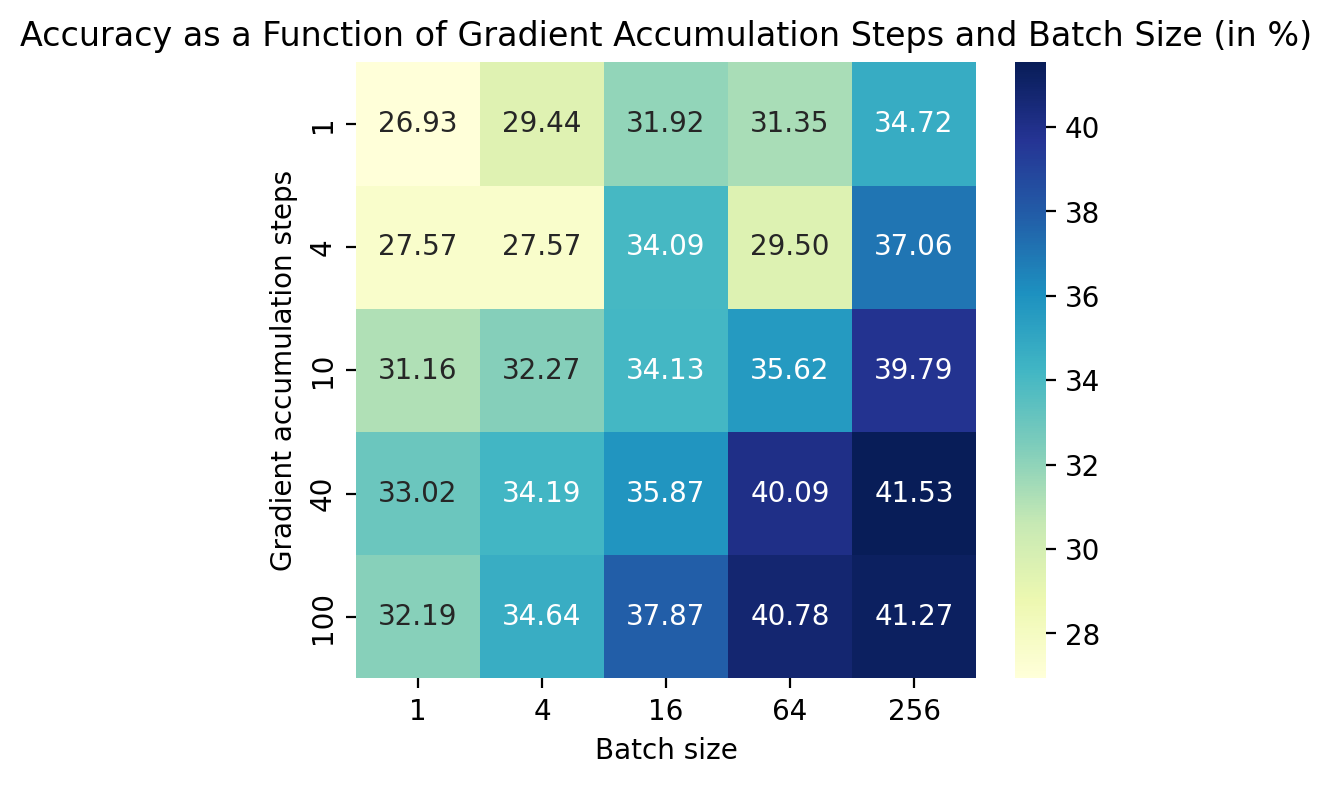

In [35]:
plot_heatmap(accuracies, 'gradient_accumulation_steps', 'batch_size')

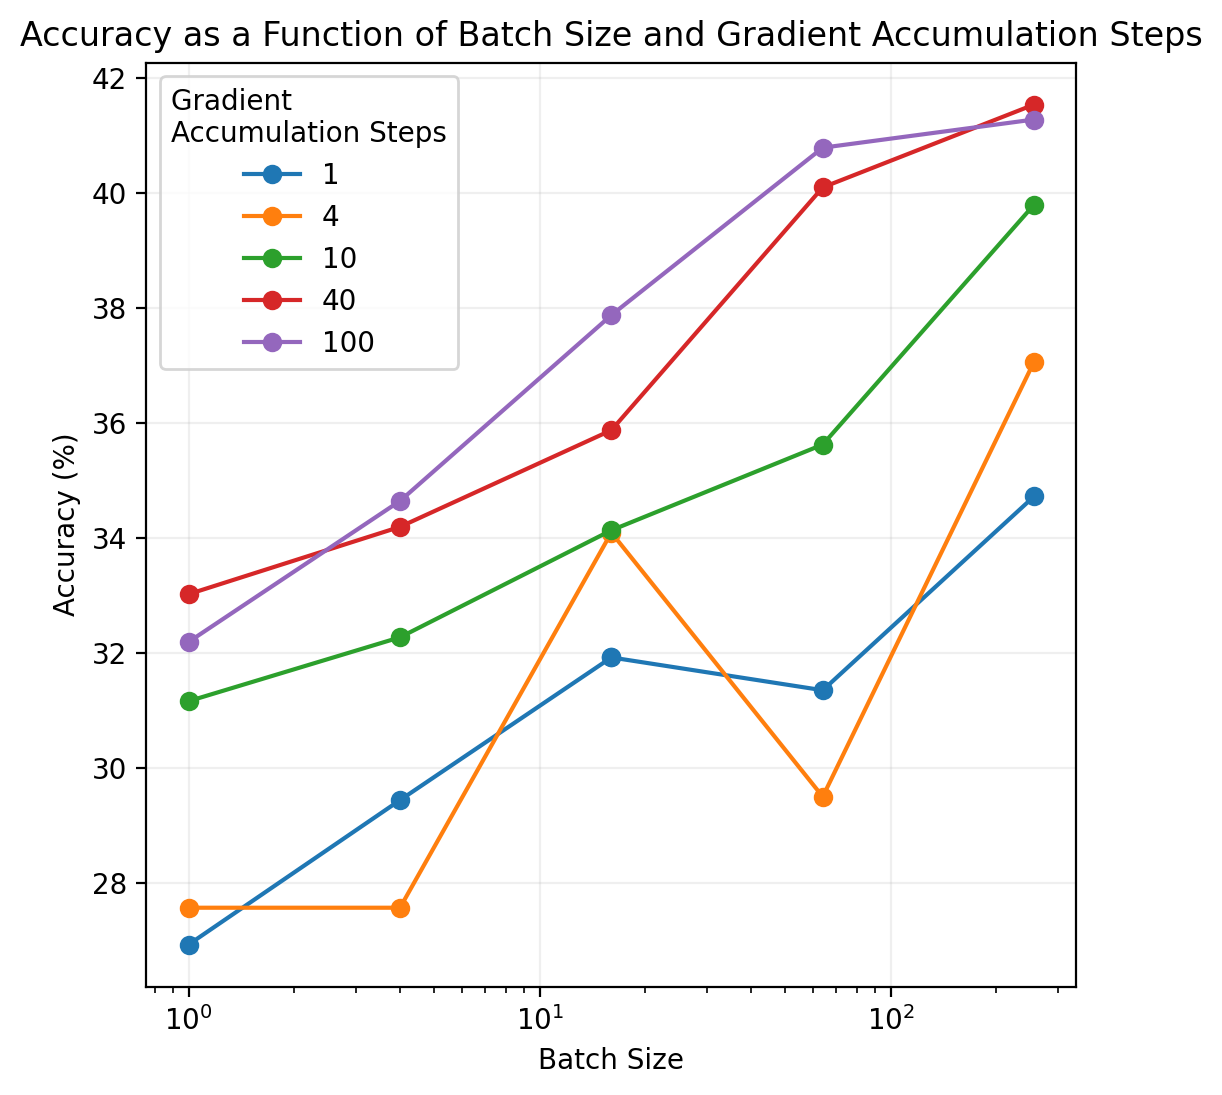

In [38]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'batch_size' and 'gradient_accumulation_steps' to ensure correct plotting order
accuracies_sorted = accuracies.sort_values(by=['batch_size', 'gradient_accumulation_steps'])

# Extract and sort unique values of gradient_accumulation_steps
gradient_accumulation_steps_values = sorted(accuracies_sorted['gradient_accumulation_steps'].unique())

plt.figure(figsize=(6, 6))

# Plot for each gradient_accumulation_steps value
for grad_accum_steps in gradient_accumulation_steps_values:
    subset = accuracies_sorted[accuracies_sorted['gradient_accumulation_steps'] == grad_accum_steps]
    plt.plot(subset['batch_size'], subset['Accuracy'], marker='o', label=f'{grad_accum_steps}')

plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Batch Size and Gradient Accumulation Steps')
plt.legend(title='Gradient \nAccumulation Steps')
plt.grid(True, alpha=0.2)
plt.show()


### 3d plot

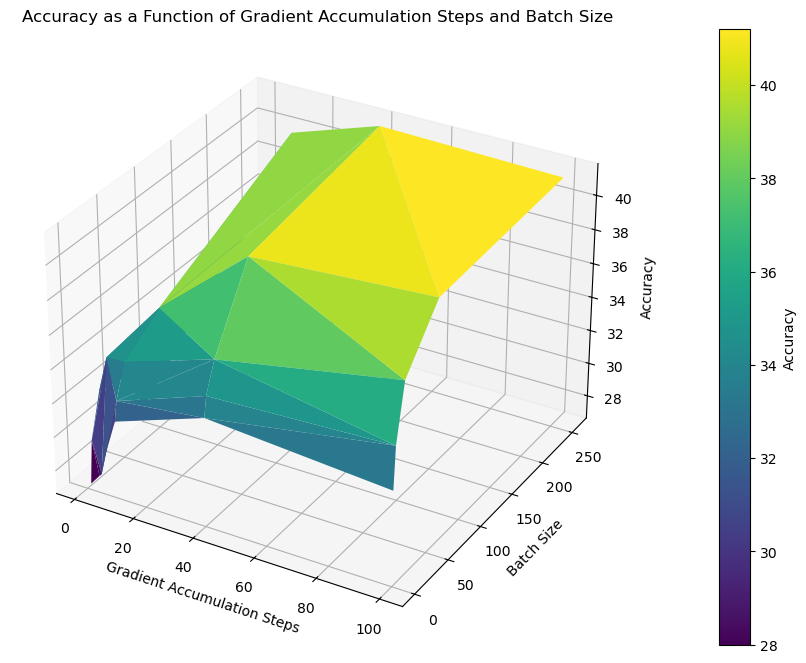

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Assuming accuracies is your DataFrame after merging

# Extract the columns needed for the 3D plot
x = accuracies['Gradient Accumulation Steps']
y = accuracies['Batch Size']
z = accuracies['Accuracy']

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

# Add labels
ax.set_title('Accuracy as a Function of Gradient Accumulation Steps and Batch Size')
ax.set_xlabel('Gradient Accumulation Steps')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Accuracy')

# Add color bar which maps values to colors
color_bar = fig.colorbar(surf, ax=ax, pad=0.1)
color_bar.set_label('Accuracy')

# Show the plot
plt.show()


## model size

In [5]:
accuracies=extract_accuracies('U')
parameters_list = ['n_layer', 'n_head', 'n_embd']
parameters_df = extract_parameters(parameters_list, 'U')
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['n_layer'] = accuracies['n_layer'].astype(int)
accuracies['n_head'] = accuracies['n_head'].astype(int)
accuracies['n_embd'] = accuracies['n_embd'].astype(int)
accuracies['n_parameters']=accuracies['n_layer']* accuracies['n_head']*accuracies['n_embd']
#accuracies.sort_values(by='Accuracy', ascending=False).head()

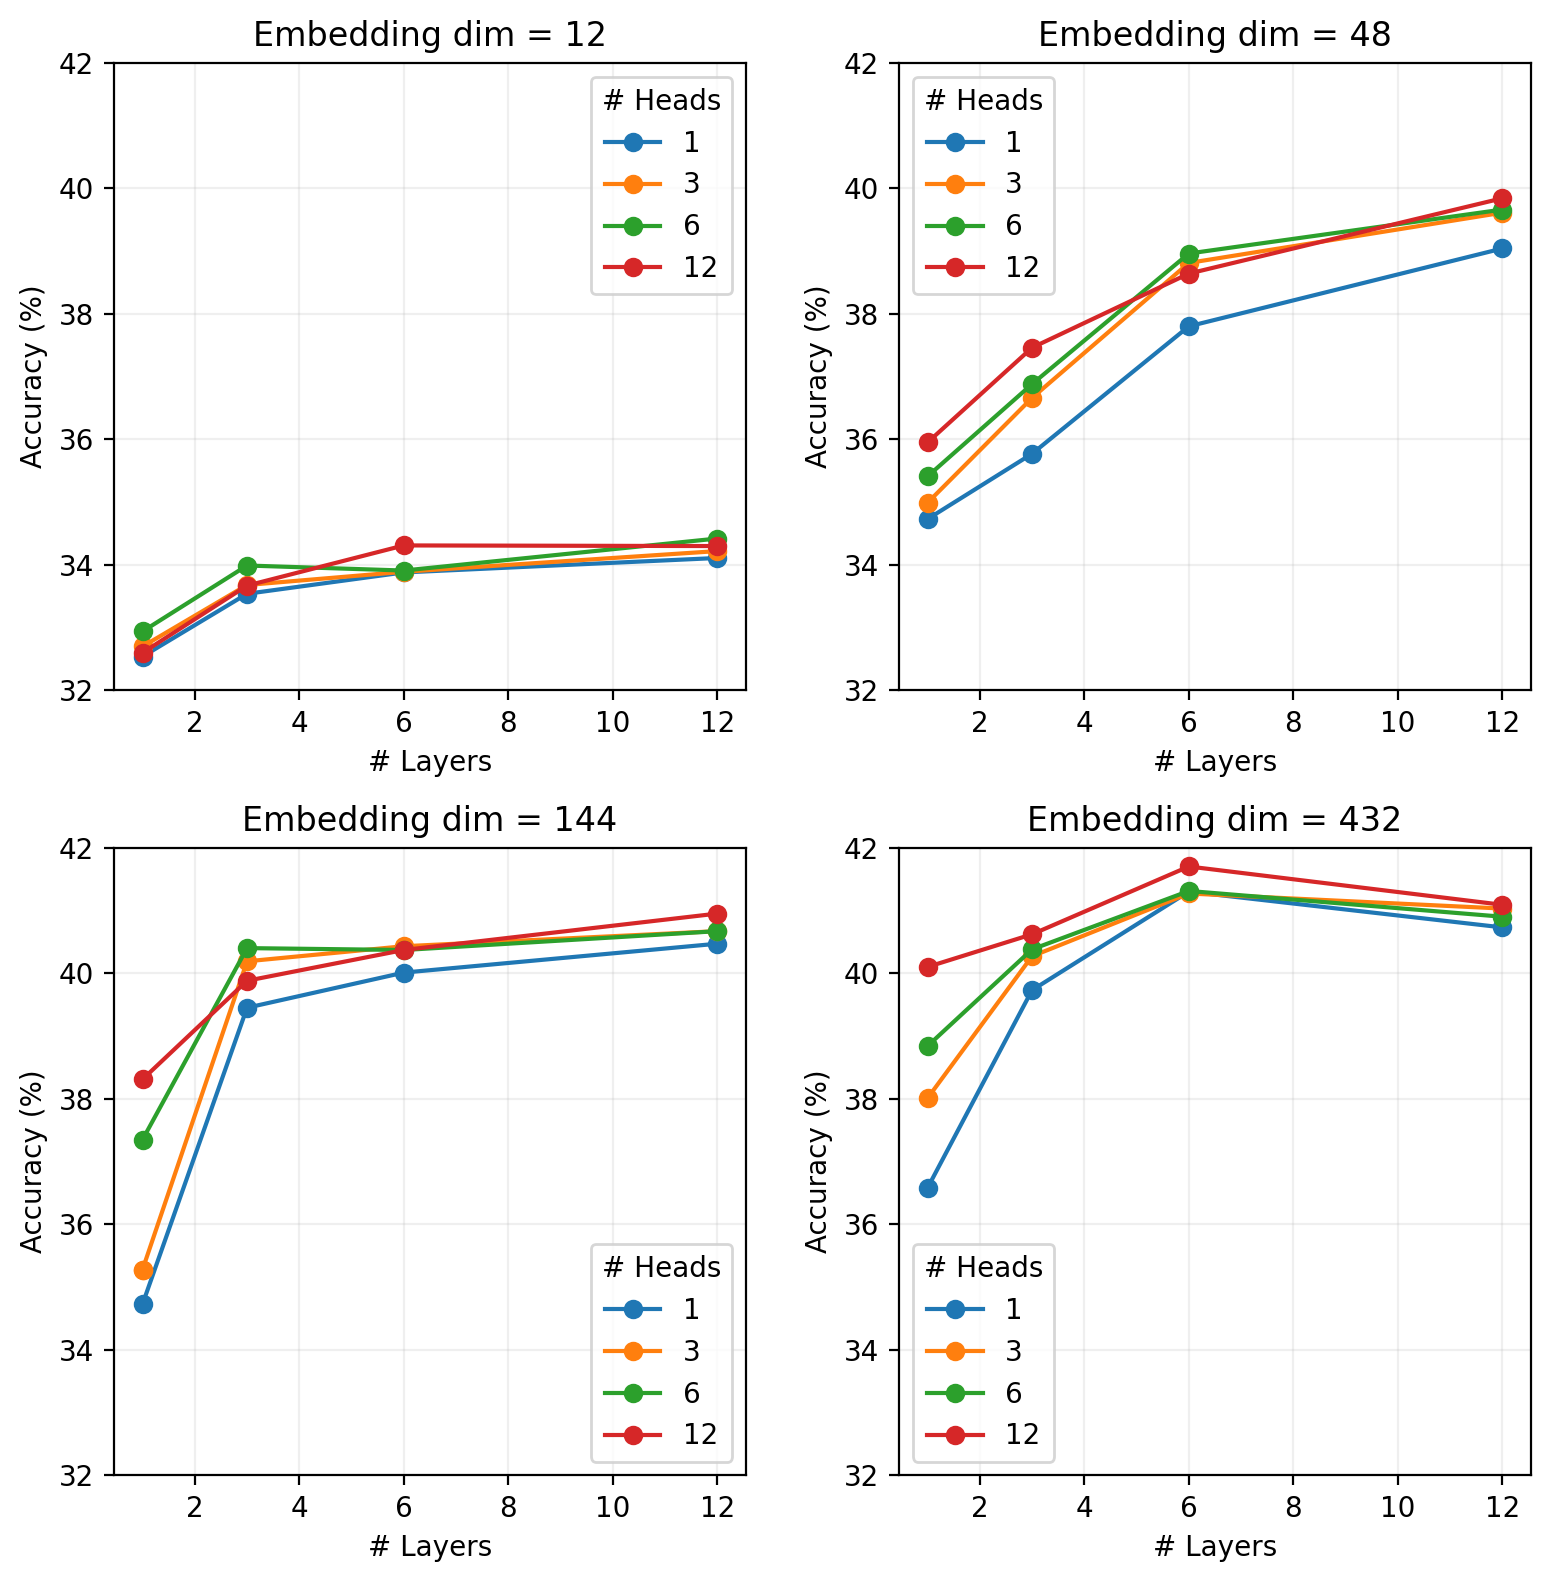

In [13]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'n_embd', 'n_layer', and 'n_head' to ensure correct plotting order
accuracies_sorted = accuracies.sort_values(by=['n_embd', 'n_layer', 'n_head'])

# Extract unique values of n_embd and n_head
n_embd_values = accuracies_sorted['n_embd'].unique()
n_head_values = accuracies_sorted['n_head'].unique()

# Determine the global y-axis limits (min and max of Accuracy)
y_min = 32# accuracies_sorted['Accuracy'].min()
y_max = 42 #accuracies_sorted['Accuracy'].max()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot for each n_embd value in its respective subplot
for i, n_embd in enumerate(n_embd_values[:4]):  # Limiting to first 4 n_embd values for a 2x2 grid
    ax = axes[i//2, i%2]  # Determine position in 2x2 grid
    for n_head in n_head_values:
        subset = accuracies_sorted[(accuracies_sorted['n_embd'] == n_embd) &
                                   (accuracies_sorted['n_head'] == n_head)]
        ax.plot(subset['n_layer'], subset['Accuracy'], marker='o', linestyle='-', label=f'{n_head}')
    ax.set_ylim(y_min, y_max)  # Set the same y-axis limits for all subplots
    ax.set_title(f'Embedding dim = {n_embd}')
    ax.set_xlabel('# Layers')
    ax.set_ylabel('Accuracy (%)')
    ax.grid(True, alpha=0.2)
    ax.legend(title='# Heads')
plt.tight_layout()
plt.show()

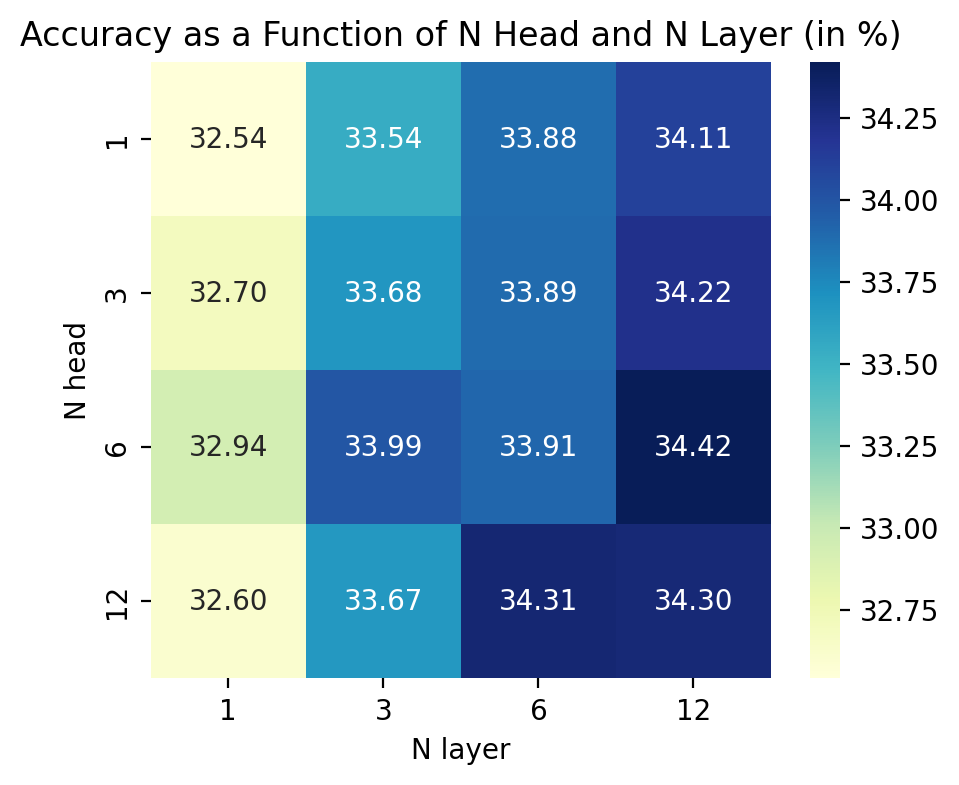

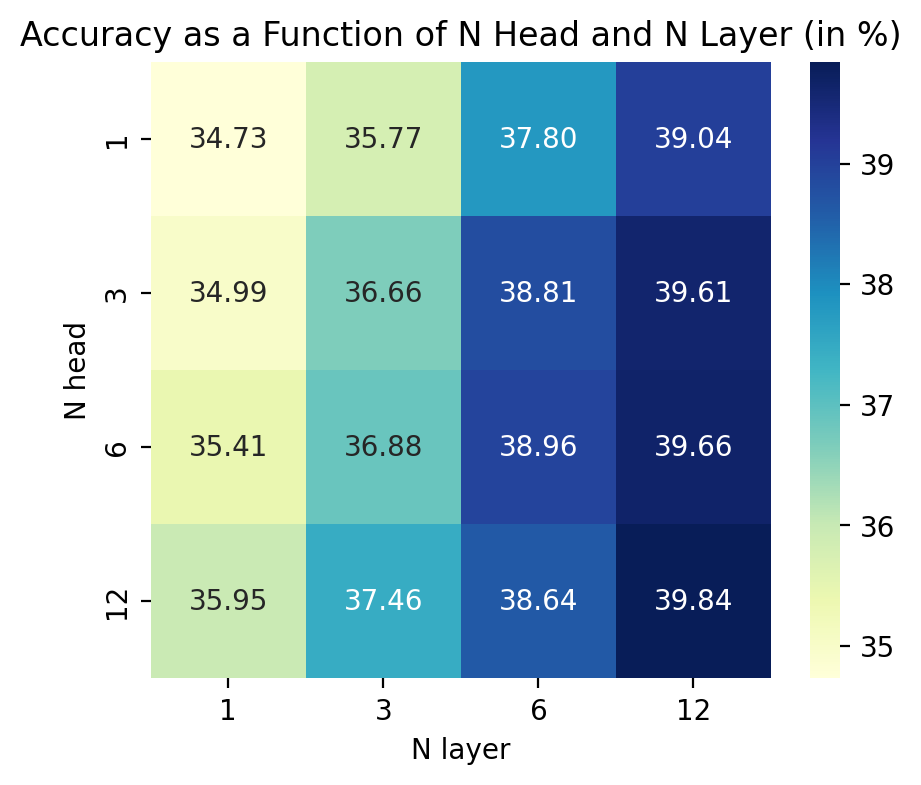

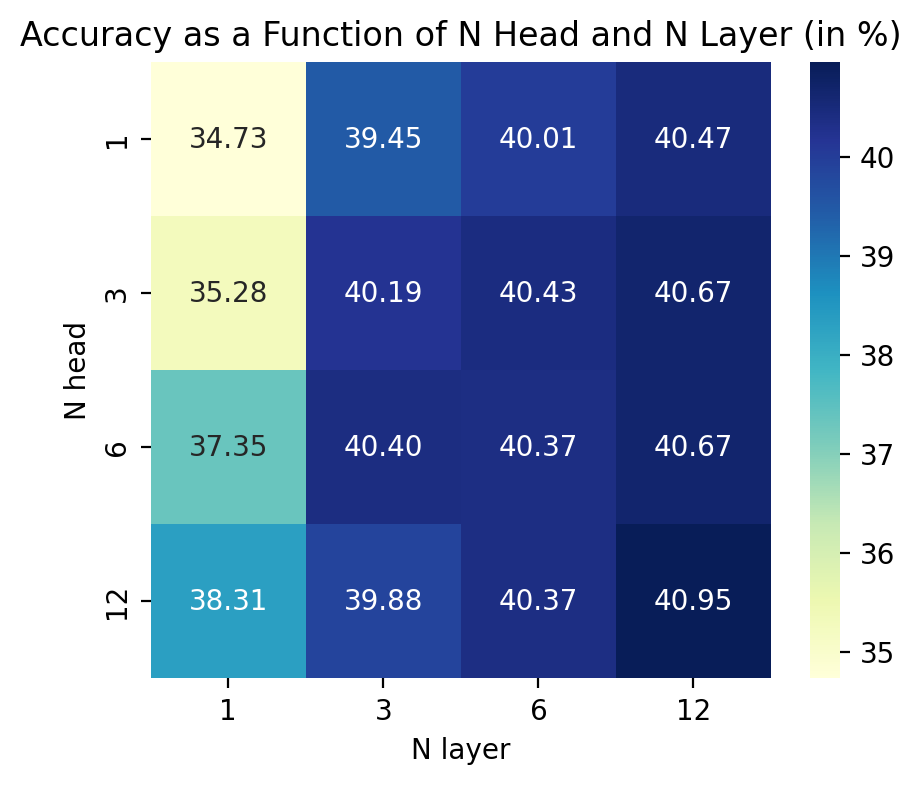

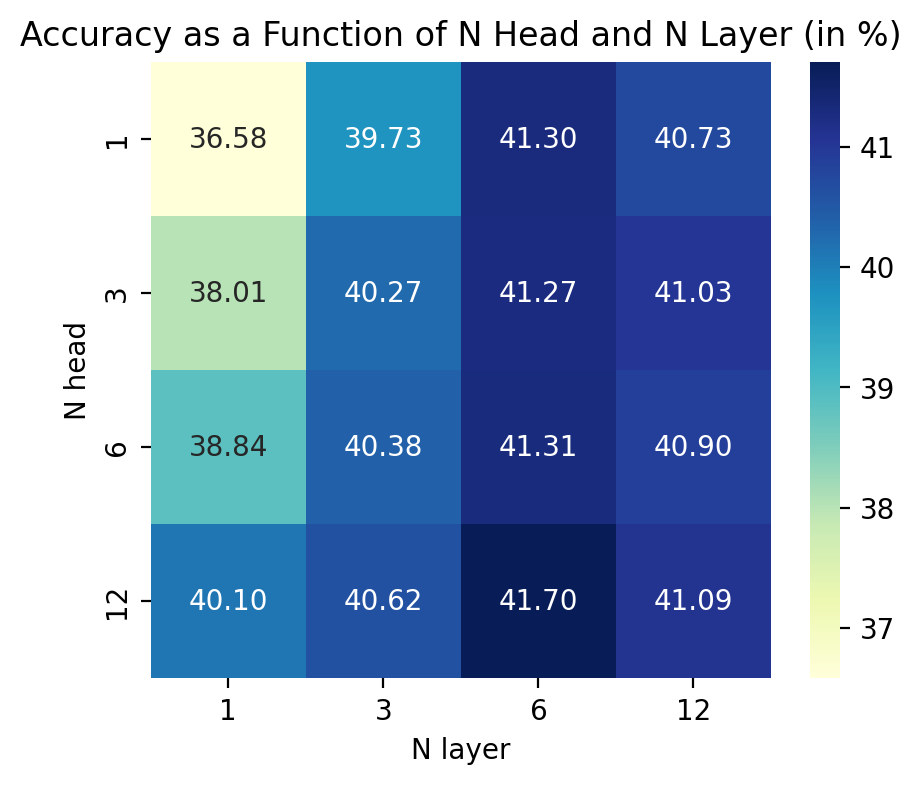

In [7]:
plot_heatmap(accuracies[accuracies['n_embd']==12], 'n_head', 'n_layer')
plot_heatmap(accuracies[accuracies['n_embd']==48], 'n_head', 'n_layer')
plot_heatmap(accuracies[accuracies['n_embd']==144], 'n_head', 'n_layer')
plot_heatmap(accuracies[accuracies['n_embd']==432], 'n_head', 'n_layer')

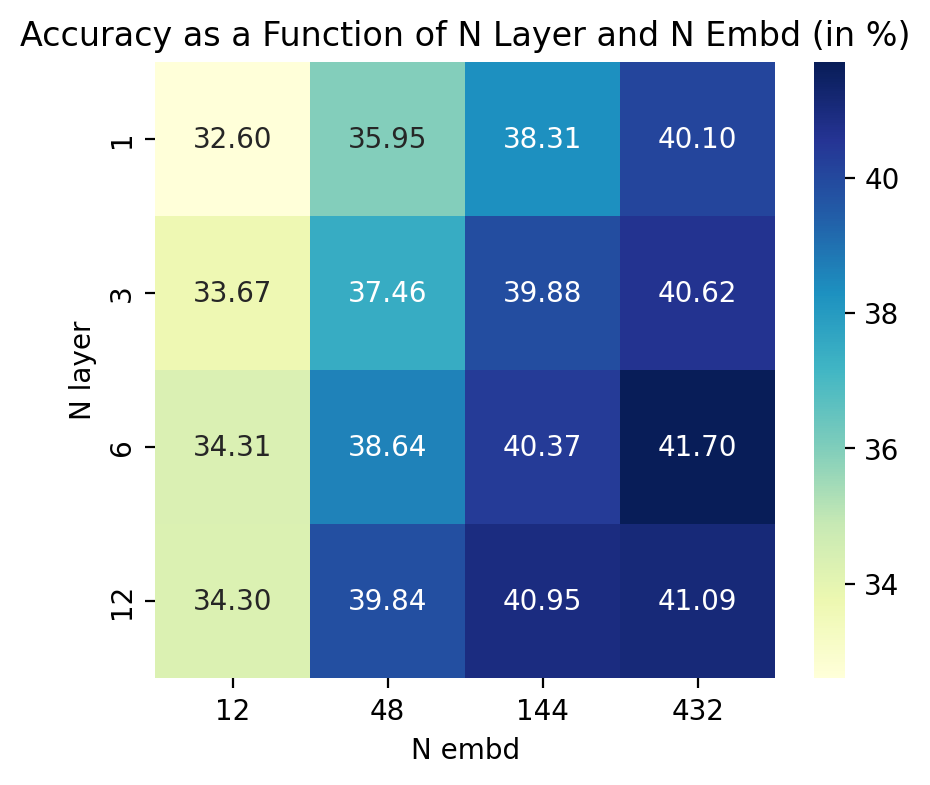

In [25]:
plot_heatmap(accuracies[accuracies['n_head']==12], 'n_layer', 'n_embd')

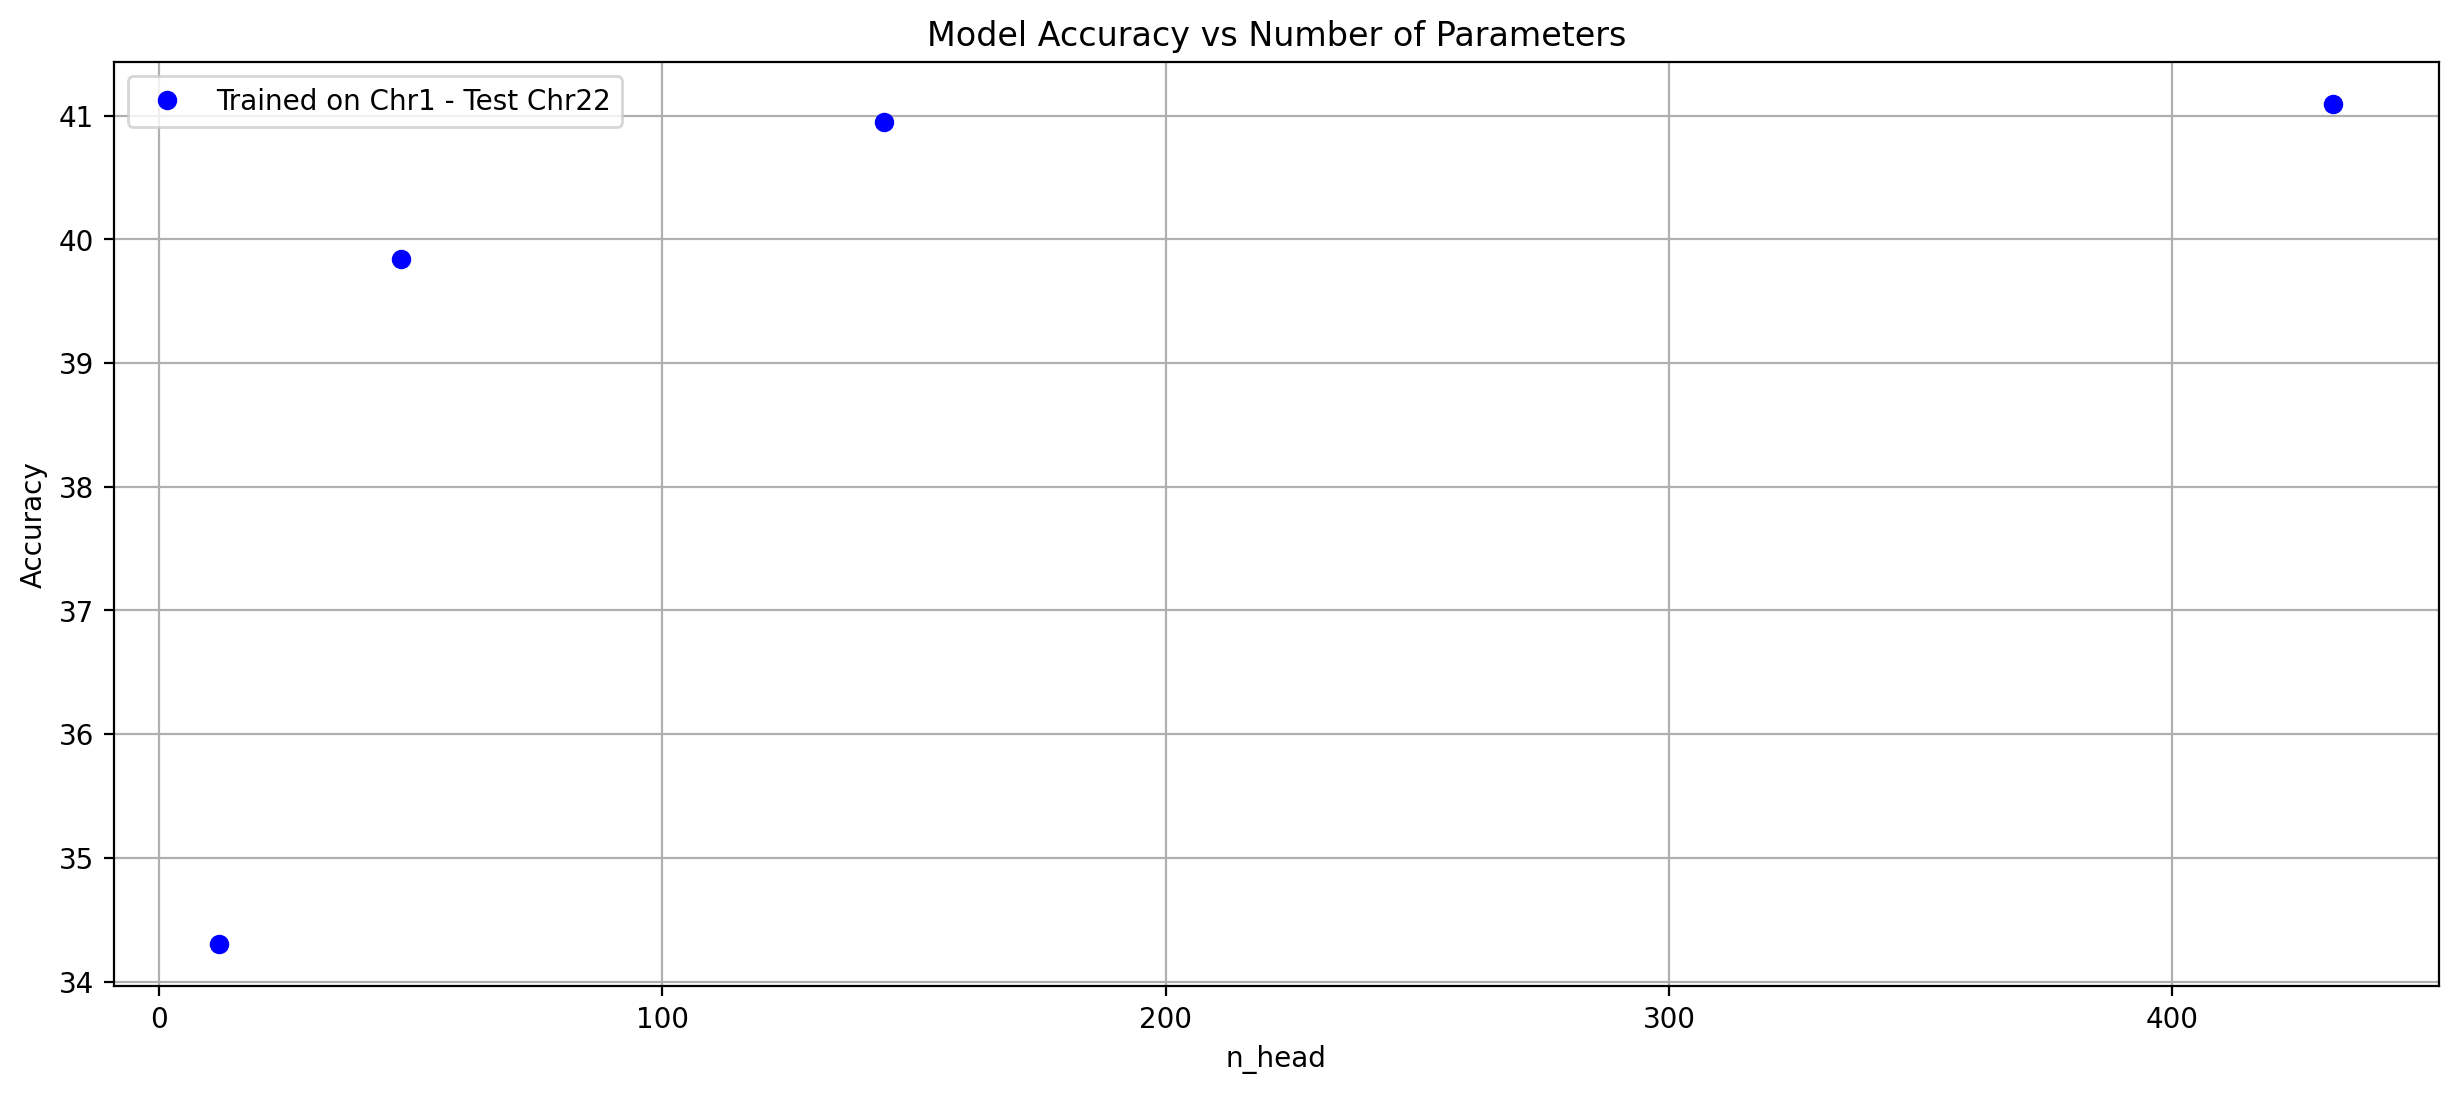

In [32]:
plt.figure(figsize=(15, 6))  # Increase figure size for better readability

# Corrected logical condition for filtering
plt.plot(
    accuracies[(accuracies['n_layer'] == 12) & (accuracies['n_head'] == 12)]['n_embd'], 
    accuracies[(accuracies['n_layer'] == 12) & (accuracies['n_head'] == 12)]['Accuracy'], 
    marker='o', 
    label='Trained on Chr1 - Test Chr22', 
    color='blue', 
    linestyle='', 
    linewidth=2
)

plt.xlabel('n_head')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of Parameters')
plt.legend()
plt.grid(True)
plt.show()


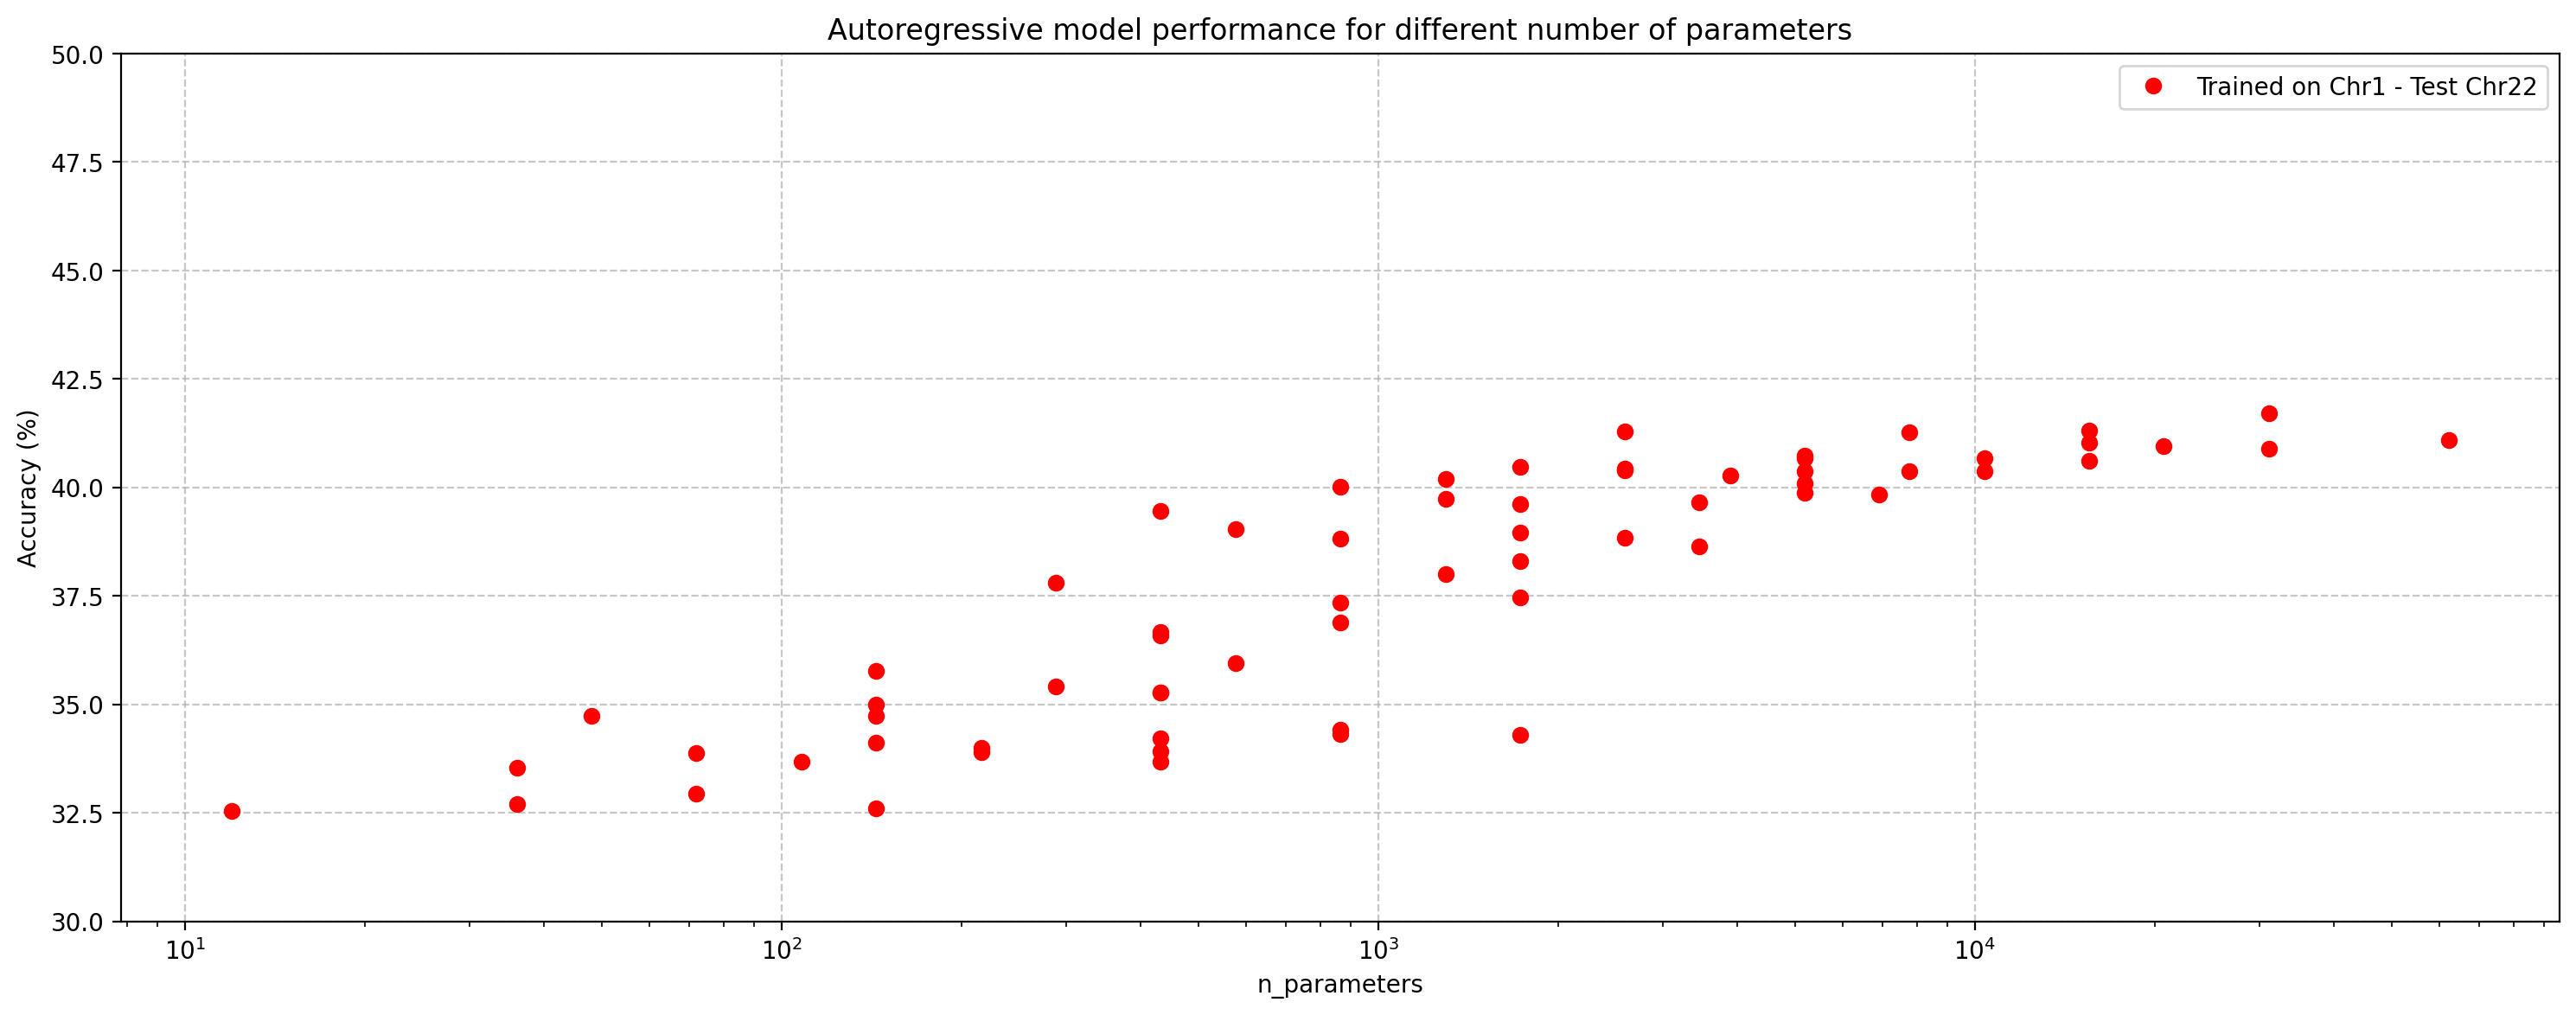

In [25]:
plt.figure(figsize=(15, 6))  # Increase figure size for better readability

plt.plot(accuracies['n_parameters'], accuracies['Accuracy'], marker='o', label='Trained on Chr1 - Test Chr22', color='red', linestyle='', linewidth=2)
#plt.plot(accuracies[accuracies['n_layer']==12]['n_parameters'], accuracies[accuracies['n_layer']==12]['Accuracy'], marker='o', label='Trained on Chr1 - Test Chr22', color='blue', linestyle='', linewidth=2)
#plt.plot(accuracies['n_parameters'], accuracies['Accuracy'], marker='o', label='Trained on Chr1 - Test Chr2', color='orange', linestyle='-', linewidth=2)

plt.xlabel('n_parameters')
plt.ylabel('Accuracy (%)')
plt.title('Autoregressive model performance for different number of parameters')
#plt.ylim(20, 65)
plt.ylim(30, 50)
plt.xscale('log')

# Ensure xticks are well positioned and clear
#plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])

#plt.axhline(y=29, color='green', linestyle='--', label='Guessing Purine')

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()


## Dropout and bias

In [21]:
accuracies=extract_accuracies('V')
parameters_list = ['dropout', 'bias']
parameters_df = extract_parameters(parameters_list,'V')
parameters_df['dropout'] = parameters_df['dropout'].astype(float)
parameters_df['bias'] = parameters_df['bias'].map({'True': True, 'False': False})
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies.sort_values(by='Accuracy', ascending=False)
accuracies.head()

Letter  Accuracy        n Eval data  dropout   bias
0     02     41.59  20000.0  test_set      0.0  False
1     11     40.57  20000.0  test_set      0.5   True
2     11     40.57  20000.0  test_set      0.5   True
3     12     40.76  20000.0  test_set      0.5  False
4     03     41.25  20000.0  test_set      0.1   True

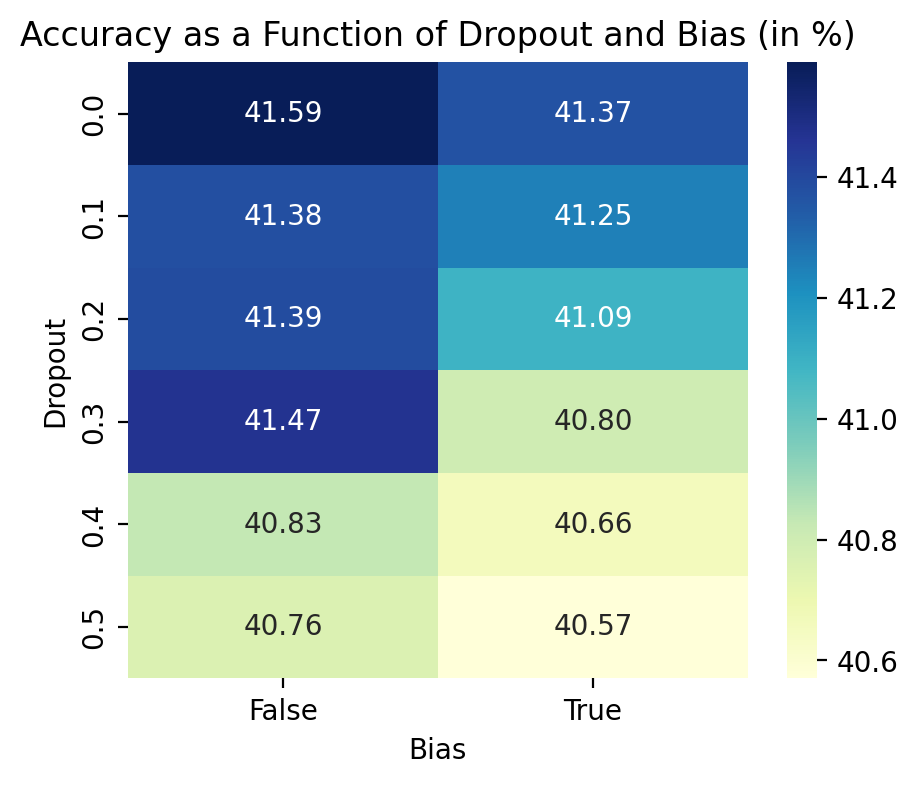

In [22]:
plot_heatmap(accuracies, 'dropout', 'bias')

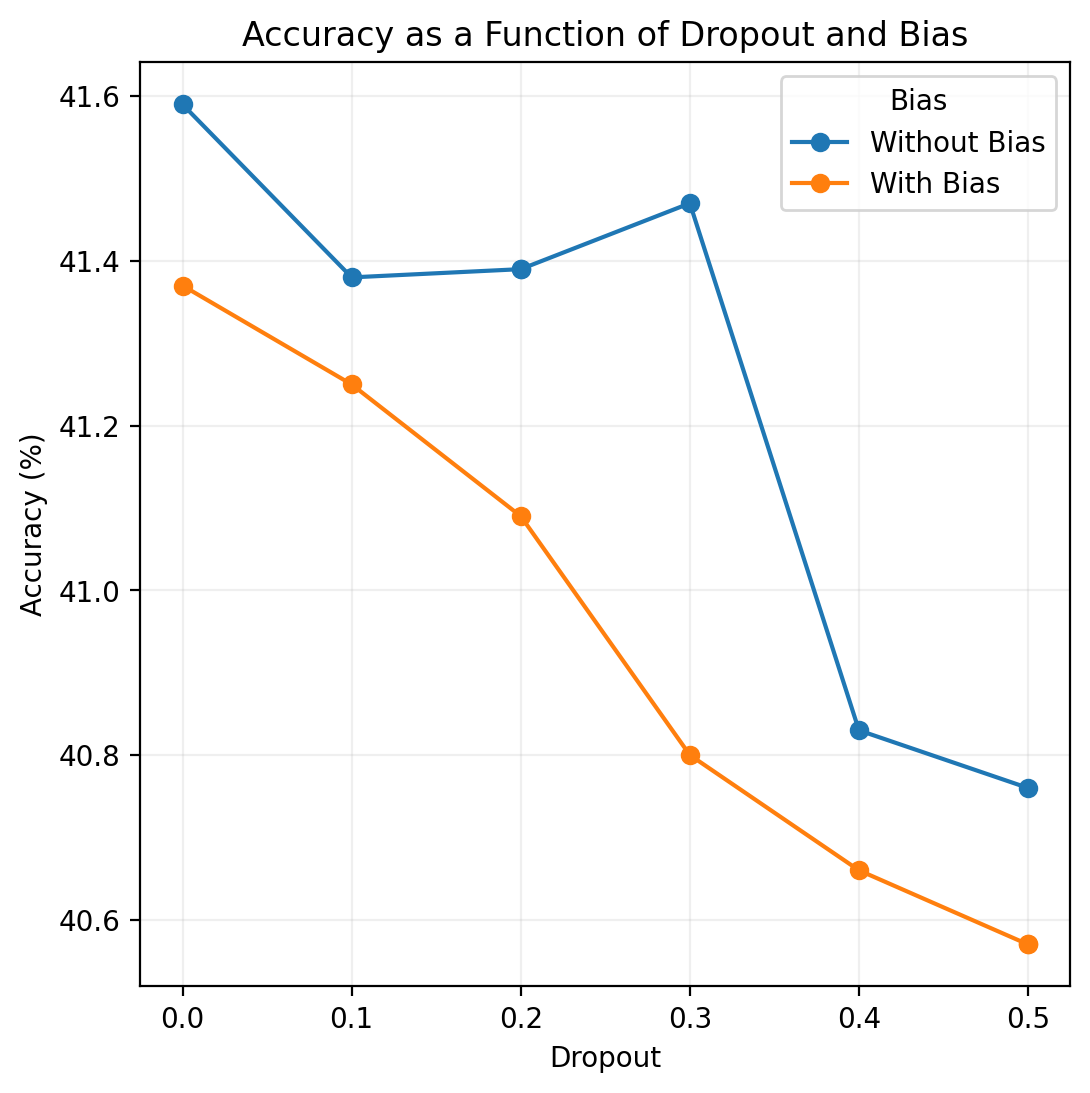

In [23]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'dropout' and 'bias' to ensure correct plotting order
accuracies = accuracies.sort_values(by=['dropout', 'bias'])

# Extract unique values of dropout and bias
dropout_values = accuracies['dropout'].unique()
bias_values = accuracies['bias'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each bias value
for bias in bias_values:
    subset = accuracies[accuracies['bias'] == bias]
    plt.plot(subset['dropout'], subset['Accuracy'], marker='o', label= 'With Bias' if bias else 'Without Bias')

plt.xlabel('Dropout')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Dropout and Bias')
plt.legend(title='Bias')
plt.grid(True, alpha=0.2)
plt.show()


## Learning 

In [24]:
accuracies=extract_accuracies('W')
parameters_list = ['decay_lr', 'warmup_iters', 'learning_rate']
parameters_df = extract_parameters(parameters_list,'W')
parameters_df['warmup_iters'] = parameters_df['warmup_iters'].astype(int)
parameters_df['learning_rate'] = parameters_df['learning_rate'].astype(float)
parameters_df['decay_lr'] = parameters_df['decay_lr'].map({'True': True, 'False': False})
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
#accuracies.sort_values(by='Accuracy', ascending=False)
#accuracies.head()

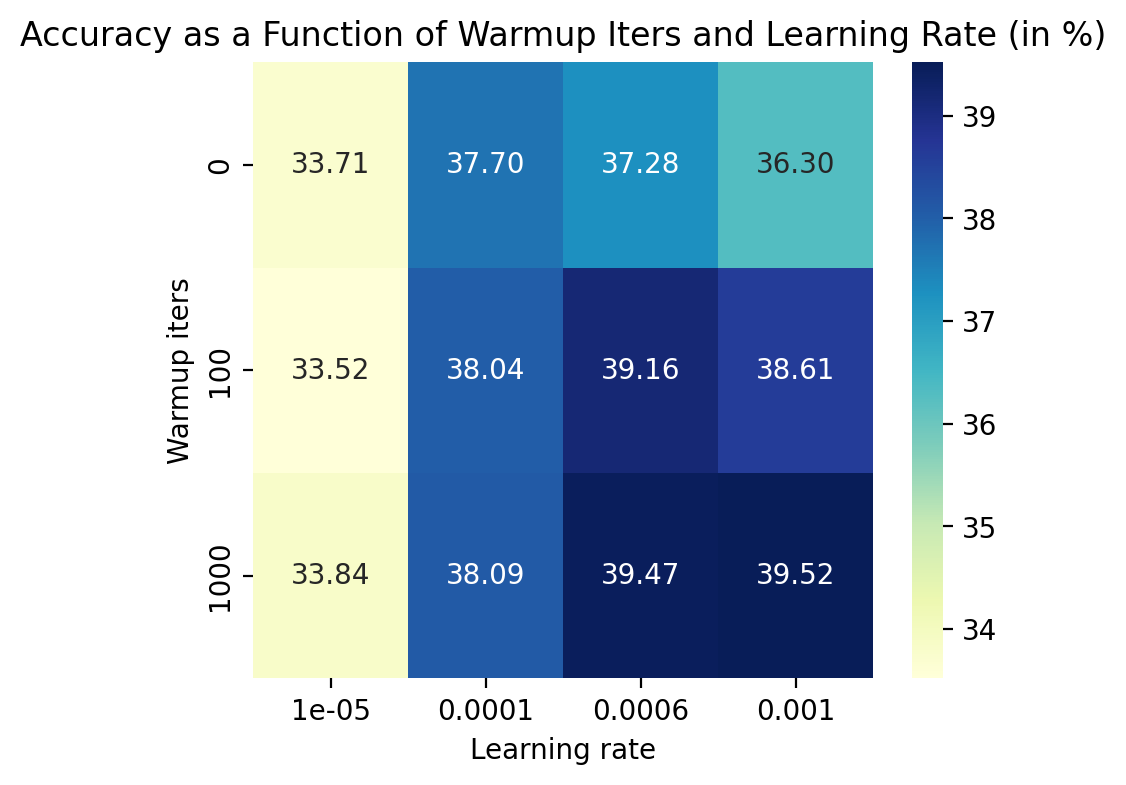

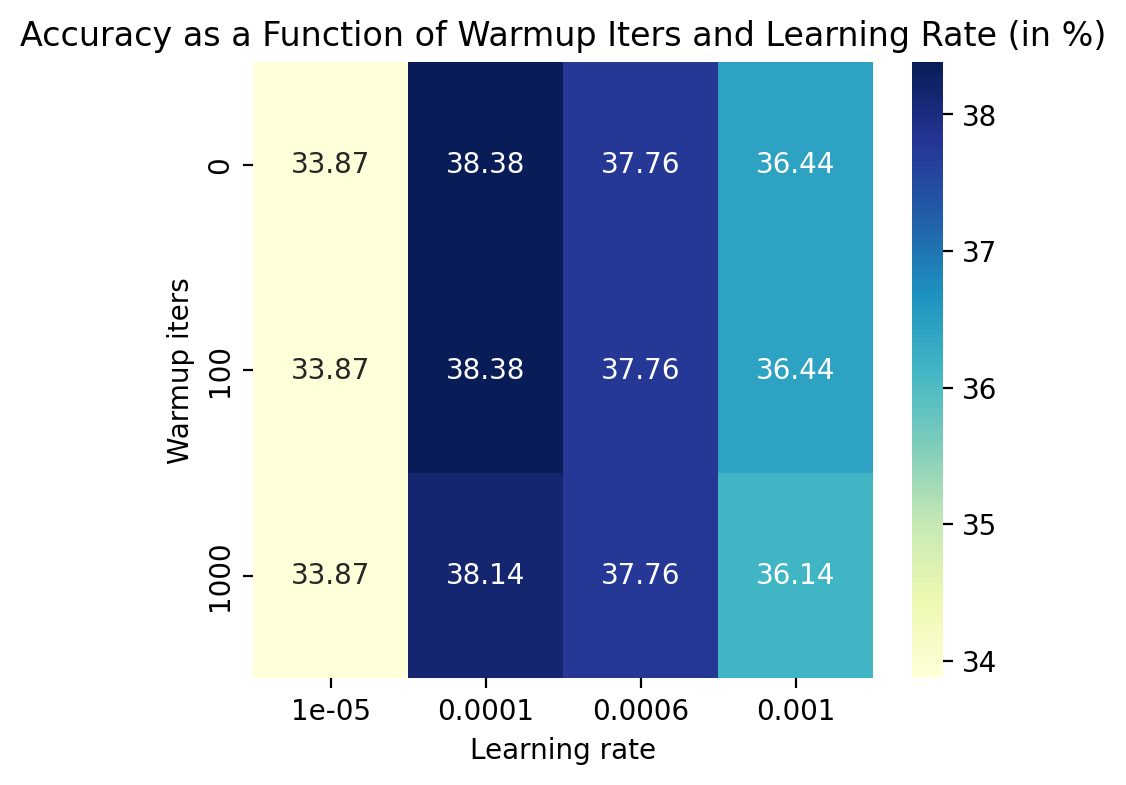

In [25]:
plot_heatmap(accuracies[accuracies['decay_lr']==True], 'warmup_iters', 'learning_rate')
plot_heatmap(accuracies[accuracies['decay_lr']==False], 'warmup_iters', 'learning_rate')

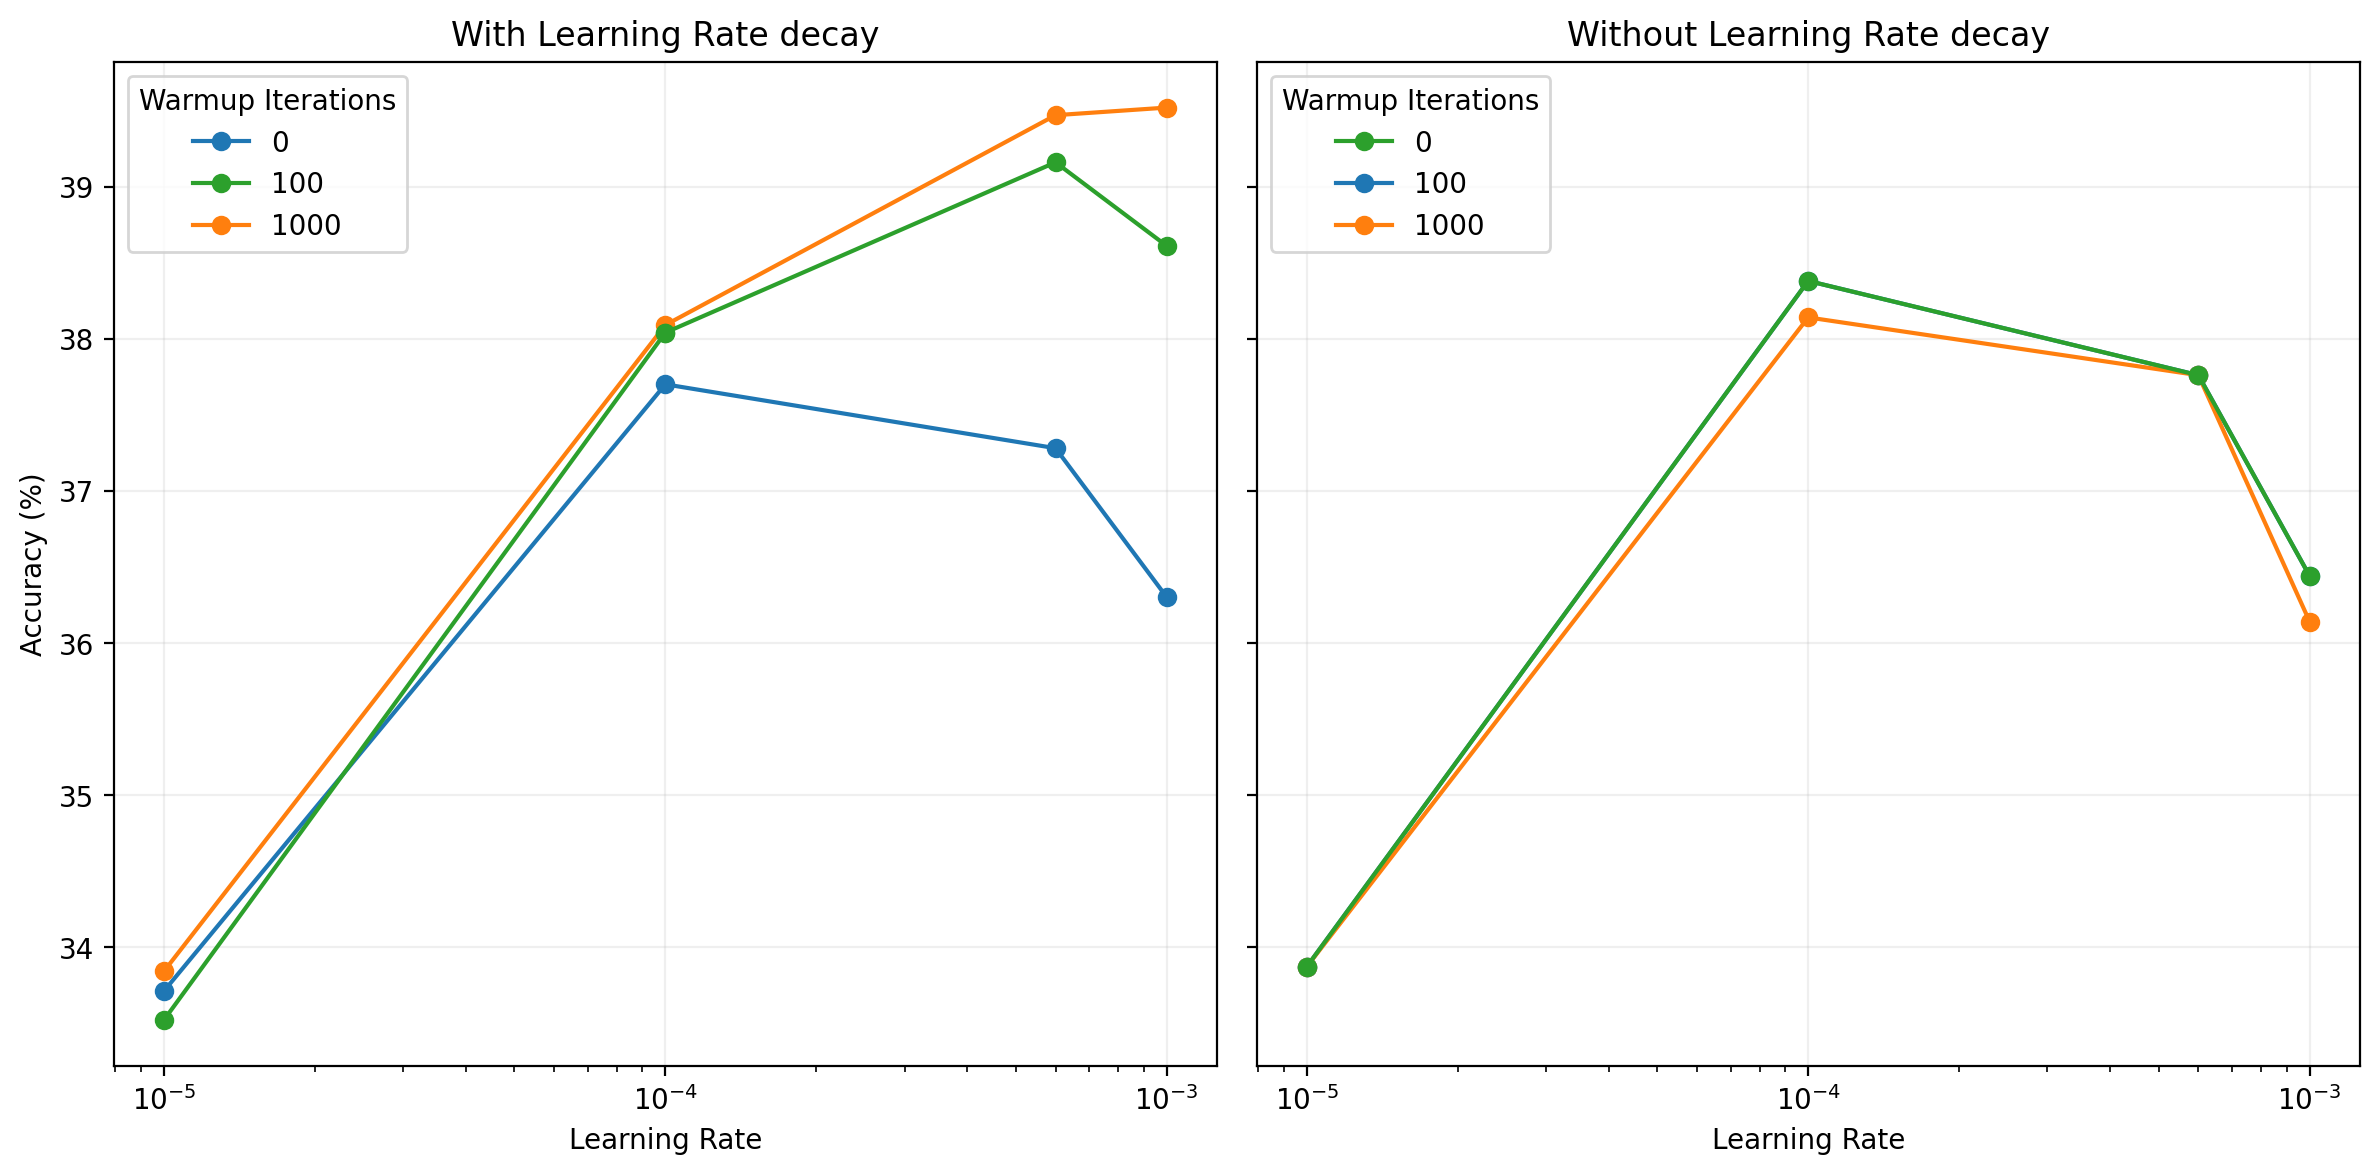

In [31]:
import matplotlib.pyplot as plt

# Filter data based on 'decay_lr' being True and False
decay_lr_true = accuracies[accuracies['decay_lr'] == True].sort_values(by='learning_rate')
decay_lr_false = accuracies[accuracies['decay_lr'] == False].sort_values(by='learning_rate')

# Extract unique values
warmup_iters_true = decay_lr_true['warmup_iters'].unique()
warmup_iters_false = decay_lr_false['warmup_iters'].unique()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for decay_lr == True
lines_labels_true = []
for warmup_iters in warmup_iters_true[:3]:  # Limiting to 3 lines
    subset = decay_lr_true[decay_lr_true['warmup_iters'] == warmup_iters]
    line, = axes[0].plot(subset['learning_rate'], subset['Accuracy'], marker='o', label=f'{warmup_iters}')
    lines_labels_true.append((warmup_iters, line))

# Sort lines and labels by warmup iterations
lines_labels_true.sort()

# Extract sorted lines and labels
sorted_lines_true = [line for _, line in lines_labels_true]
sorted_labels_true = [f'{warmup_iters}' for warmup_iters, _ in lines_labels_true]

axes[0].set_title('With Learning Rate decay')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_xscale('log')  # Set x-axis to log scale
axes[0].legend(sorted_lines_true, sorted_labels_true, title='Warmup Iterations', loc='upper left')
axes[0].grid(True, alpha=0.2)

# Plot for decay_lr == False
lines_labels_false = []
for warmup_iters in warmup_iters_false[:3]:  # Limiting to 3 lines
    subset = decay_lr_false[decay_lr_false['warmup_iters'] == warmup_iters]
    line, = axes[1].plot(subset['learning_rate'], subset['Accuracy'], marker='o', label=f'{warmup_iters}')
    lines_labels_false.append((warmup_iters, line))

# Sort lines and labels by warmup iterations
lines_labels_false.sort()

# Extract sorted lines and labels
sorted_lines_false = [line for _, line in lines_labels_false]
sorted_labels_false = [f'{warmup_iters}' for warmup_iters, _ in lines_labels_false]

axes[1].set_title('Without Learning Rate decay')
axes[1].set_xlabel('Learning Rate')
axes[1].set_xscale('log')  # Set x-axis to log scale
axes[1].legend(sorted_lines_false, sorted_labels_false, title='Warmup Iterations', loc='upper left')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


## Optimiser

In [39]:
accuracies=extract_accuracies('X')
parameters_list = ['weight_decay', 'grad_clip']
parameters_df = extract_parameters(parameters_list, 'X')
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['weight_decay'] = accuracies['weight_decay'].astype(float)
accuracies['grad_clip'] = accuracies['grad_clip'].astype(float)
#accuracies.sort_values(by='Accuracy', ascending=False).head()

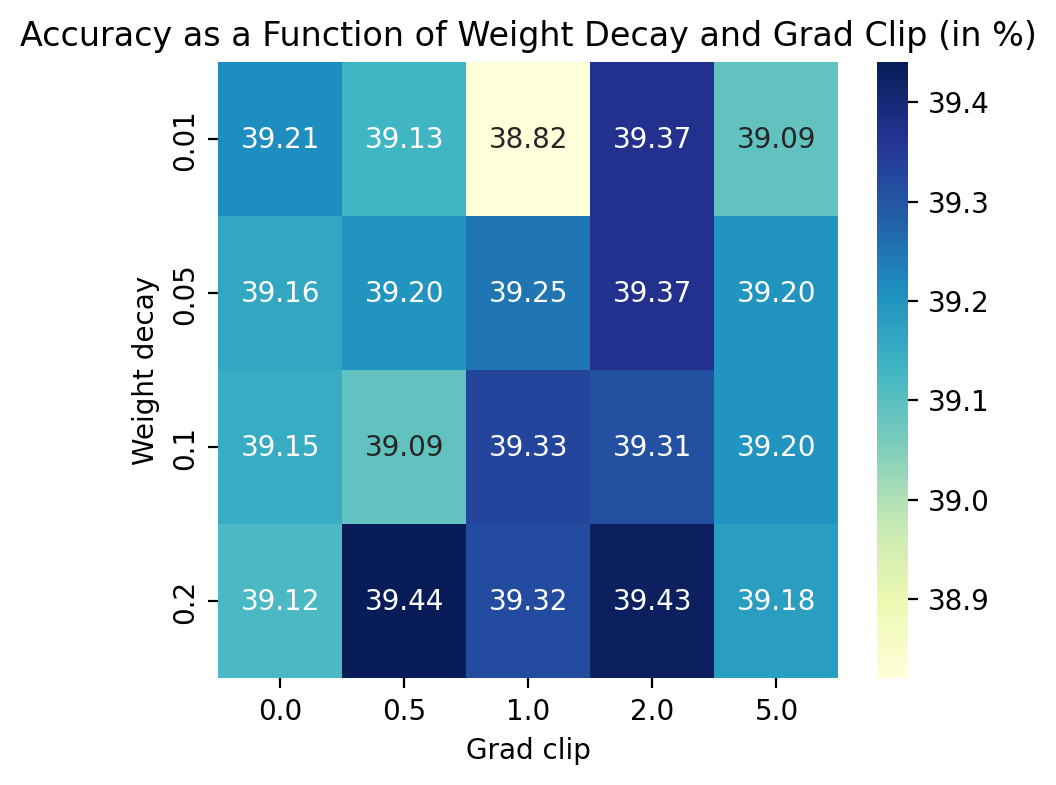

In [40]:
plot_heatmap(accuracies, 'weight_decay', 'grad_clip')

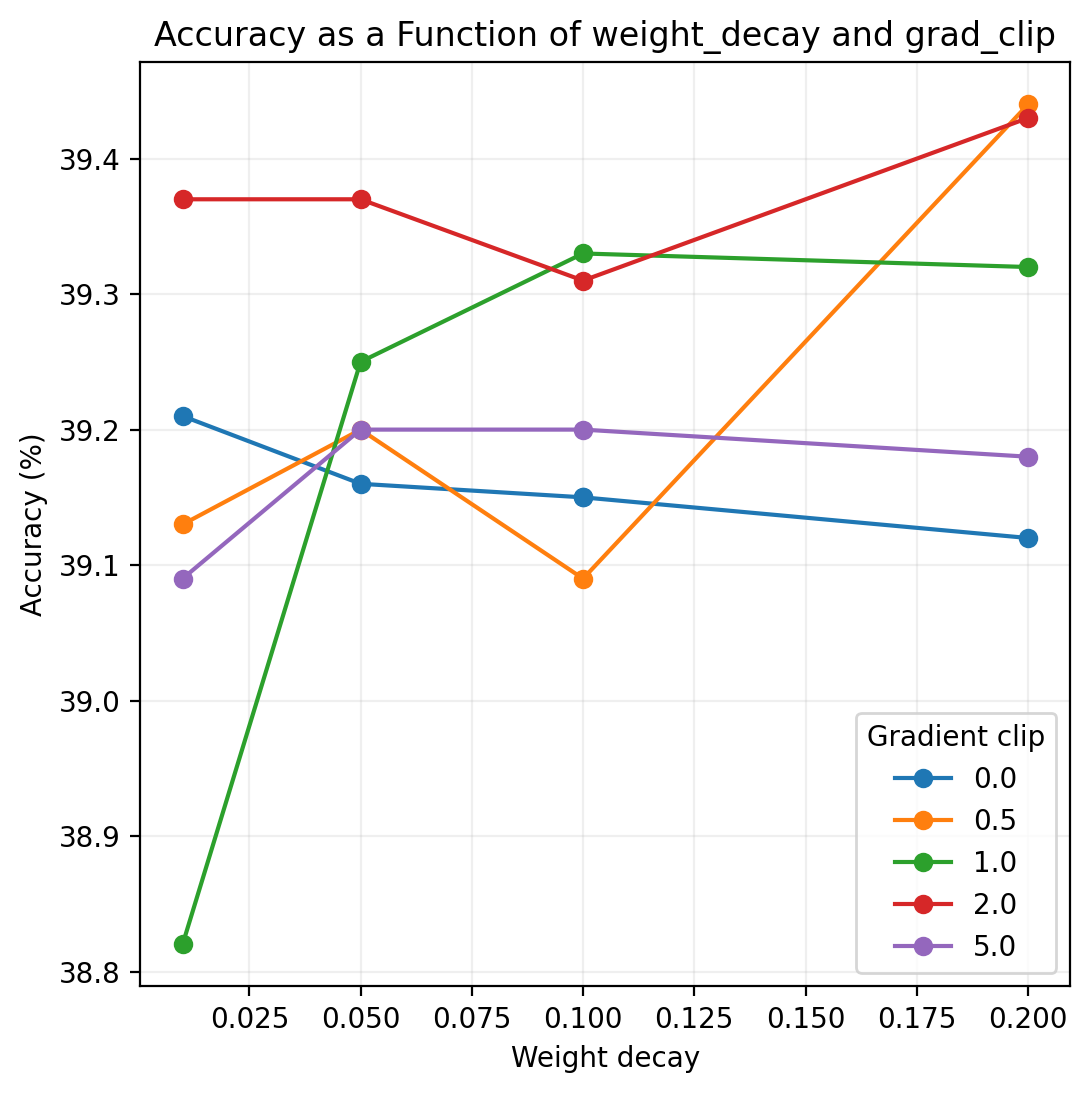

In [42]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'weight_decay' and 'grad_clip' to ensure correct plotting order
accuracies = accuracies.sort_values(by=['weight_decay', 'grad_clip'])

# Extract unique values of weight_decay and grad_clip
weight_decay_values = accuracies['weight_decay'].unique()
grad_clip_values = accuracies['grad_clip'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each grad_clip value
for grad_clip in grad_clip_values:
    subset = accuracies[accuracies['grad_clip'] == grad_clip]
    plt.plot(subset['weight_decay'], subset['Accuracy'], marker='o', label=f'{grad_clip}')

plt.xlabel('Weight decay')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of weight_decay and grad_clip')
plt.legend(title='Gradient clip')
plt.grid(True, alpha=0.2)
plt.show()


In [44]:
accuracies=extract_accuracies('Y')
parameters_list = ['beta1', 'beta2']
parameters_df = extract_parameters(parameters_list, 'Y')
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['beta1'] = accuracies['beta1'].astype(float)
accuracies['beta2'] = accuracies['beta2'].astype(float)
#accuracies.sort_values(by='Accuracy', ascending=False).head()

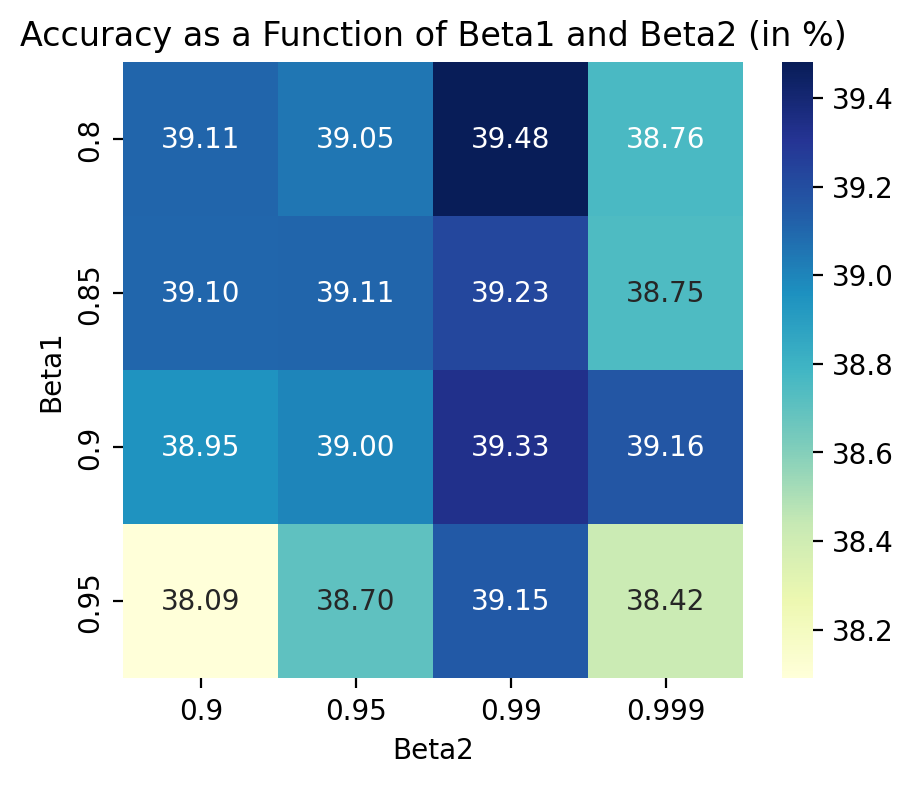

In [45]:
plot_heatmap(accuracies, 'beta1', 'beta2')

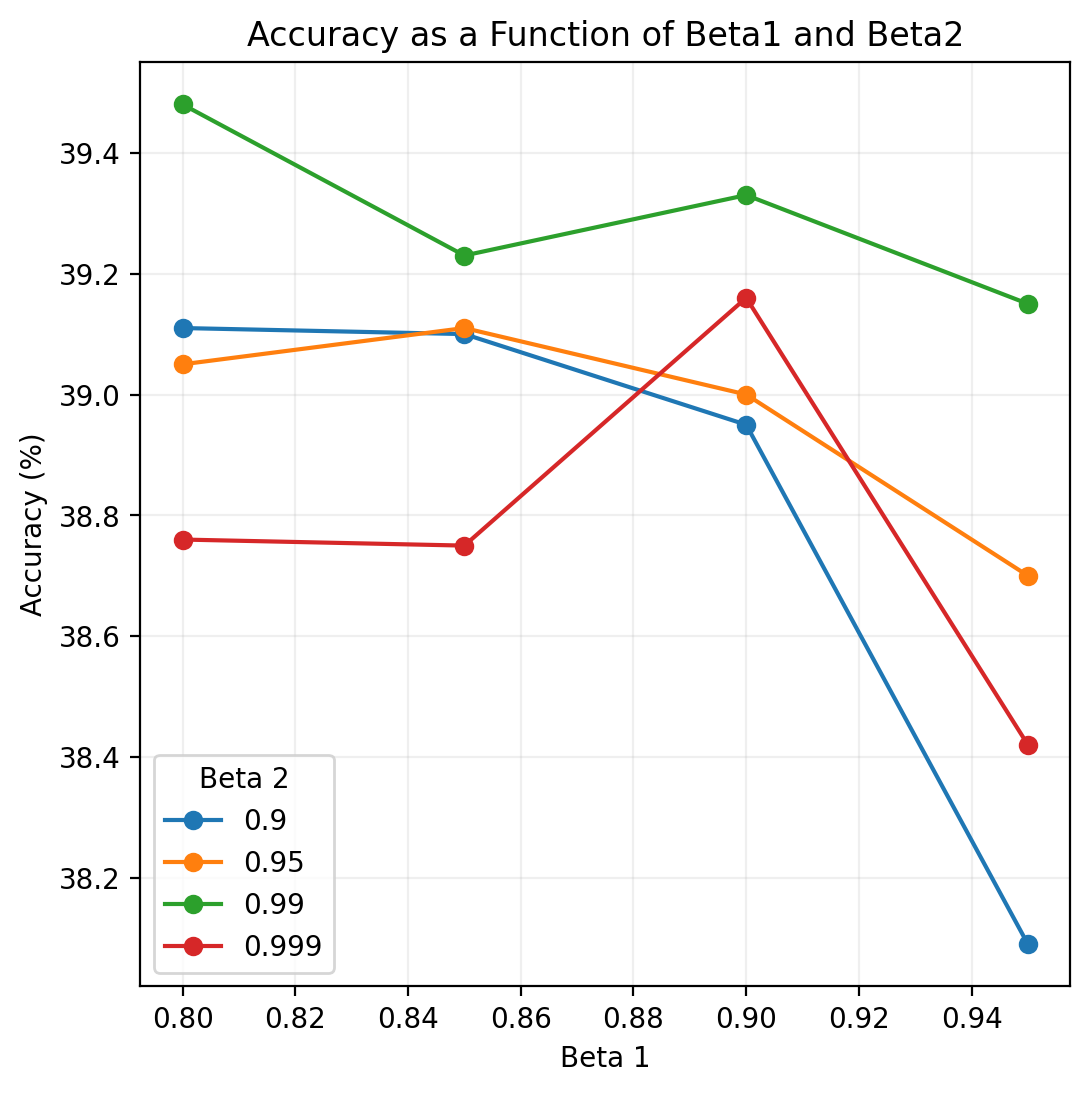

In [46]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'beta1' and 'beta2' to ensure correct plotting order
accuracies = accuracies.sort_values(by=['beta1', 'beta2'])

# Extract unique values of beta1 and beta2
beta1_values = accuracies['beta1'].unique()
beta2_values = accuracies['beta2'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each beta2 value
for beta2 in beta2_values:
    subset = accuracies[accuracies['beta2'] == beta2]
    plt.plot(subset['beta1'], subset['Accuracy'], marker='o', label=f'{beta2}')

plt.xlabel('Beta 1')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Beta1 and Beta2')
plt.legend(title='Beta 2')
plt.grid(True, alpha=0.2)
plt.show()


## final best valuess

In [ ]:
beta1=0.8
beta2=0.99
weigth_decay=0.2
grad_clip=2
decay_lr=False
learning_rate=8e-4
warmup_iters=1000
dropout = 0.0 
bias = False 
gradient_accumulation_steps=100
batch_size=256
n_layers=6
n_head=12
n_embd=432
max_iters=10000
predict_from='None'

start_letter="Q"
mode='autoreg'


# autoreg - Context Size

In [14]:
accuracies_small=extract_accuracies('Z1',autoreg=False)
parameters_list = ['block_size']
parameters_df = extract_parameters(parameters_list, 'Z1',autoreg=False)
accuracies_small = pd.merge(accuracies_small, parameters_df, on='Letter', how='inner')
accuracies_small['block_size'] = accuracies_small['block_size'].astype(float)
accuracies_small=accuracies_small.sort_values(by='Accuracy', ascending=False)
accuracies_small=accuracies_small[accuracies_small['n']!=11000]
idx = accuracies_small.groupby(['block_size', 'Eval data'])['Accuracy'].idxmax()
accuracies_small = accuracies_small.loc[idx].sort_values(by='Accuracy', ascending=False)
accuracies_small=accuracies_small.sort_values(by='block_size', ascending=True)

In [15]:
accuracies_small[accuracies_small['Eval data']=='test_set']

Letter  Accuracy        n Eval data  block_size
3       01     32.29  10000.0  test_set         2.0
10      02     34.34  10000.0  test_set         4.0
13      03     37.68  10000.0  test_set         6.0
59      04     41.64  10000.0  test_set         8.0
25      05     44.70  10000.0  test_set        10.0
86      06     48.11  10000.0  test_set        12.0
108     07     48.83  10000.0  test_set        14.0
56      08     49.29  10000.0  test_set        16.0
106     09     50.49  10000.0  test_set        20.0
51      10     52.89  10000.0  test_set        32.0
98      11     54.88  10000.0  test_set        64.0
94      12     54.79  10000.0  test_set       128.0
33      13     54.90  10000.0  test_set       256.0
76      14     55.16  10000.0  test_set       512.0
43      15     54.60  10000.0  test_set      1024.0
136     17     48.50  10000.0  test_set      2048.0
135     17     48.50  10000.0  test_set      4096.0
20      19     45.23  10000.0  test_set      8192.0
117     20     40.70  10000.0  test_set     16384.0

In [16]:
accuracies_large=extract_accuracies('Z2',autoreg=False)
parameters_list = ['block_size']
parameters_df = extract_parameters(parameters_list, 'Z2',autoreg=False)
accuracies_large = pd.merge(accuracies_large, parameters_df, on='Letter', how='inner')
accuracies_large['block_size'] = accuracies_large['block_size'].astype(int)
accuracies_large.sort_values(by='Accuracy', ascending=False).head()
accuracies_large=accuracies_large[accuracies_large['Eval data']=='test_set']
idx = accuracies_large.groupby('block_size')['Accuracy'].idxmax()
accuracies_large = accuracies_large.loc[idx].sort_values(by='Accuracy', ascending=False)
accuracies_large=accuracies_large.sort_values(by='block_size', ascending=True)


In [17]:
accuracies_large[accuracies_large['Eval data']=='test_set']

Letter  Accuracy        n Eval data  block_size
44     01     32.78  10000.0  test_set           2
24     02     34.70  10000.0  test_set           4
6      03     38.37  10000.0  test_set           6
16     04     42.83  10000.0  test_set           8
7      05     47.01  10000.0  test_set          10
32     06     50.20  10000.0  test_set          12
26     07     52.12  10000.0  test_set          14
9      08     52.39  10000.0  test_set          16
41     09     54.95  10000.0  test_set          20
42     10     58.05  10000.0  test_set          32
15     11     60.42  10000.0  test_set          64
17     12     61.45  10000.0  test_set         128
28     13     61.71  10000.0  test_set         256
33     14     60.76  10000.0  test_set         512
36     15     61.49  10000.0  test_set        1024
5      17     50.25  10000.0  test_set        2048
4      17     50.25  10000.0  test_set        4096
13     19     49.49  10000.0  test_set        8192
53     20     41.64  10000.0  test_set       16384

In [18]:
n_gram_train=pd.read_csv('../results/autoregressive_best_model_calc/ordered_results/Basic_summary_train.csv')
n_gram_train=n_gram_train.sort_values(by='context_size', ascending=True)

n_gram_test=pd.read_csv('../results/autoregressive_best_model_calc/ordered_results/Basic_Summary_test.csv')
n_gram_test=n_gram_test.sort_values(by='1', ascending=True)


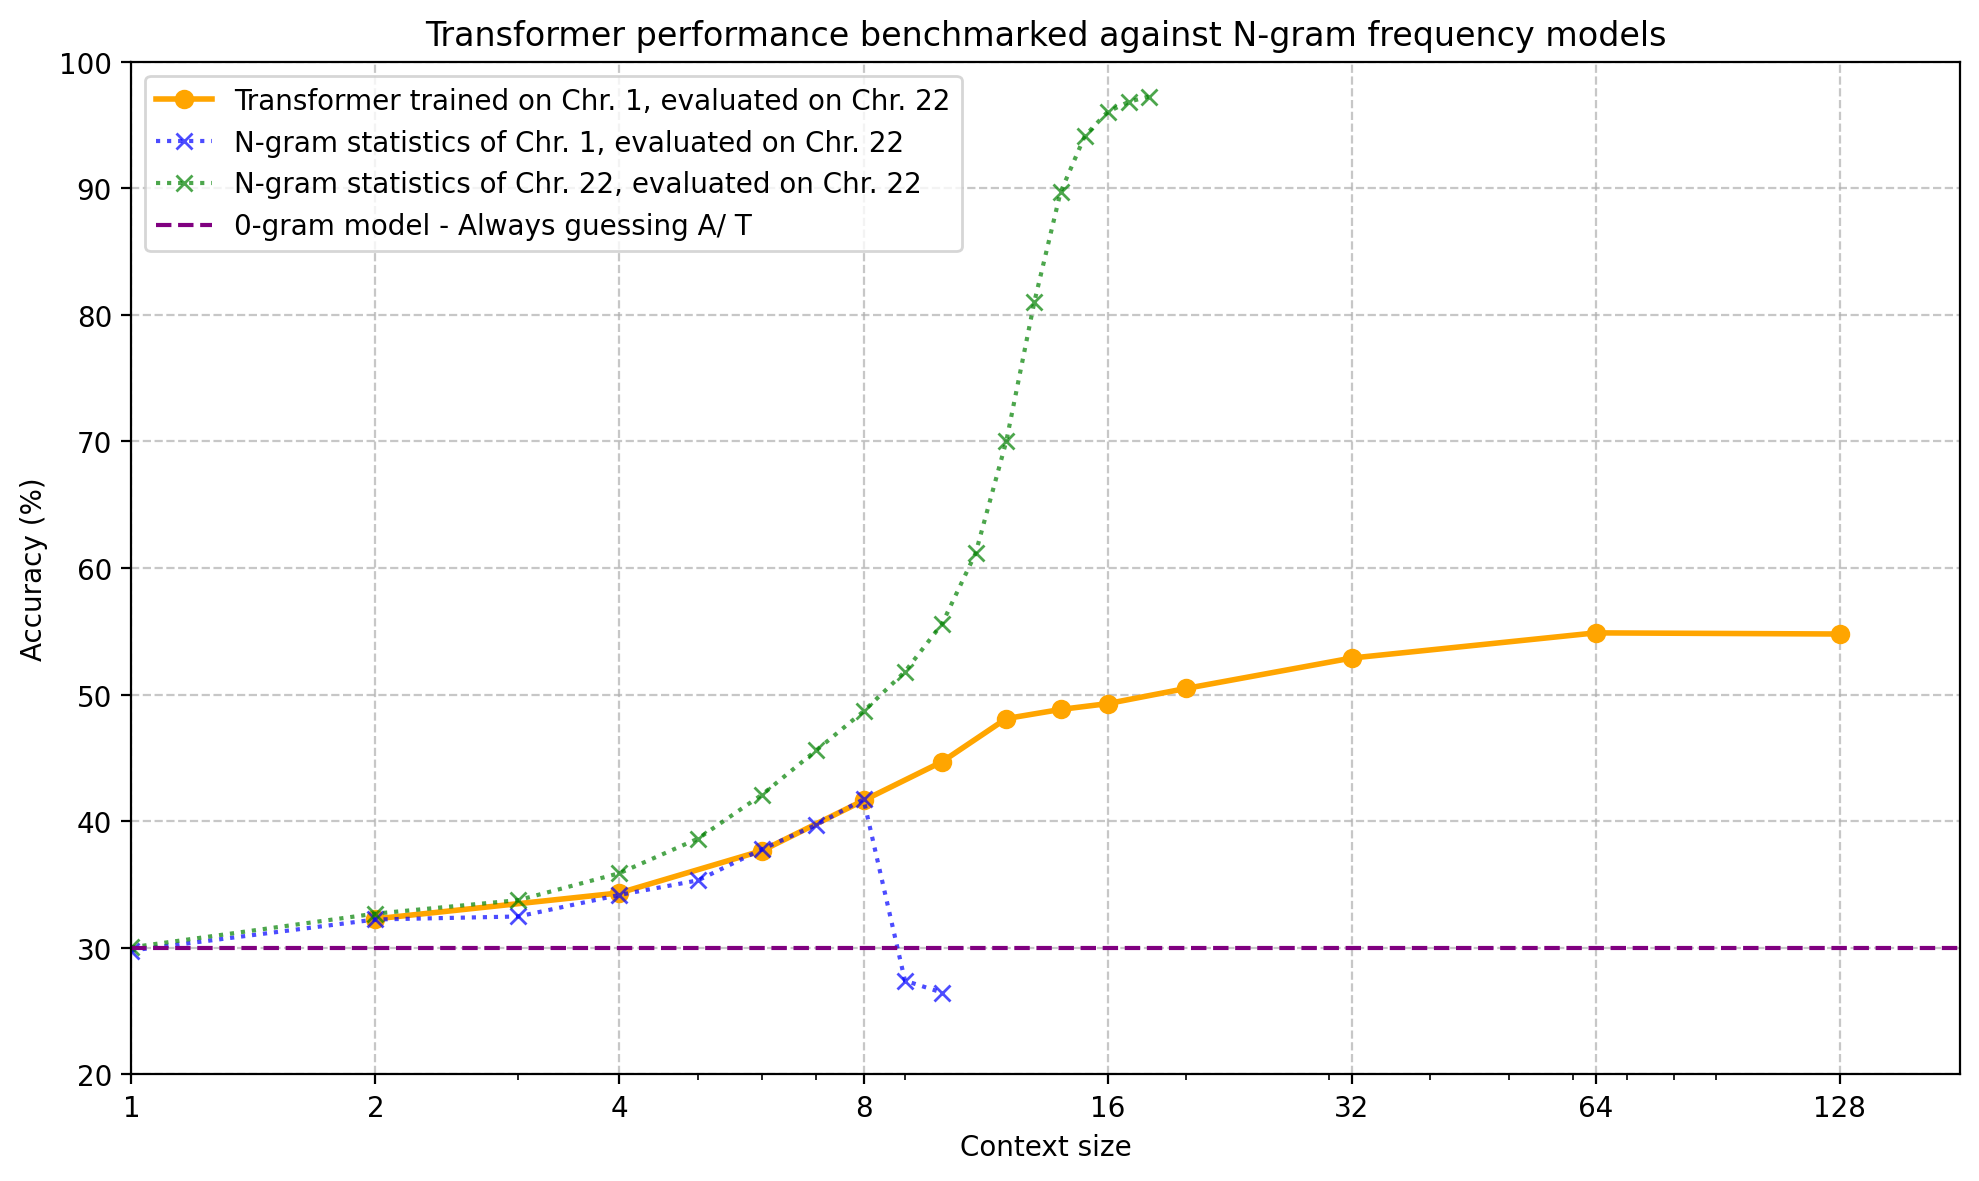

In [45]:
import matplotlib.pyplot as plt

# Filter data to include only x values <= 128
accuracies_small_test_filtered = accuracies_small_test[accuracies_small_test['block_size'] <= 128]
n_gram_train_filtered = n_gram_train[n_gram_train['context_size'] <= 128]
n_gram_test_filtered = n_gram_test[n_gram_test['1'] <= 128]

plt.figure(figsize=(10, 6))  # Increase figure size for better readability

# Plot the Transformer model
plt.plot(accuracies_small_test_filtered['block_size'], accuracies_small_test_filtered['Accuracy'], 
         marker='o', label='Transformer trained on Chr. 1, evaluated on Chr. 22', 
         color='orange', linestyle='-', linewidth=2)

# Plot the N-gram models
plt.plot(n_gram_train_filtered['context_size'], n_gram_train_filtered['best_accuracy_train'], 
         marker='x', color='blue', linestyle='dotted', alpha=0.7, 
         label='N-gram statistics of Chr. 1, evaluated on Chr. 22')

plt.plot(n_gram_test_filtered['1'], n_gram_test_filtered['30.044'], 
         marker='x', color='green', linestyle='dotted', alpha=0.7, 
         label='N-gram statistics of Chr. 22, evaluated on Chr. 22')

# Label axes and title
plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Transformer performance benchmarked against N-gram frequency models')

# Set y and x limits
plt.ylim(20, 100)
plt.xlim(1, 180)
plt.xscale('log')

# Set x-ticks
plt.xticks([1,2,4,8,16,32,64,128], labels=[1,2,4,8,16,32,64,128])

# Plot reference line
plt.axhline(y=30, color='purple', linestyle='--', label='0-gram model - Always guessing A/ T')

# Set legend
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))  # Move the legend outside the plot

# Add grid and layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust the layout to prevent overlapping

# Display plot
plt.show()


In [20]:
accuracies_small_test[accuracies_small_test['block_size']<=8]

Letter  Accuracy        n Eval data  block_size
3      01     32.29  10000.0  test_set         2.0
10     02     34.34  10000.0  test_set         4.0
13     03     37.68  10000.0  test_set         6.0
59     04     41.64  10000.0  test_set         8.0

In [22]:
merged_df = accuracies_small_test[accuracies_small_test['block_size']<=8].merge(
    n_gram_train,
    how='inner', 
    left_on='block_size', 
    right_on='context_size'
)
merged_df

Letter  Accuracy        n Eval data  block_size  context_size  \
0     01     32.29  10000.0  test_set         2.0             2   
1     02     34.34  10000.0  test_set         4.0             4   
2     03     37.68  10000.0  test_set         6.0             6   
3     04     41.64  10000.0  test_set         8.0             8   

   best_accuracy_train  accuracy_with_perfect_test  
0               32.240                      32.703  
1               34.182                      35.899  
2               37.798                      42.110  
3               41.737                      48.681

In [23]:
(merged_df['Accuracy']-merged_df['best_accuracy_train'])

0    0.050
1    0.158
2   -0.118
3   -0.097
dtype: float64

In [24]:
(merged_df['Accuracy']-merged_df['best_accuracy_train'])/merged_df['best_accuracy_train']*100

0    0.155087
1    0.462232
2   -0.312186
3   -0.232408
dtype: float64

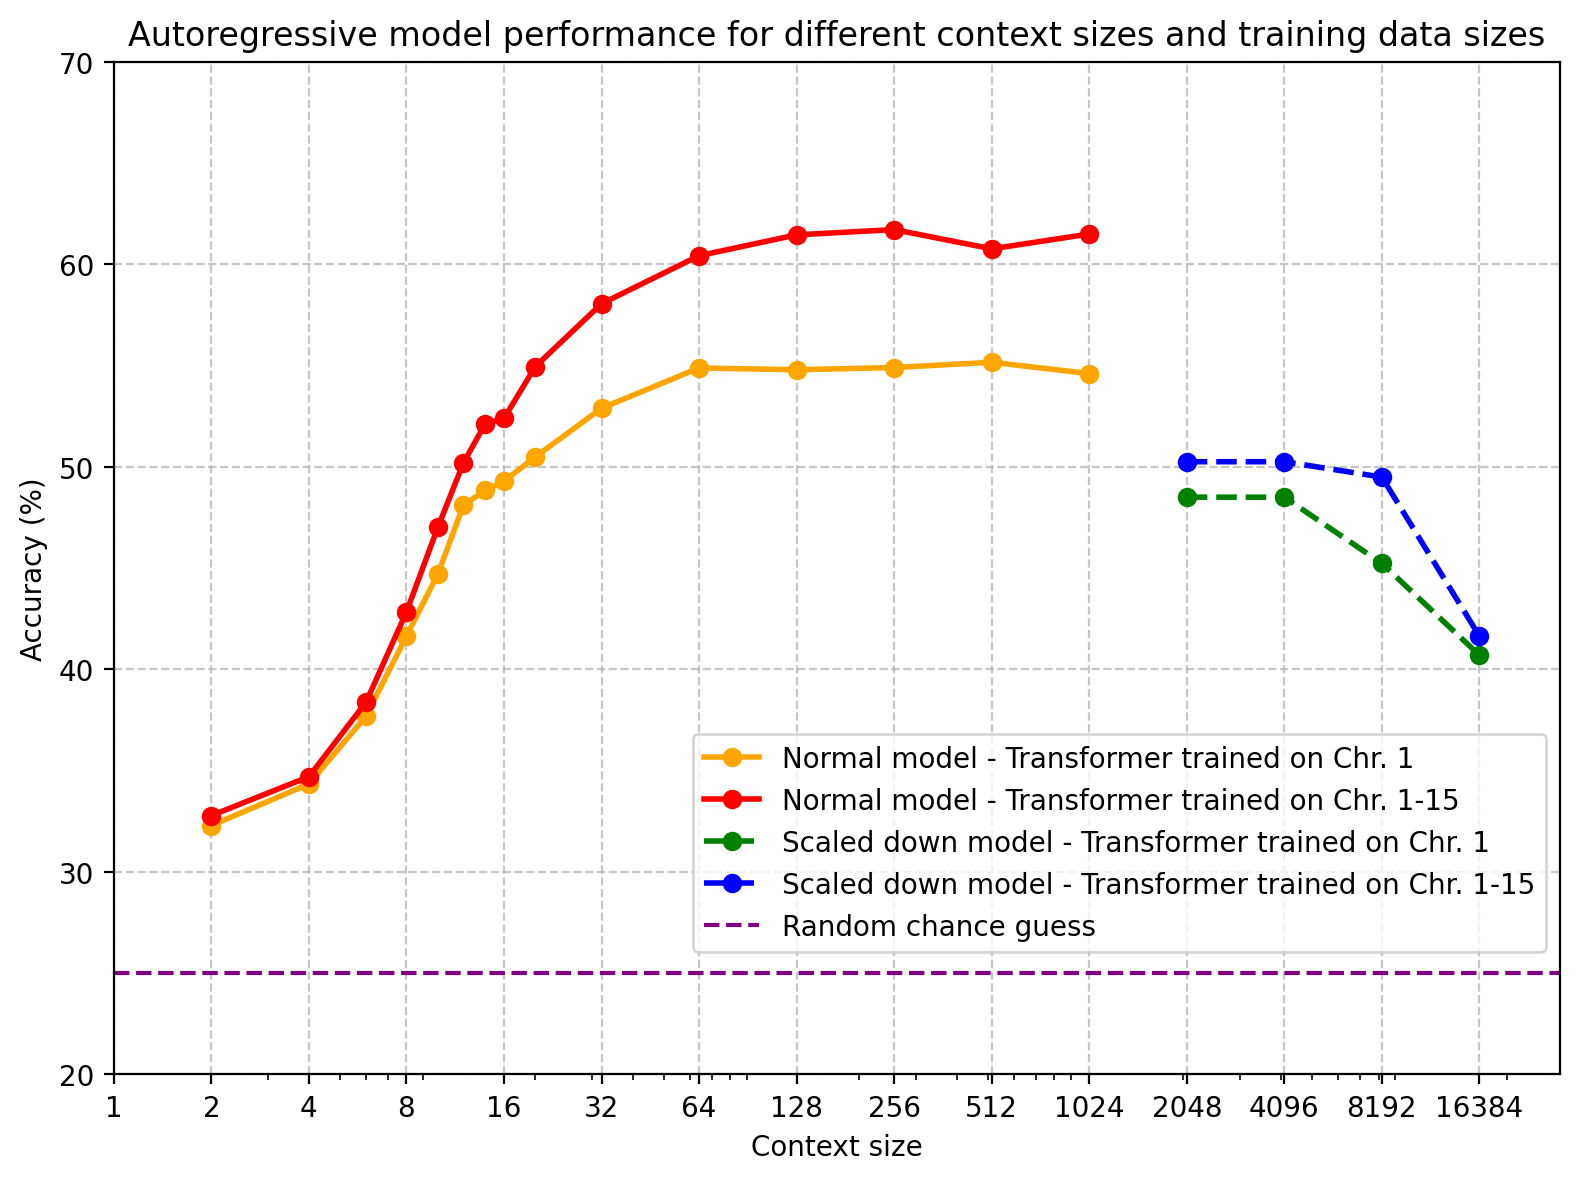

In [64]:
import numpy as np

accuracies_small_test=accuracies_small[accuracies_small['Eval data']=='test_set']

# Split data into two groups: below 2000 (Normal model) and above 2000 (Scaled down model)
normal_model_small = accuracies_small_test[accuracies_small_test['block_size'] <= 2000]
scaled_down_model_small = accuracies_small_test[accuracies_small_test['block_size'] > 2000]

normal_model_large = accuracies_large[accuracies_large['block_size'] <= 2000]
scaled_down_model_large = accuracies_large[accuracies_large['block_size'] > 2000]

plt.figure(figsize=(8, 6))  # Increase figure size for better readability

# Plot data for context sizes below 2000 (Normal model)
plt.plot(normal_model_small['block_size'], normal_model_small['Accuracy'], 
         marker='o', label='Normal model - Transformer trained on Chr. 1', color='orange', linestyle='-', linewidth=2)
plt.plot(normal_model_large['block_size'], normal_model_large['Accuracy'], 
         marker='o', label='Normal model - Transformer trained on Chr. 1-15', color='red', linestyle='-', linewidth=2)

# Plot data for context sizes above 2000 (Scaled down model)
plt.plot(scaled_down_model_small['block_size'], scaled_down_model_small['Accuracy'], 
         marker='o', label='Scaled down model - Transformer trained on Chr. 1', color='green', linestyle='--', linewidth=2)
plt.plot(scaled_down_model_large['block_size'], scaled_down_model_large['Accuracy'], 
         marker='o', label='Scaled down model - Transformer trained on Chr. 1-15', color='blue', linestyle='--', linewidth=2)

plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Autoregressive model performance for different context sizes and training data sizes')
plt.ylim(20, 70)
plt.xlim(2, 29000)
plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], 
           labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])

plt.axhline(y=25, color='purple', linestyle='--', label='Random chance guess')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.35))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()


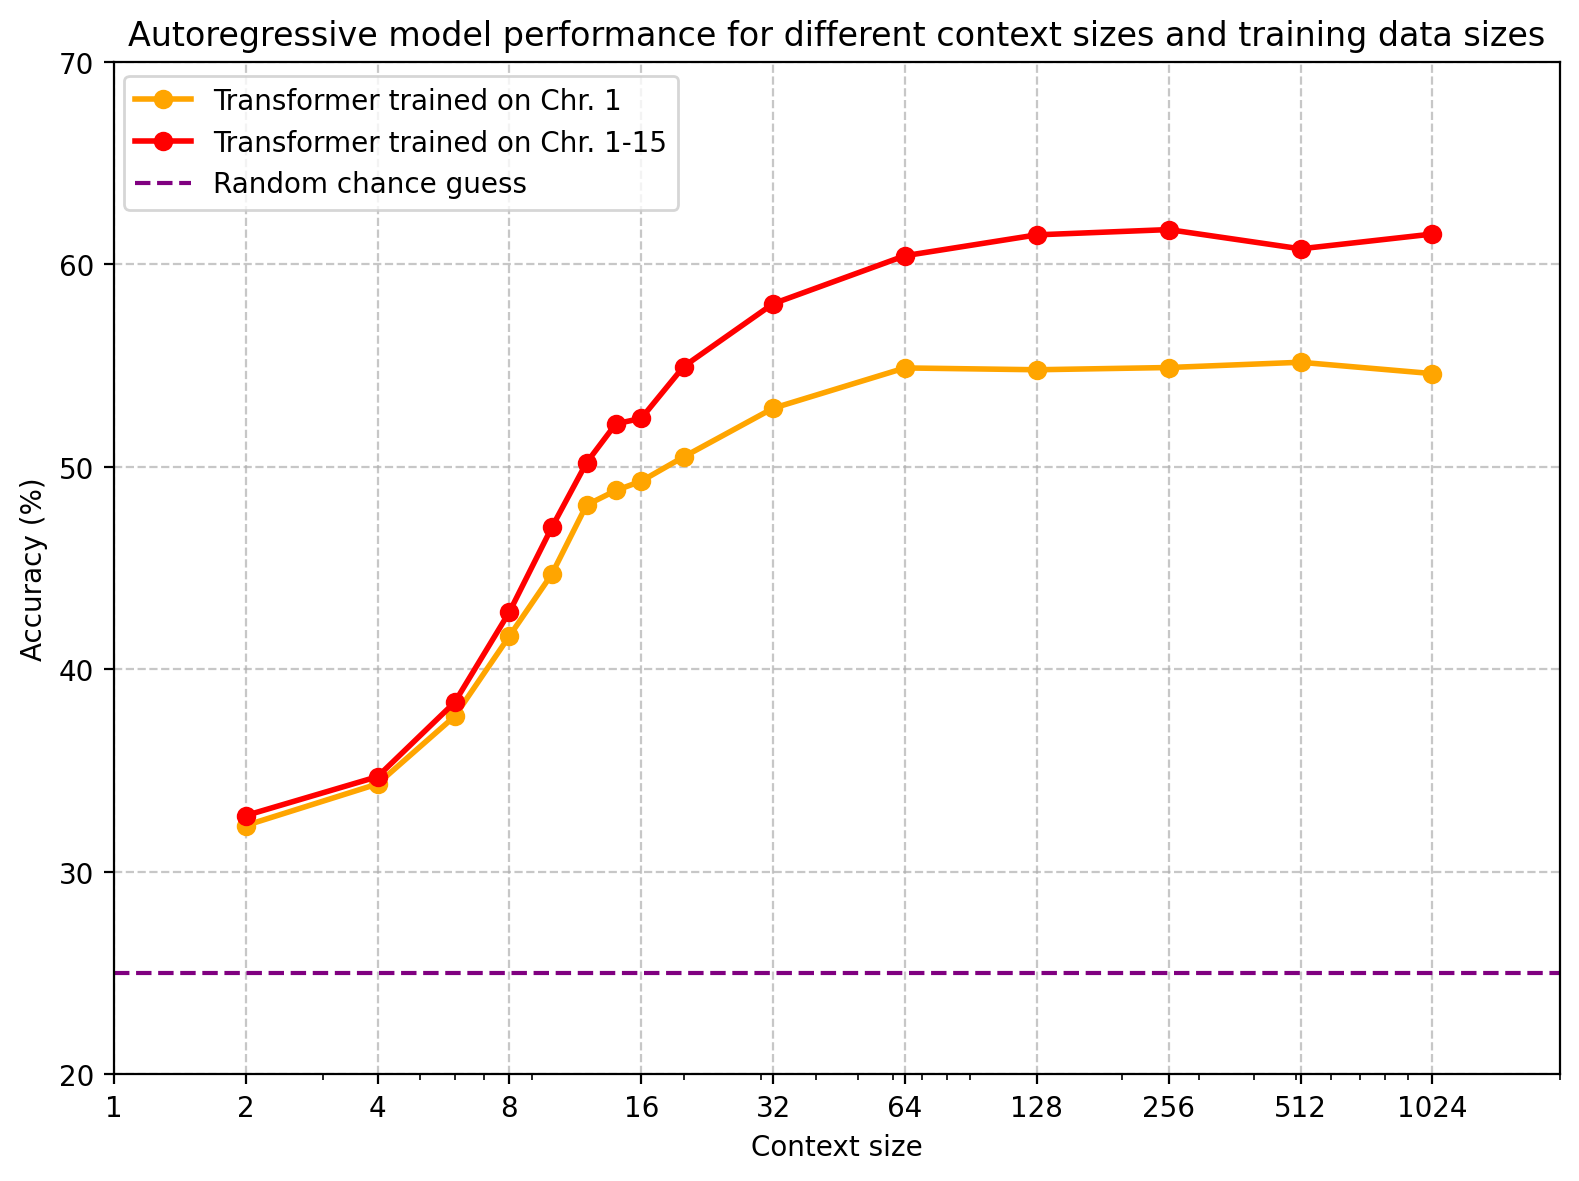

In [41]:
### import numpy as np

accuracies_small_test=accuracies_small[accuracies_small['Eval data']=='test_set']

# Split data into two groups: below 2000 (Normal model) and above 2000 (Scaled down model)
normal_model_small = accuracies_small_test[accuracies_small_test['block_size'] <= 2000]
scaled_down_model_small = accuracies_small_test[accuracies_small_test['block_size'] > 2000]

normal_model_large = accuracies_large[accuracies_large['block_size'] <= 2000]
scaled_down_model_large = accuracies_large[accuracies_large['block_size'] > 2000]

plt.figure(figsize=(8, 6))  # Increase figure size for better readability

# Plot data for context sizes below 2000 (Normal model)
plt.plot(normal_model_small['block_size'], normal_model_small['Accuracy'], 
         marker='o', label='Transformer trained on Chr. 1', color='orange', linestyle='-', linewidth=2)
plt.plot(normal_model_large['block_size'], normal_model_large['Accuracy'], 
         marker='o', label='Transformer trained on Chr. 1-15', color='red', linestyle='-', linewidth=2)

# Plot data for context sizes above 2000 (Scaled down model)
#plt.plot(scaled_down_model_small['block_size'], scaled_down_model_small['Accuracy'], 
#         marker='o', label='Scaled down model - Transformer trained on Chr. 1', color='green', linestyle='--', linewidth=2)
#plt.plot(scaled_down_model_large['block_size'], scaled_down_model_large['Accuracy'], 
#         marker='o', label='Scaled down model - Transformer trained on Chr. 1-15', color='blue', linestyle='--', linewidth=2)

plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Autoregressive model performance for different context sizes and training data sizes')
plt.ylim(20, 70)
plt.xlim(1, 2000)
plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024], 
           labels=[1,2,4,8,16,32,64,128,256,512,1024])

plt.axhline(y=25, color='purple', linestyle='--', label='Random chance guess')
plt.legend(loc='upper right', bbox_to_anchor=(0.4, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()


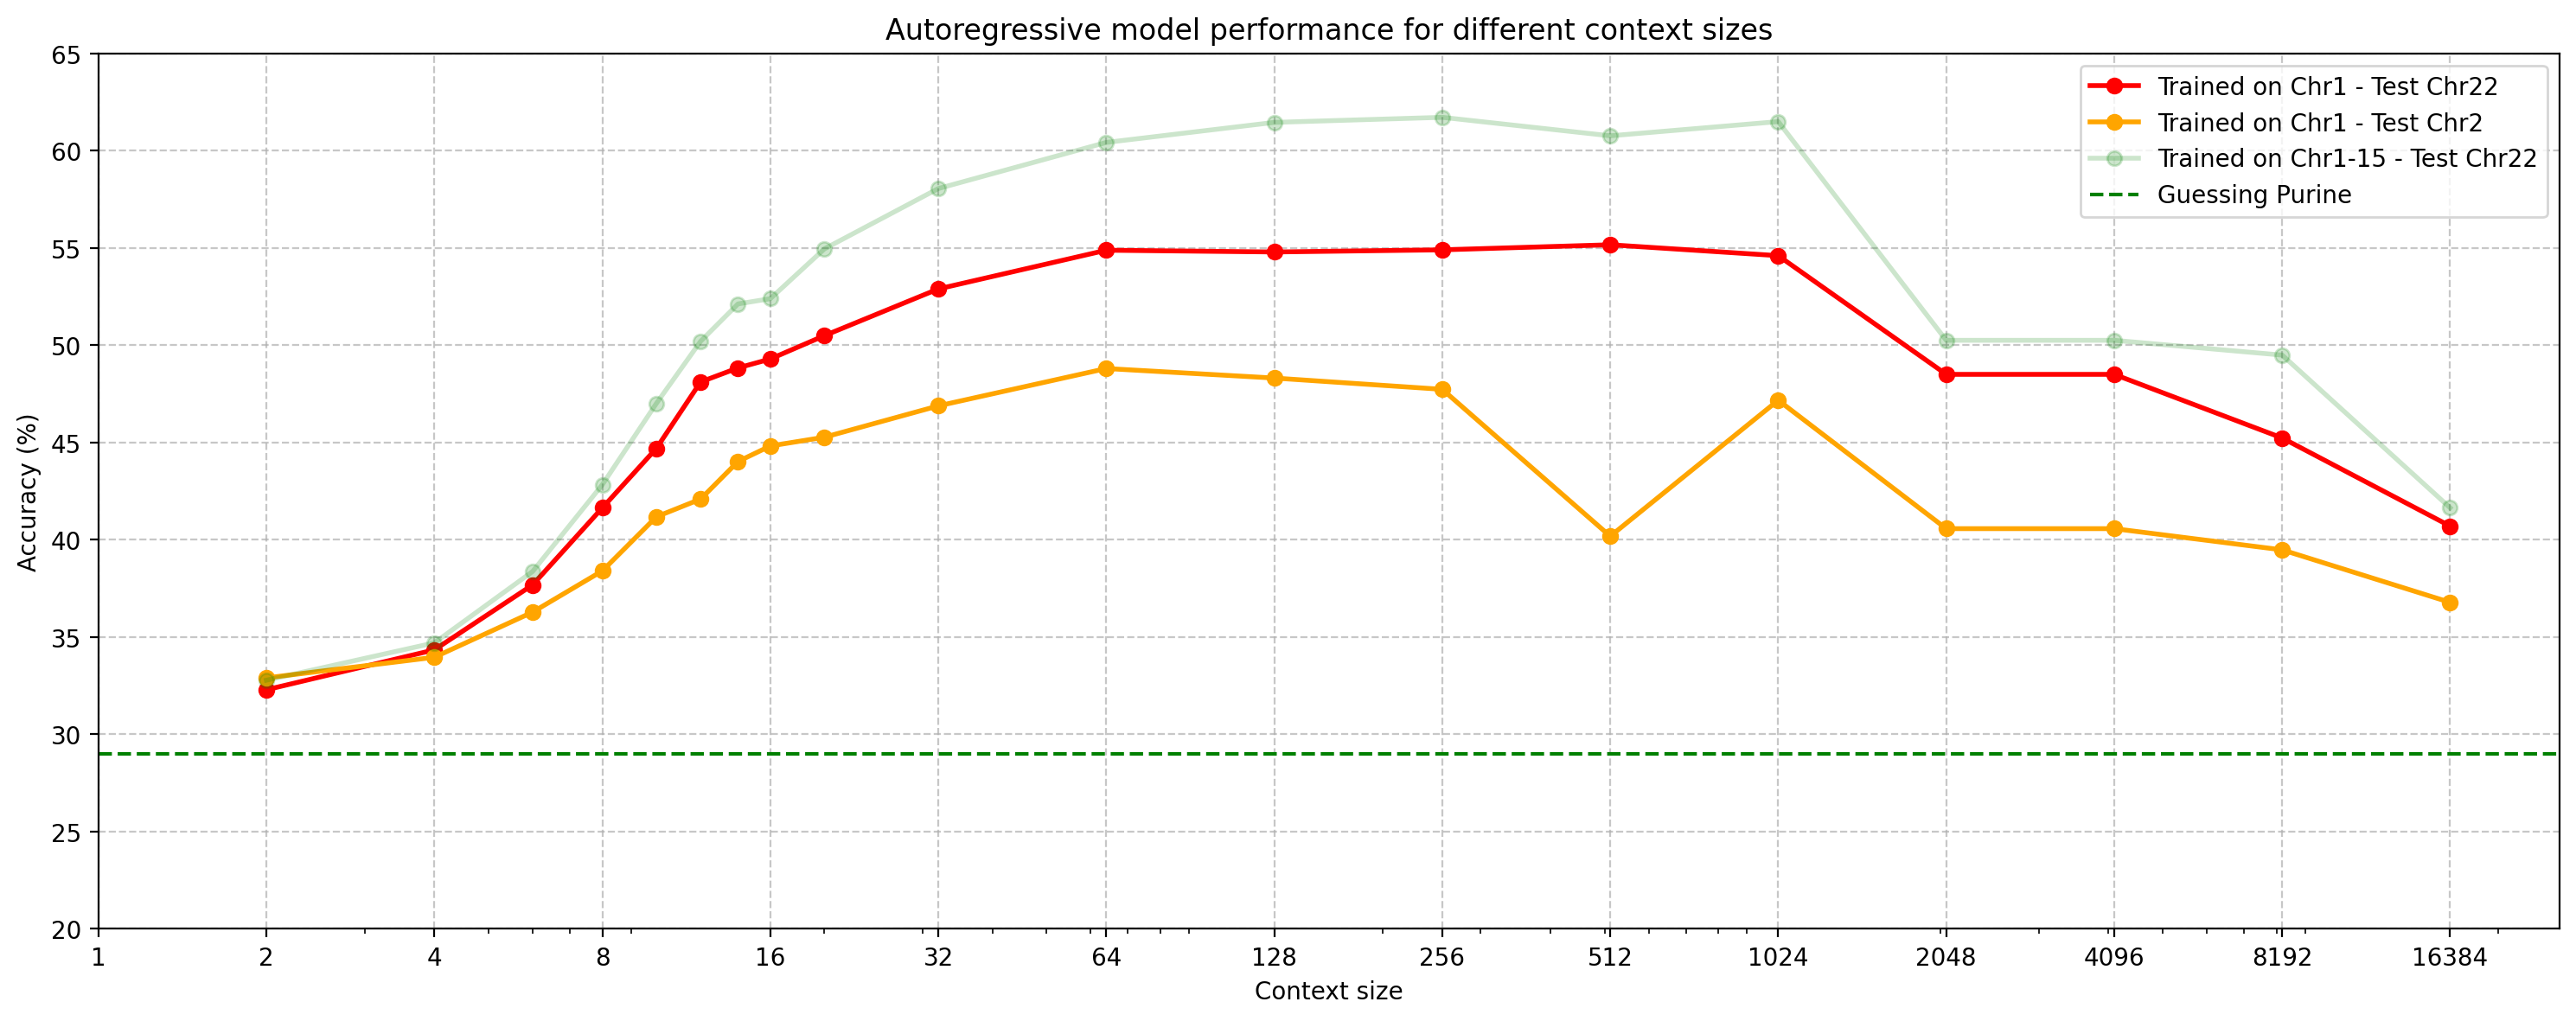

In [34]:
plt.figure(figsize=(15, 6))  # Increase figure size for better readability

accuracies_small_test1   = accuracies_small[accuracies_small['Eval data']=='test_set']
accuracies_small_test2   = accuracies_small[accuracies_small['Eval data']=='test2_set']


plt.plot(accuracies_small_test1['block_size'], accuracies_small_test1['Accuracy'], marker='o', label='Trained on Chr1 - Test Chr22', color='red', linestyle='-', linewidth=2)
plt.plot(accuracies_small_test2['block_size'], accuracies_small_test2['Accuracy'], marker='o', label='Trained on Chr1 - Test Chr2', color='orange', linestyle='-', linewidth=2)

plt.plot(accuracies_large['block_size'], accuracies_large['Accuracy'], marker='o', label='Trained on Chr1-15 - Test Chr22', alpha=0.2, color='green', linestyle='-', linewidth=2)


# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

#plt.plot(n_gram_train['context_size'], n_gram_train['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.2,label='N-grams of Chr1, evaluated on Chr22')
#plt.plot(n_gram_test['1'], n_gram_test['30.044'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of Chr22, evaluated on Chr22')



plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Autoregressive model performance for different context sizes')
plt.ylim(20, 65)
plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])

plt.axhline(y=29, color='green', linestyle='--', label='Guessing Purine')

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

#### test on train test val

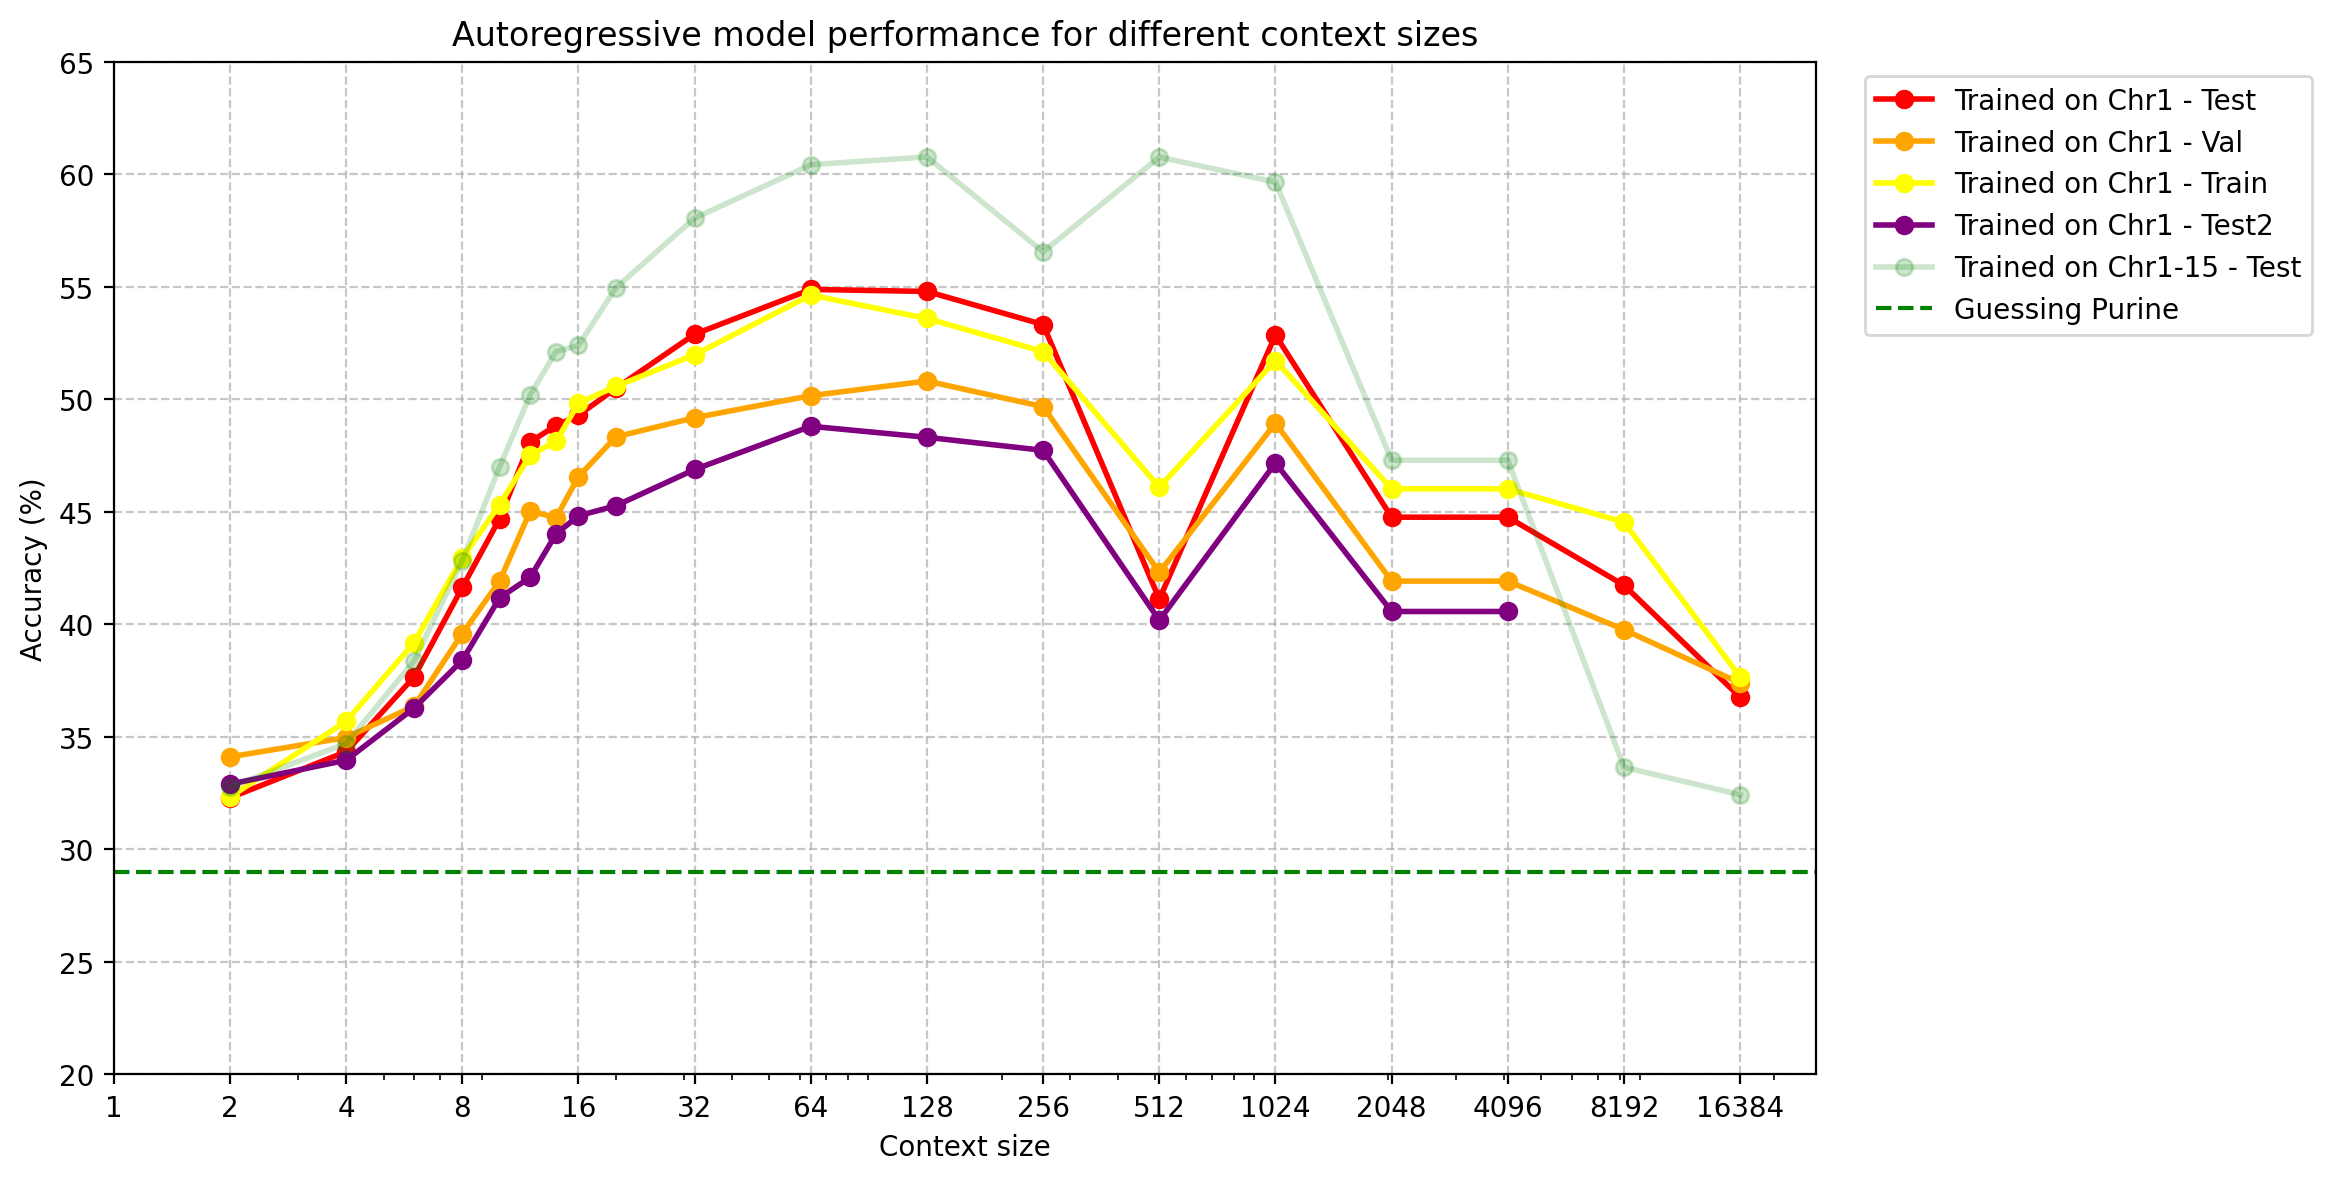

In [54]:
plt.figure(figsize=(12, 6))  # Increase figure size for better readability

accuracies_small_test =accuracies_small[accuracies_small['Eval data']=='test_set']
accuracies_small_val  =accuracies_small[accuracies_small['Eval data']=='val_set']
accuracies_small_train=accuracies_small[accuracies_small['Eval data']=='train_set']
accuracies_small_test2   = accuracies_small[accuracies_small['Eval data']=='test2_set']




plt.plot(accuracies_small_test['block_size'], accuracies_small_test['Accuracy'], marker='o', label='Trained on Chr1 - Test', color='red', linestyle='-', linewidth=2)
plt.plot(accuracies_small_val['block_size'], accuracies_small_val['Accuracy'], marker='o', label='Trained on Chr1 - Val', color='orange', linestyle='-', linewidth=2)
plt.plot(accuracies_small_train['block_size'], accuracies_small_train['Accuracy'], marker='o', label='Trained on Chr1 - Train', color='yellow', linestyle='-', linewidth=2)
plt.plot(accuracies_small_test2['block_size'], accuracies_small_test2['Accuracy'], marker='o', label='Trained on Chr1 - Test2', color='purple', linestyle='-', linewidth=2)

plt.plot(accuracies_large['block_size'], accuracies_large['Accuracy'], marker='o', label='Trained on Chr1-15 - Test', alpha=0.2, color='green', linestyle='-', linewidth=2)


# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

#plt.plot(n_gram_train['context_size'], n_gram_train['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.2,label='N-grams of Chr1, evaluated on Chr22')
#plt.plot(n_gram_test['1'], n_gram_test['30.044'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of Chr22, evaluated on Chr22')




plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Autoregressive model performance for different context sizes')
plt.ylim(20, 65)
plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])

plt.axhline(y=29, color='green', linestyle='--', label='Guessing Purine')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

# mutation

## effective batch size

In [53]:
accuracies=extract_accuracies('A1',autoreg=False)
parameters_list = ['gradient_accumulation_steps', 'batch_size']
parameters_df = extract_parameters(parameters_list, 'A1', letter_length=1, autoreg=False)
parameters_df['gradient_accumulation_steps'] = parameters_df['gradient_accumulation_steps'].astype(int)
parameters_df['batch_size'] = parameters_df['batch_size'].astype(int)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
idx = accuracies.groupby(['gradient_accumulation_steps', 'batch_size'])['Accuracy'].idxmax()
accuracies = accuracies.loc[idx].sort_values(by='Accuracy', ascending=False)
accuracies.sort_values(by='Accuracy', ascending=False).head()

Letter  Accuracy        n Eval data  gradient_accumulation_steps  \
9       s     68.39  20000.0  test_set                           40   
43      t     68.34  20000.0  test_set                           40   
17      x     68.25  20000.0  test_set                          100   
35      y     68.23  20000.0  test_set                          100   
62      w     68.19  20000.0  test_set                          100   

    batch_size  
9           64  
43         256  
17          64  
35         256  
62          16

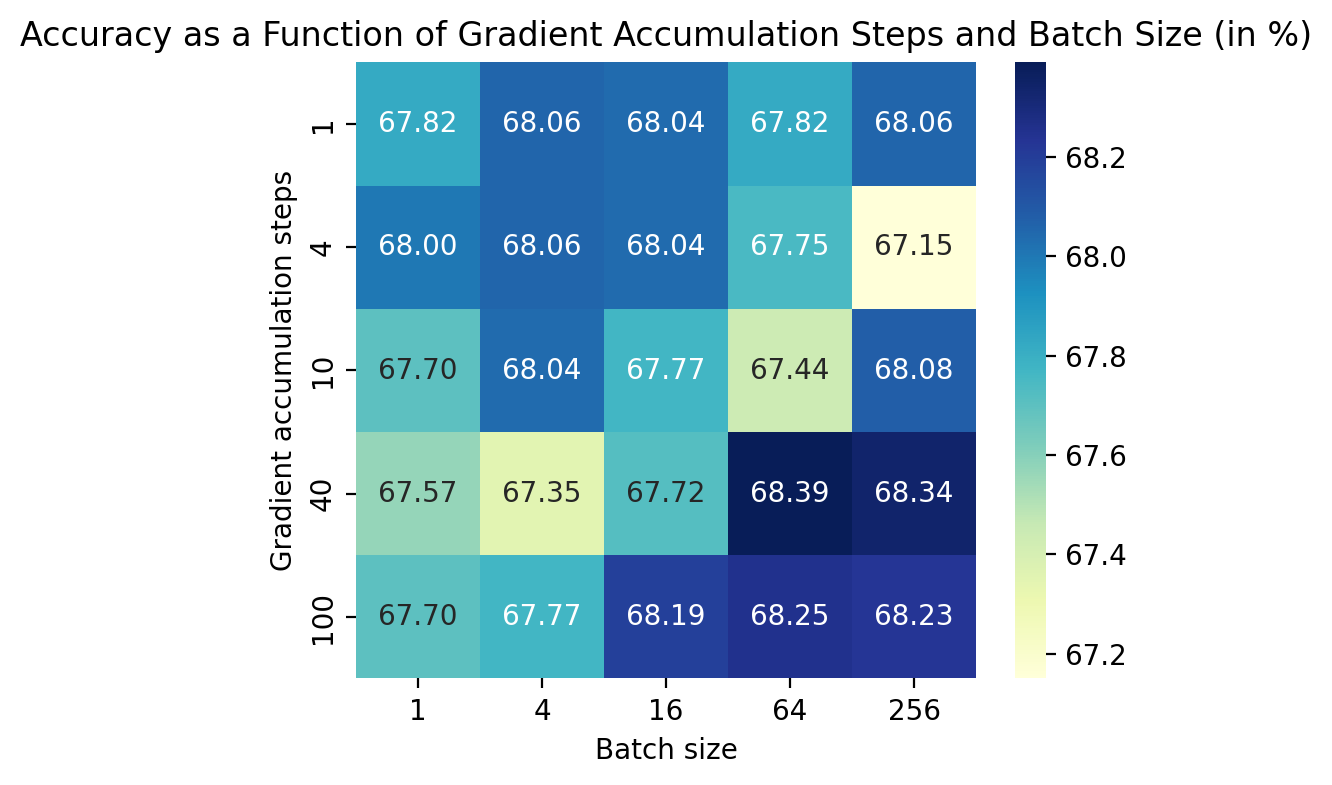

In [54]:
plot_heatmap(accuracies, 'gradient_accumulation_steps', 'batch_size')

In [57]:
accuracies

Letter  Accuracy        n Eval data  gradient_accumulation_steps  \
9       s     68.39  20000.0  test_set                           40   
43      t     68.34  20000.0  test_set                           40   
17      x     68.25  20000.0  test_set                          100   
35      y     68.23  20000.0  test_set                          100   
62      w     68.19  20000.0  test_set                          100   
1       o     68.08  20000.0  test_set                           10   
22      e     68.06  20000.0  test_set                            1   
21      e     68.06  20000.0  test_set                            4   
23      e     68.06  20000.0  test_set                            1   
3       c     68.04  20000.0  test_set                            1   
12      h     68.04  20000.0  test_set                            4   
11      h     68.04  20000.0  test_set                           10   
28      f     68.00  20000.0  test_set                            4   
52      d     67.82  20000.0  test_set                            1   
50      d     67.82  20000.0  test_set                            1   
0       v     67.77  20000.0  test_set                          100   
10      m     67.77  20000.0  test_set                           10   
63      i     67.75  20000.0  test_set                            4   
60      r     67.72  20000.0  test_set                           40   
61      k     67.70  20000.0  test_set                           10   
42      u     67.70  20000.0  test_set                          100   
27      p     67.57  20000.0  test_set                           40   
8       n     67.44  20000.0  test_set                           10   
7       q     67.35  20000.0  test_set                           40   
34      j     67.15  20000.0  test_set                            4   

    batch_size  
9           64  
43         256  
17          64  
35         256  
62          16  
1          256  
22         256  
21           4  
23           4  
3           16  
12          16  
11           4  
28           1  
52           1  
50          64  
0            4  
10          16  
63          64  
60          16  
61           1  
42           1  
27           1  
8           64  
7            4  
34         256

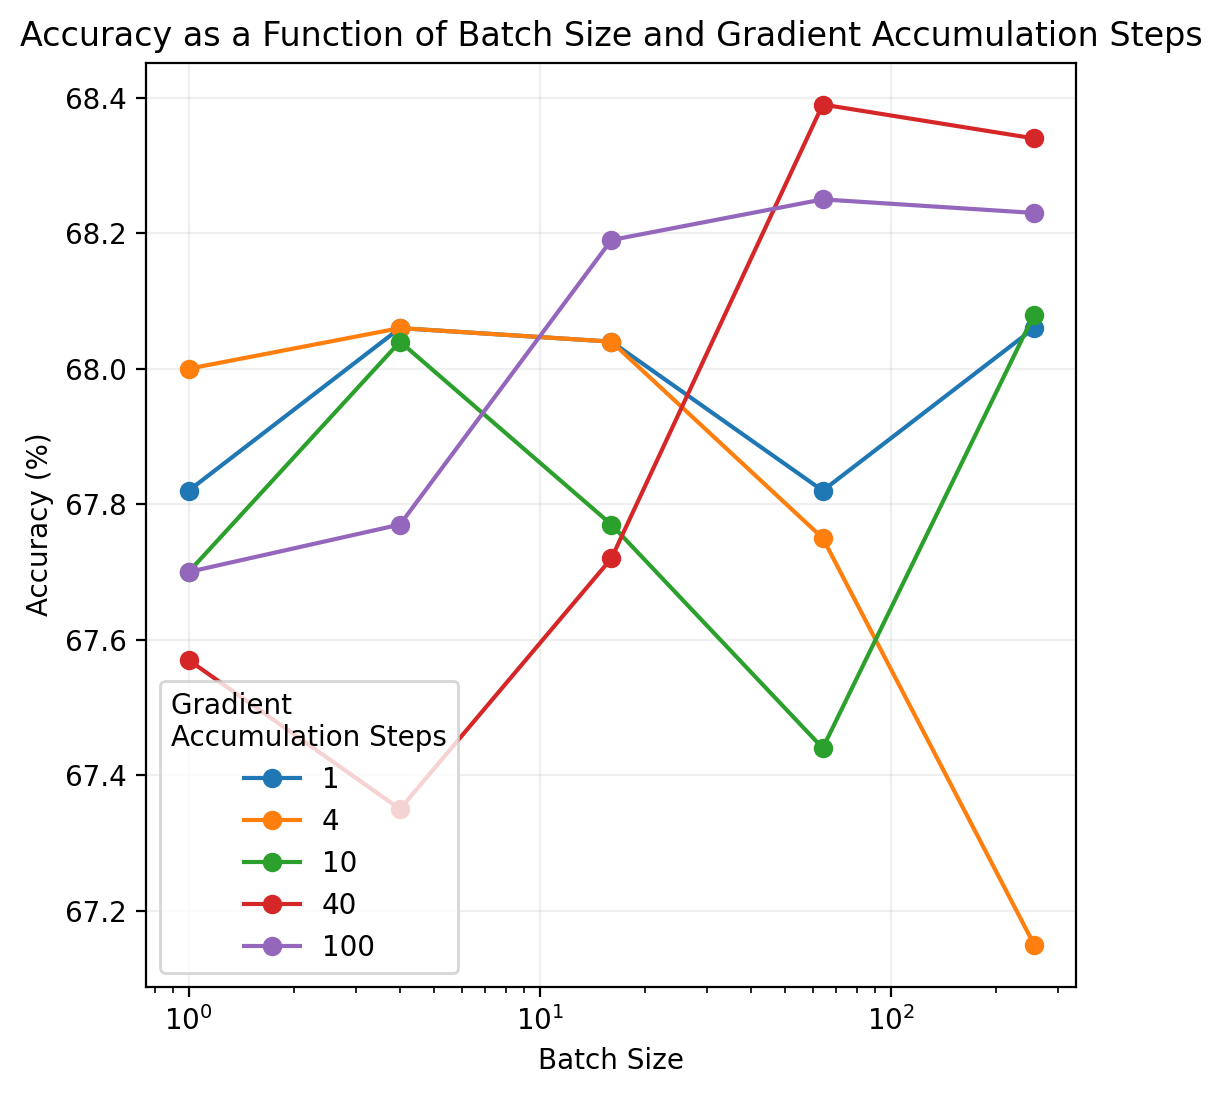

In [58]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'batch_size' and 'gradient_accumulation_steps' to ensure correct plotting order
accuracies_sorted = accuracies.sort_values(by=['batch_size', 'gradient_accumulation_steps'])

# Extract and sort unique values of gradient_accumulation_steps
gradient_accumulation_steps_values = sorted(accuracies_sorted['gradient_accumulation_steps'].unique())

plt.figure(figsize=(6, 6))

# Plot for each gradient_accumulation_steps value
for grad_accum_steps in gradient_accumulation_steps_values:
    subset = accuracies_sorted[accuracies_sorted['gradient_accumulation_steps'] == grad_accum_steps]
    plt.plot(subset['batch_size'], subset['Accuracy'], marker='o', label=f'{grad_accum_steps}')

plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Batch Size and Gradient Accumulation Steps')
plt.legend(title='Gradient \nAccumulation Steps')
plt.grid(True, alpha=0.2)
plt.show()


## model size

In [47]:
accuracies=extract_accuracies('A2',autoreg=False)
parameters_list = ['n_layer', 'n_head', 'n_embd']
parameters_df = extract_parameters(parameters_list, 'A2',autoreg=False)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['n_layer'] = accuracies['n_layer'].astype(int)
accuracies['n_head'] = accuracies['n_head'].astype(int)
accuracies['n_embd'] = accuracies['n_embd'].astype(int)
accuracies['n_parameters']=accuracies['n_layer']* accuracies['n_head']*accuracies['n_embd']

accuracies.sort_values(by='Accuracy', ascending=False).head()

Letter  Accuracy        n Eval data  n_layer  n_head  n_embd  n_parameters
11     21     68.91  20000.0  test_set        8       8     120          7680
3      17     68.86  20000.0  test_set        8       6     120          5760
26     29     68.81  20000.0  test_set        8      12     120         11520
36     10     68.75  20000.0  test_set        6      10     240         14400
21     25     68.66  20000.0  test_set        8      10     120          9600

120


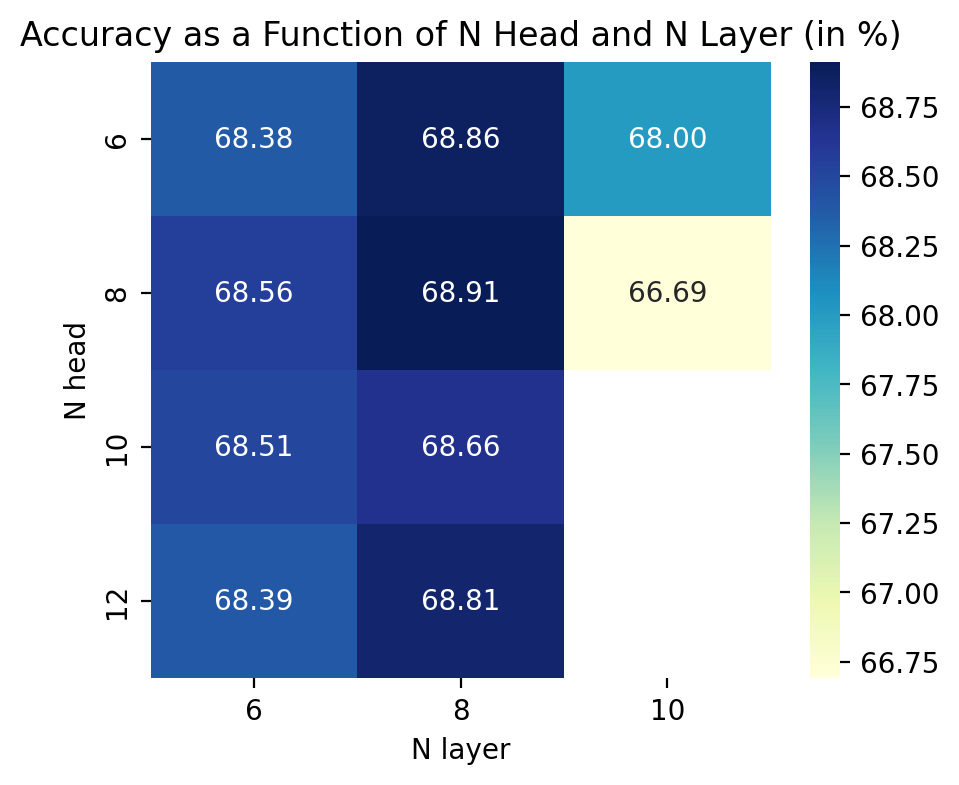

240


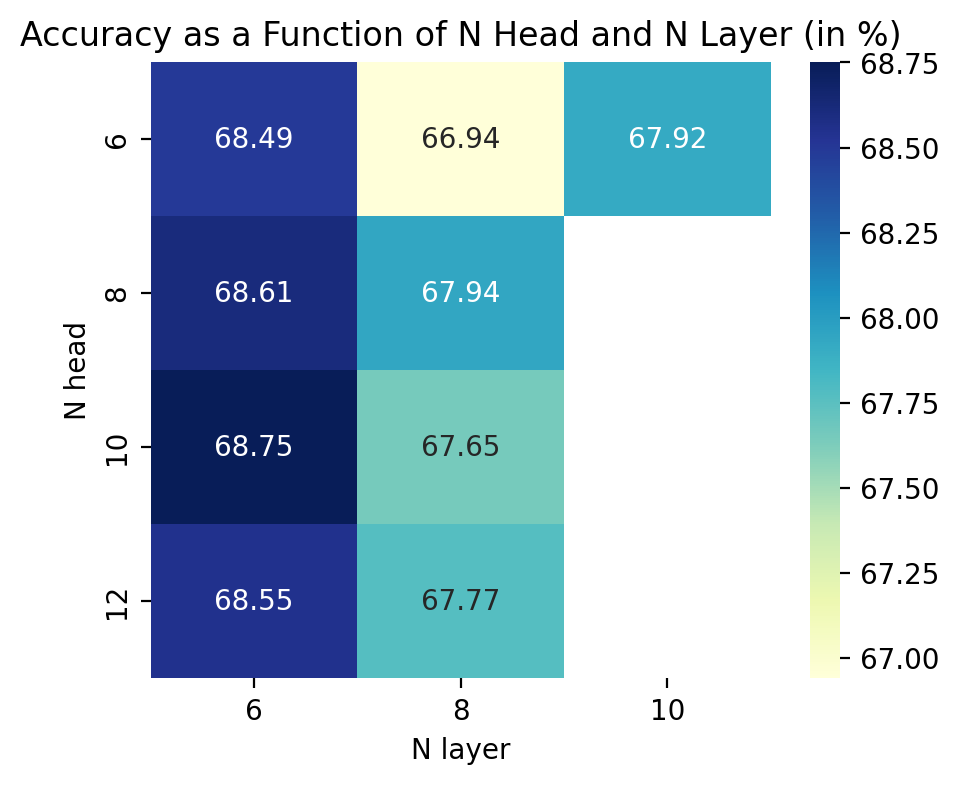

360


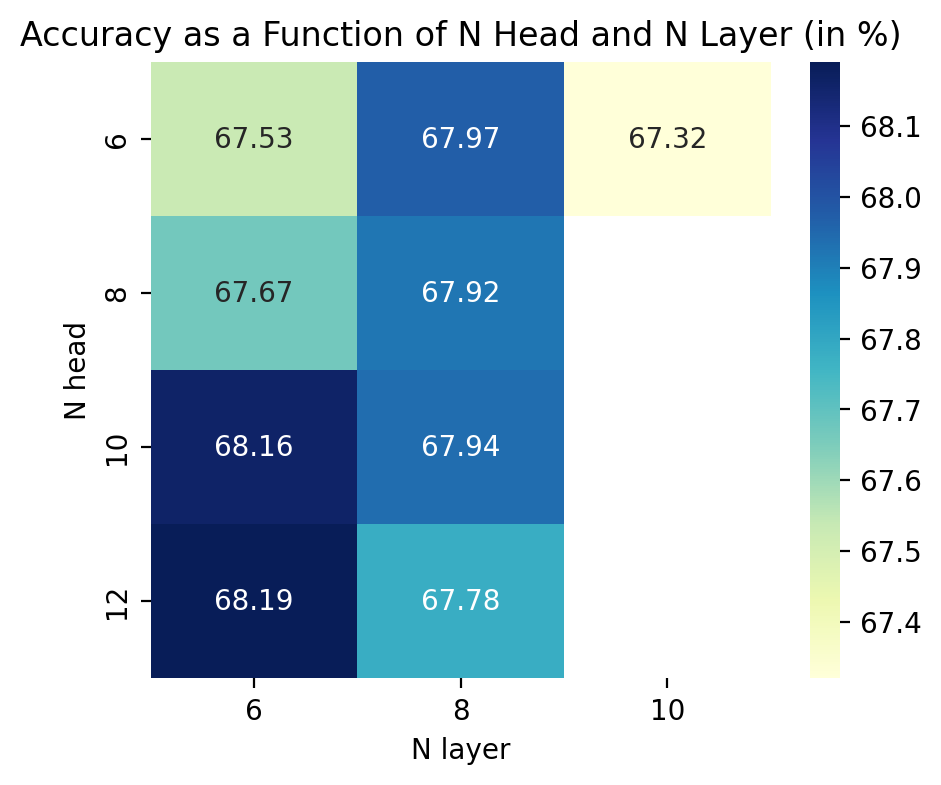

480


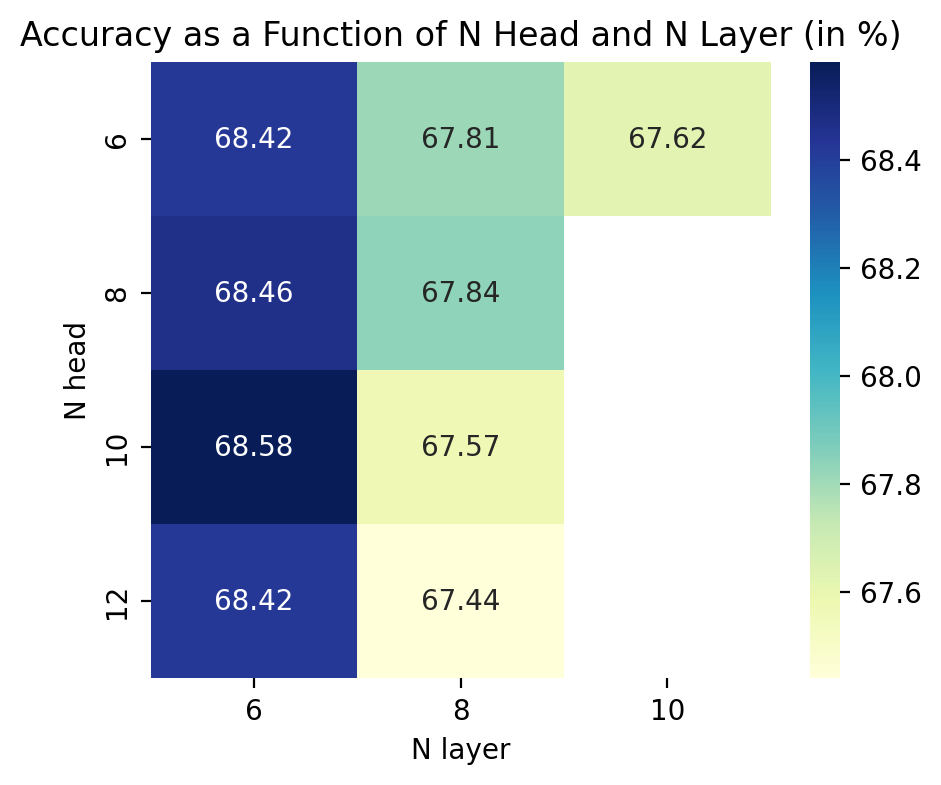

In [48]:
print(120)
plot_heatmap(accuracies[accuracies['n_embd']==120], 'n_head', 'n_layer')
print(240)
plot_heatmap(accuracies[accuracies['n_embd']==240], 'n_head', 'n_layer')
print(360)
plot_heatmap(accuracies[accuracies['n_embd']==360], 'n_head', 'n_layer')
print(480)
plot_heatmap(accuracies[accuracies['n_embd']==480], 'n_head', 'n_layer')

## Learning

In [59]:
accuracies=extract_accuracies('A3',autoreg=False)
parameters_list = ['warmup_iters', 'learning_rate']
parameters_df = extract_parameters(parameters_list,'A3',autoreg=False)
parameters_df['warmup_iters'] = parameters_df['warmup_iters'].astype(int)
parameters_df['learning_rate'] = parameters_df['learning_rate'].astype(float)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
#accuracies.sort_values(by='Accuracy', ascending=False)
#accuracies.head()

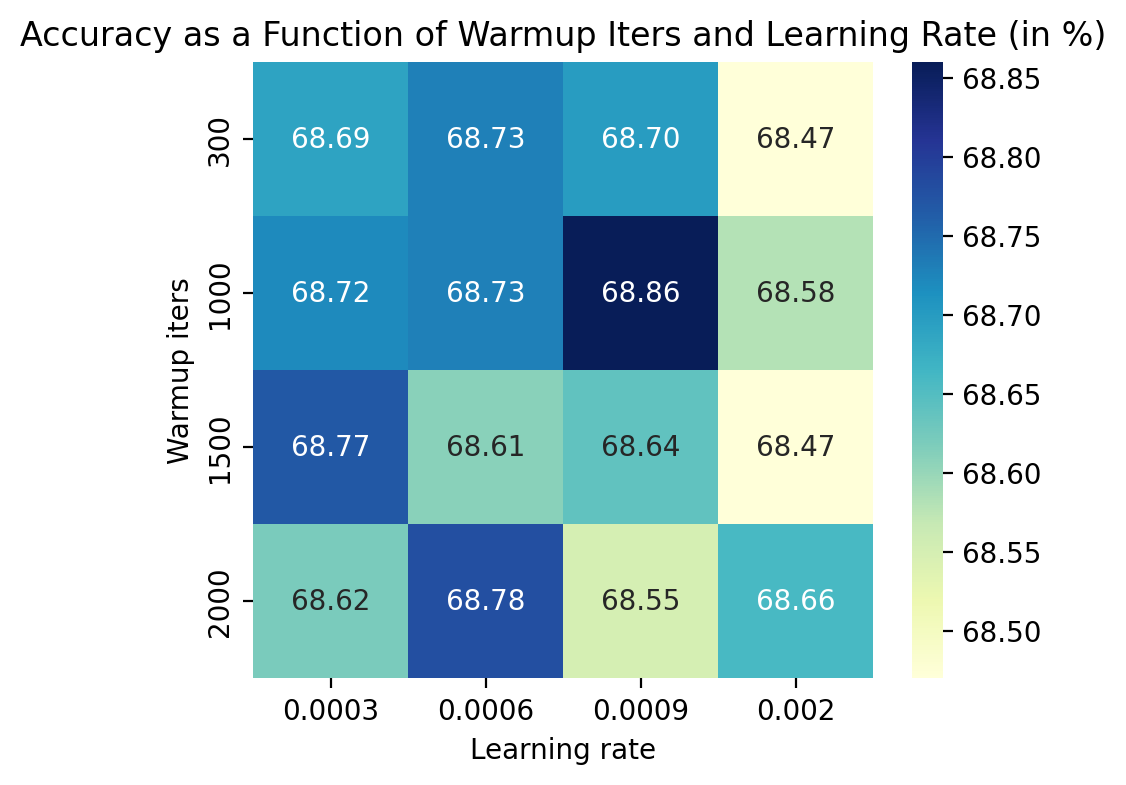

In [60]:
plot_heatmap(accuracies, 'warmup_iters', 'learning_rate')

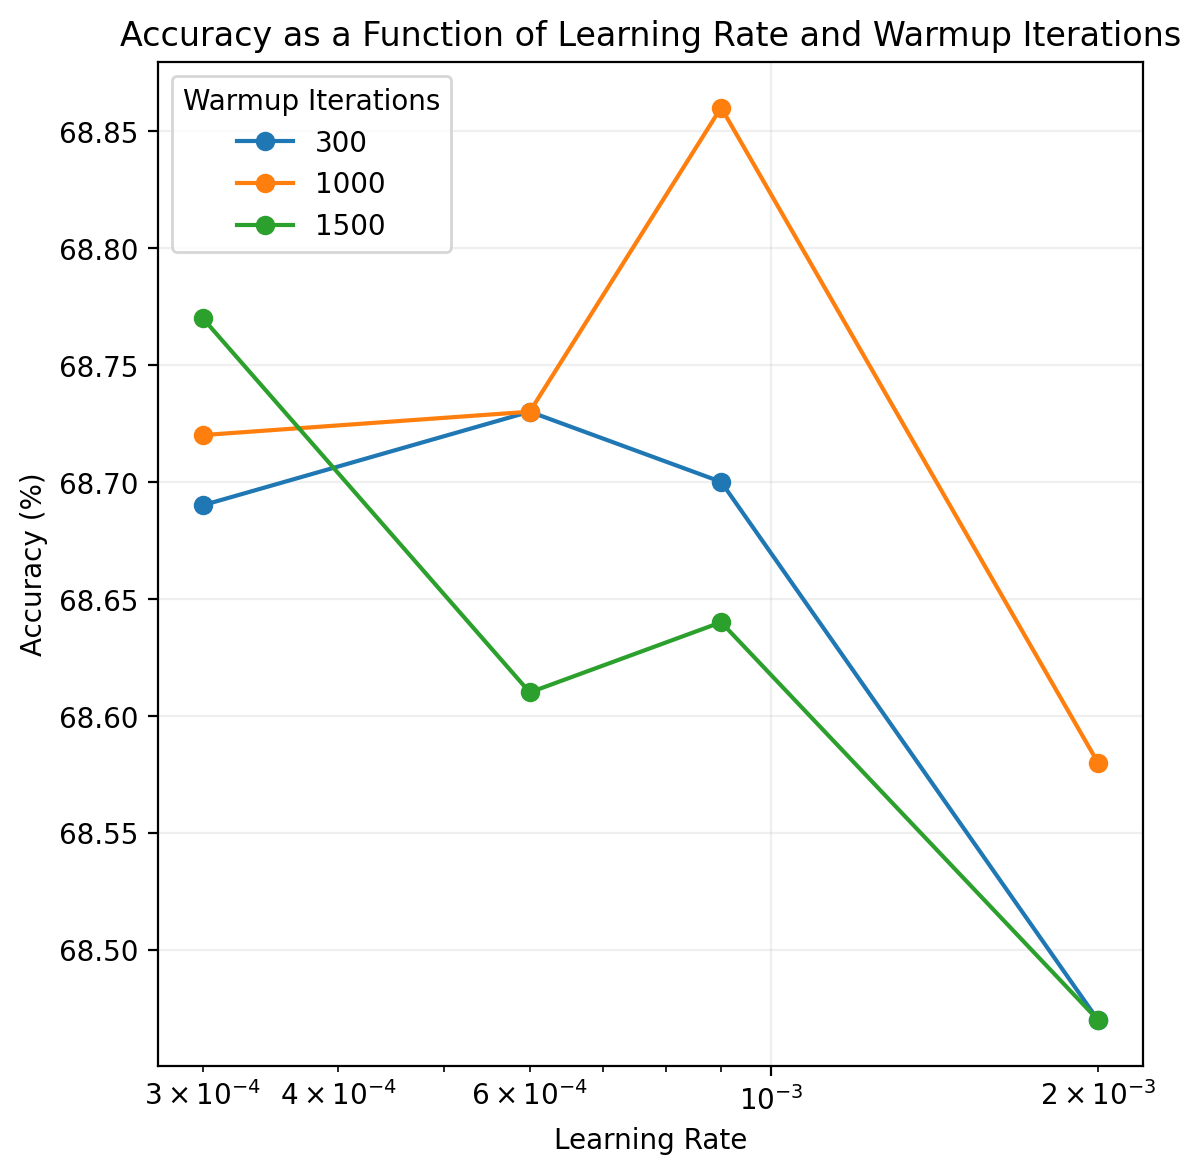

In [64]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'learning_rate' and 'warmup_iters'
accuracies = accuracies.sort_values(by=['learning_rate', 'warmup_iters'])

# Extract unique values of warmup_iters
warmup_iters_values = accuracies['warmup_iters'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each warmup_iters value
lines_labels = []
for warmup_iters in warmup_iters_values[:3]:  # Limiting to 3 lines
    subset = accuracies[accuracies['warmup_iters'] == warmup_iters]
    line, = plt.plot(subset['learning_rate'], subset['Accuracy'], marker='o', label=f'{warmup_iters}')
    lines_labels.append((warmup_iters, line))

# Sort lines and labels by warmup iterations
lines_labels.sort()

# Extract sorted lines and labels
sorted_lines = [line for _, line in lines_labels]
sorted_labels = [f'{warmup_iters}' for warmup_iters, _ in lines_labels]

plt.title('Accuracy as a Function of Learning Rate and Warmup Iterations')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.xscale('log')  # Set x-axis to log scale
plt.legend(sorted_lines, sorted_labels, title='Warmup Iterations', loc='upper left')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


## dropout and bias

was not tested since trend seemed obv for autoreg

## optimiser

In [68]:
accuracies=extract_accuracies('A4',autoreg=False)
parameters_list = ['weight_decay', 'grad_clip']
parameters_df = extract_parameters(parameters_list, 'A4',autoreg=False)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['weight_decay'] = accuracies['weight_decay'].astype(float)
accuracies['grad_clip'] = accuracies['grad_clip'].astype(float)
idx = accuracies.groupby(['weight_decay', 'grad_clip'])['Accuracy'].idxmax()
accuracies = accuracies.loc[idx].sort_values(by='Accuracy', ascending=False)
#accuracies.sort_values(by='Accuracy', ascending=False).head()

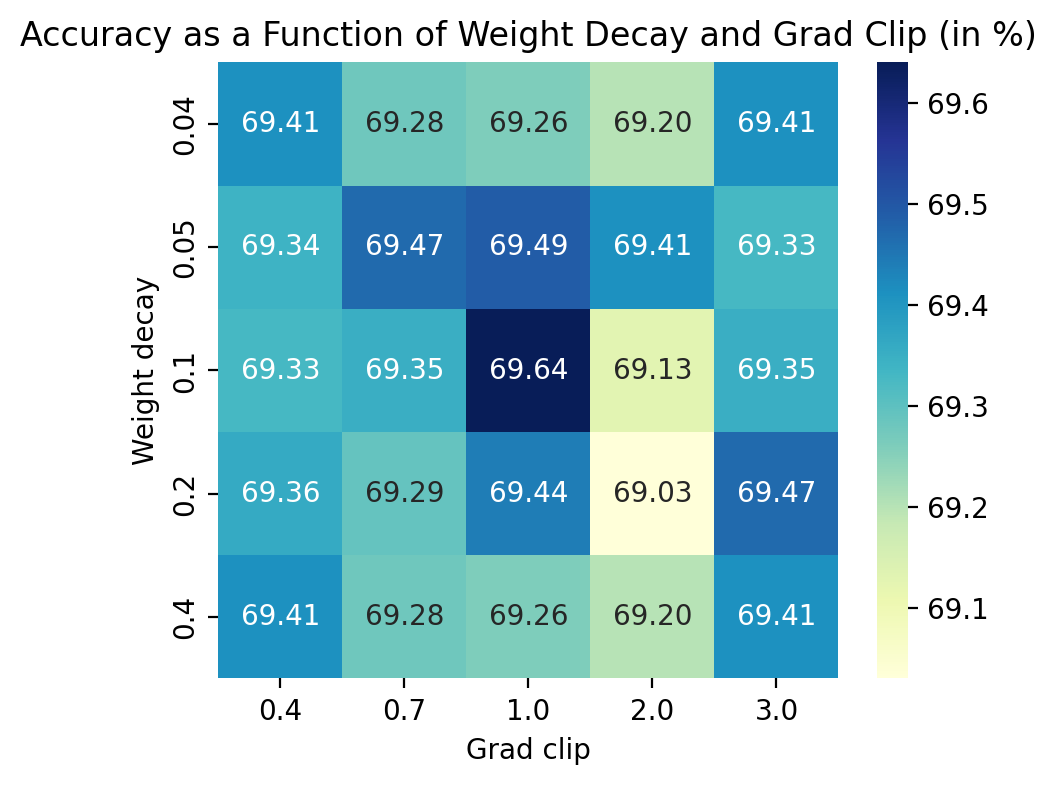

In [69]:
plot_heatmap(accuracies, 'weight_decay', 'grad_clip')

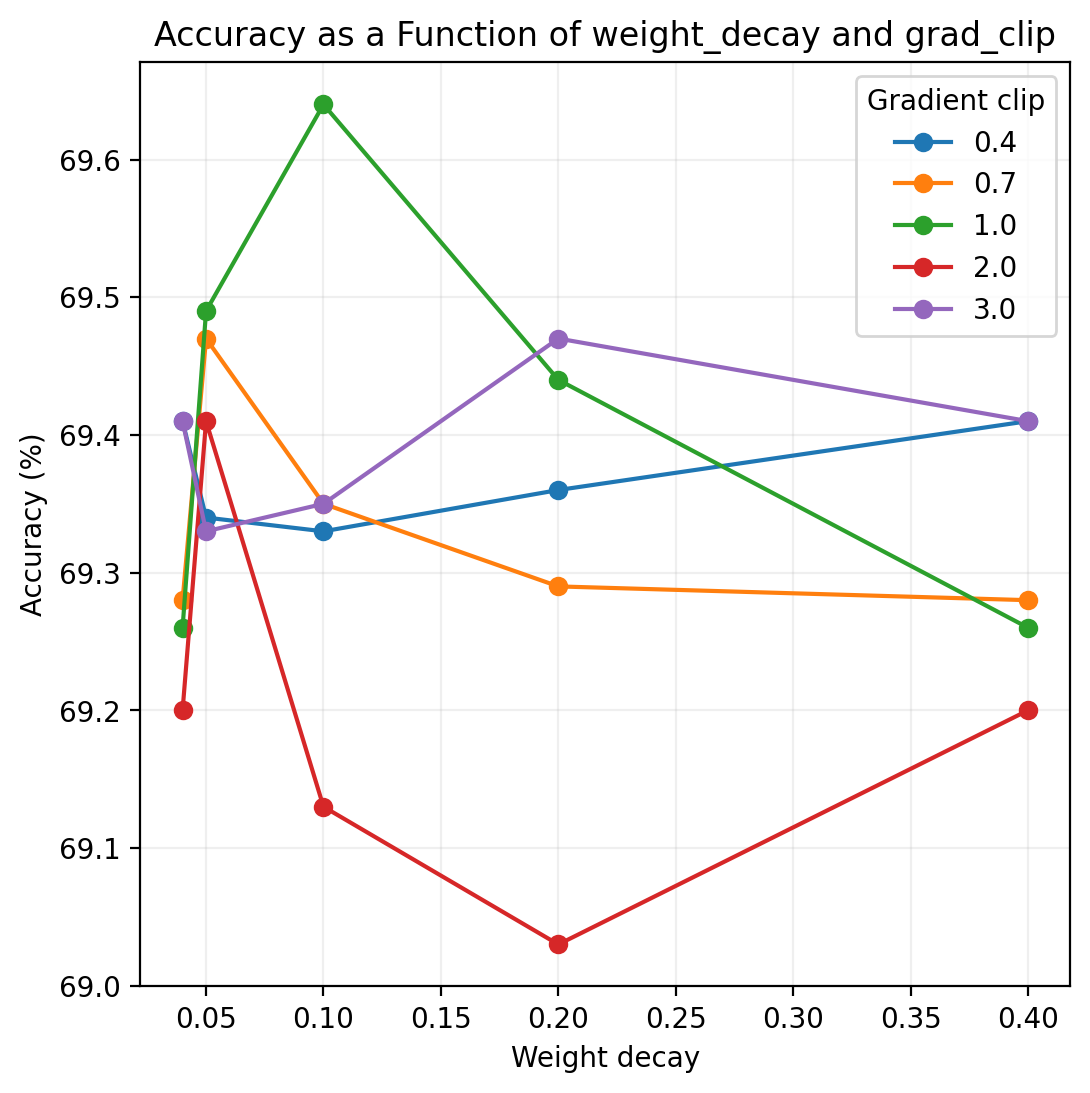

In [70]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'weight_decay' and 'grad_clip' to ensure correct plotting order
accuracies = accuracies.sort_values(by=['weight_decay', 'grad_clip'])

# Extract unique values of weight_decay and grad_clip
weight_decay_values = accuracies['weight_decay'].unique()
grad_clip_values = accuracies['grad_clip'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each grad_clip value
for grad_clip in grad_clip_values:
    subset = accuracies[accuracies['grad_clip'] == grad_clip]
    plt.plot(subset['weight_decay'], subset['Accuracy'], marker='o', label=f'{grad_clip}')

plt.xlabel('Weight decay')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of weight_decay and grad_clip')
plt.legend(title='Gradient clip')
plt.grid(True, alpha=0.2)
plt.show()


In [71]:
accuracies=extract_accuracies('A5',autoreg=False)
parameters_list = ['beta1', 'beta2']
parameters_df = extract_parameters(parameters_list, 'A5',autoreg=False)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['beta1'] = accuracies['beta1'].astype(float)
accuracies['beta2'] = accuracies['beta2'].astype(float)
#accuracies.sort_values(by='Accuracy', ascending=False).head()

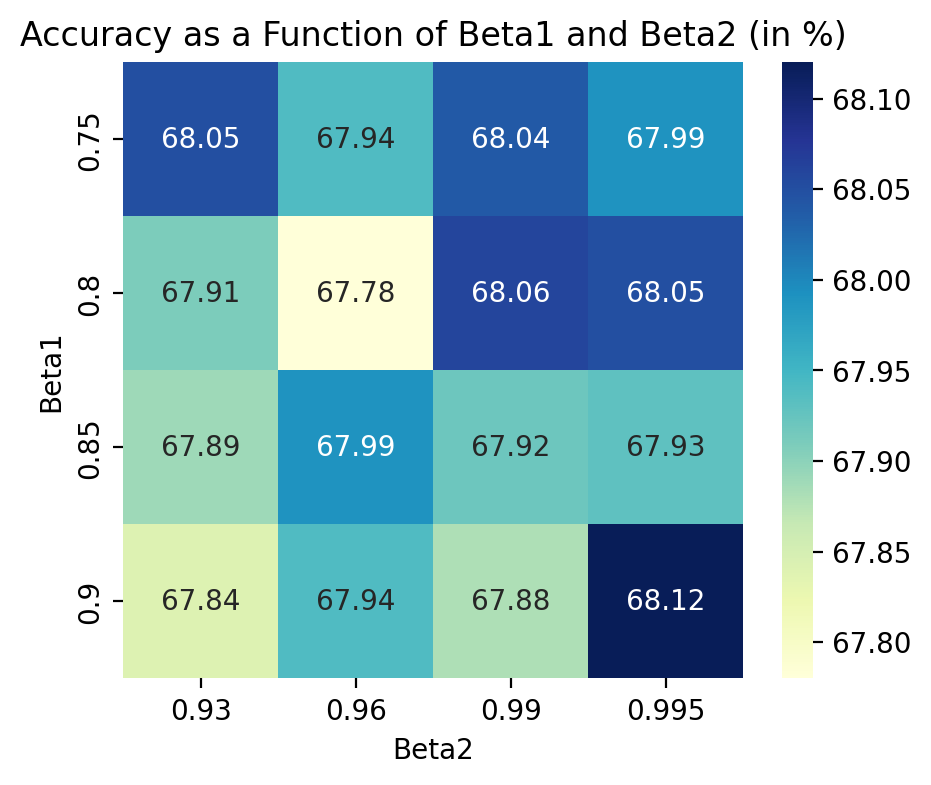

In [72]:
plot_heatmap(accuracies, 'beta1', 'beta2')

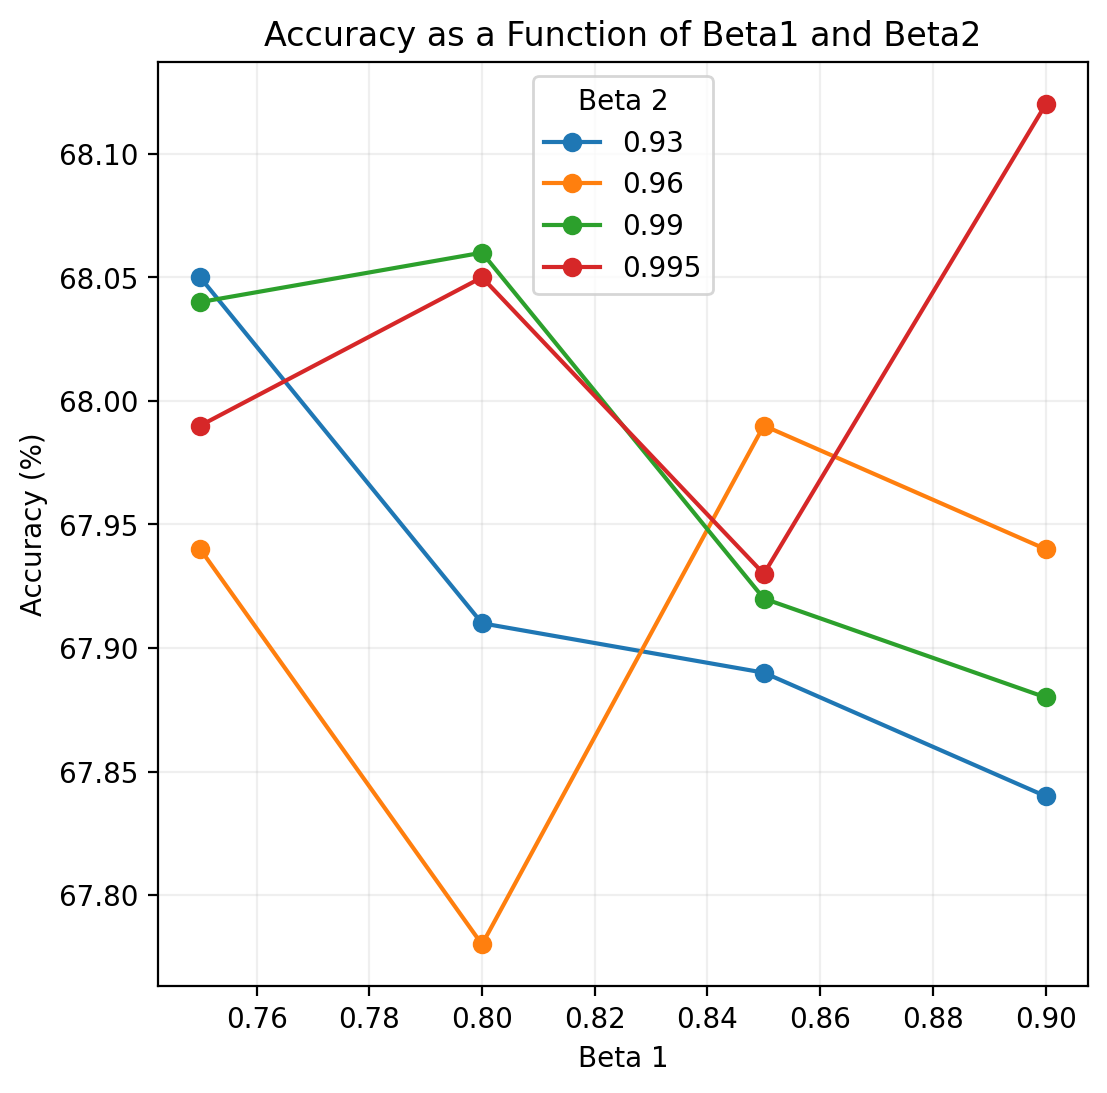

In [73]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'beta1' and 'beta2' to ensure correct plotting order
accuracies = accuracies.sort_values(by=['beta1', 'beta2'])

# Extract unique values of beta1 and beta2
beta1_values = accuracies['beta1'].unique()
beta2_values = accuracies['beta2'].unique()

plt.figure(figsize=(6, 6))

# Plot lines for each beta2 value
for beta2 in beta2_values:
    subset = accuracies[accuracies['beta2'] == beta2]
    plt.plot(subset['beta1'], subset['Accuracy'], marker='o', label=f'{beta2}')

plt.xlabel('Beta 1')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Beta1 and Beta2')
plt.legend(title='Beta 2')
plt.grid(True, alpha=0.2)
plt.show()


## best

In [ ]:
10
10
480
plot_heatmap(accuracies, 'gradient_accumulation_steps', 40'batch_size' 64)
learning_rate=9e-4
warmup_iter=1000
'weight_decay' 0.05 
'grad_clip')1
beta2 0.995
beta1=0.9

# mutation - context size

In [46]:
accuracies=extract_accuracies('A7',autoreg=False)
parameters_list = ['block_size']
parameters_df = extract_parameters(parameters_list, 'A7',autoreg=False)
accuracies = pd.merge(accuracies, parameters_df, on='Letter', how='inner')
accuracies['block_size'] = accuracies['block_size'].astype(float)
accuracies.sort_values(by='Accuracy', ascending=False).head()
idx = accuracies.groupby(['block_size', 'Eval data'])['Accuracy'].idxmax()
accuracies = accuracies.loc[idx].sort_values(by='Accuracy', ascending=False)
accuracies=accuracies.sort_values(by='block_size', ascending=True)

In [47]:
accuracies_add=extract_accuracies('A8',autoreg=False)
parameters_list = ['block_size']
parameters_df = extract_parameters(parameters_list, 'A8',autoreg=False)
accuracies_add = pd.merge(accuracies_add, parameters_df, on='Letter', how='inner')
accuracies_add['block_size'] = accuracies_add['block_size'].astype(float)
accuracies_add.sort_values(by='Accuracy', ascending=False).head()
idx = accuracies_add.groupby(['block_size', 'Eval data'])['Accuracy'].idxmax()
accuracies_add = accuracies_add.loc[idx].sort_values(by='Accuracy', ascending=False)
accuracies_add=accuracies_add.sort_values(by='block_size', ascending=True)
accuracies_add=accuracies_add[accuracies_add['block_size']>0]

In [48]:
accuracies = accuracies[(accuracies['block_size'] > 3) & (accuracies['block_size'] < 255)]

In [49]:
accuracies = pd.concat([accuracies, accuracies_add], axis=0, ignore_index=True)
accuracies=accuracies.sort_values(by='block_size', ascending=True)

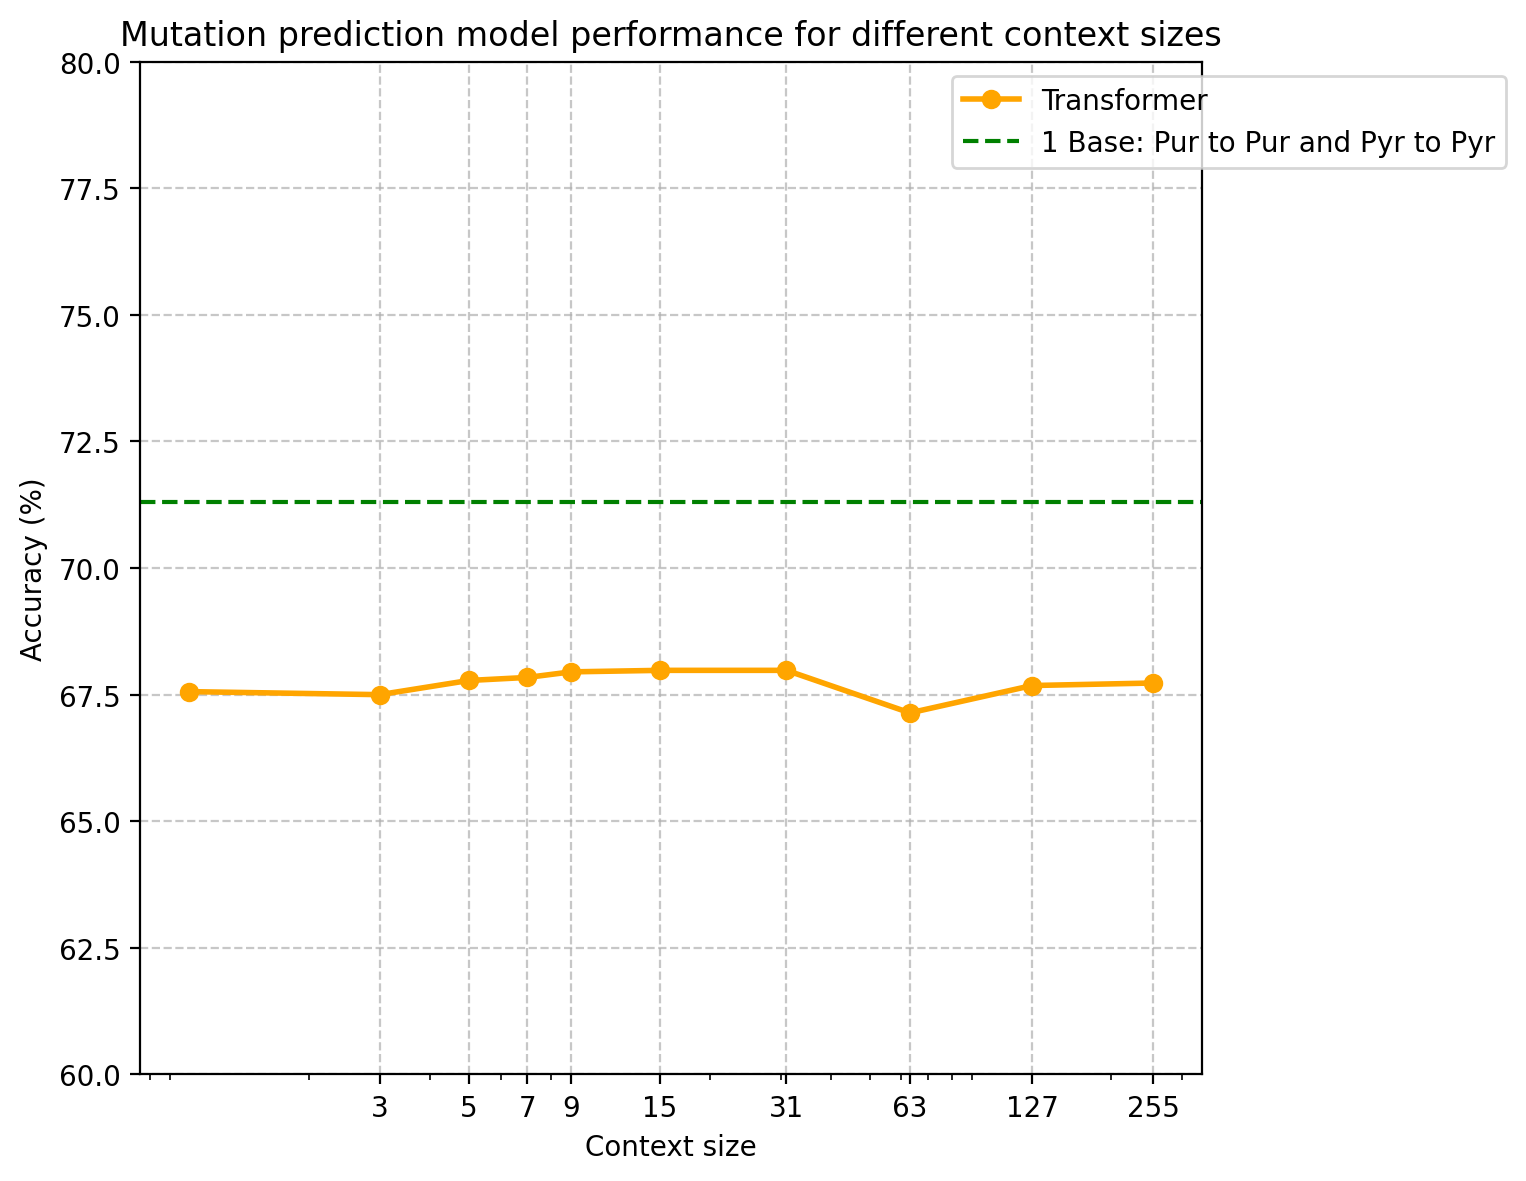

In [50]:
plt.figure(figsize=(8, 6))  # Increase figure size for better readability

accuracies_test =accuracies[accuracies['Eval data']=='test_set']


plt.plot(accuracies_test['block_size'], accuracies_test['Accuracy'], marker='o', label='Transformer', color='orange', linestyle='-', linewidth=2)


# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

#plt.plot(n_gram_train['context_size'], n_gram_train['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.7,label='N-grams of Chr1, evaluated on Chr22')
#plt.plot(n_gram_test['1'], n_gram_test['30.044'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of Chr22, evaluated on Chr22')



plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Mutation prediction model performance for different context sizes')
plt.ylim(60, 80)
#plt.xlim(5, 127)

plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([3, 5, 7, 9 ,15, 31 ,63 ,127, 255], labels=[3, 5, 7, 9 ,15, 31 ,63 ,127, 255])
#plt.xticks([ 5, 7, 9 ,15, 31 ,63 ,127], labels=[5, 7, 9 ,15, 31 ,63 ,127])

# TO DO: AM I SURE THIS IS CORRECT ? WHICH DATASET IS THIS DATA FROM??
plt.axhline(y=71.3, color='green', linestyle='--', label='1 Base: Pur to Pur and Pyr to Pyr')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

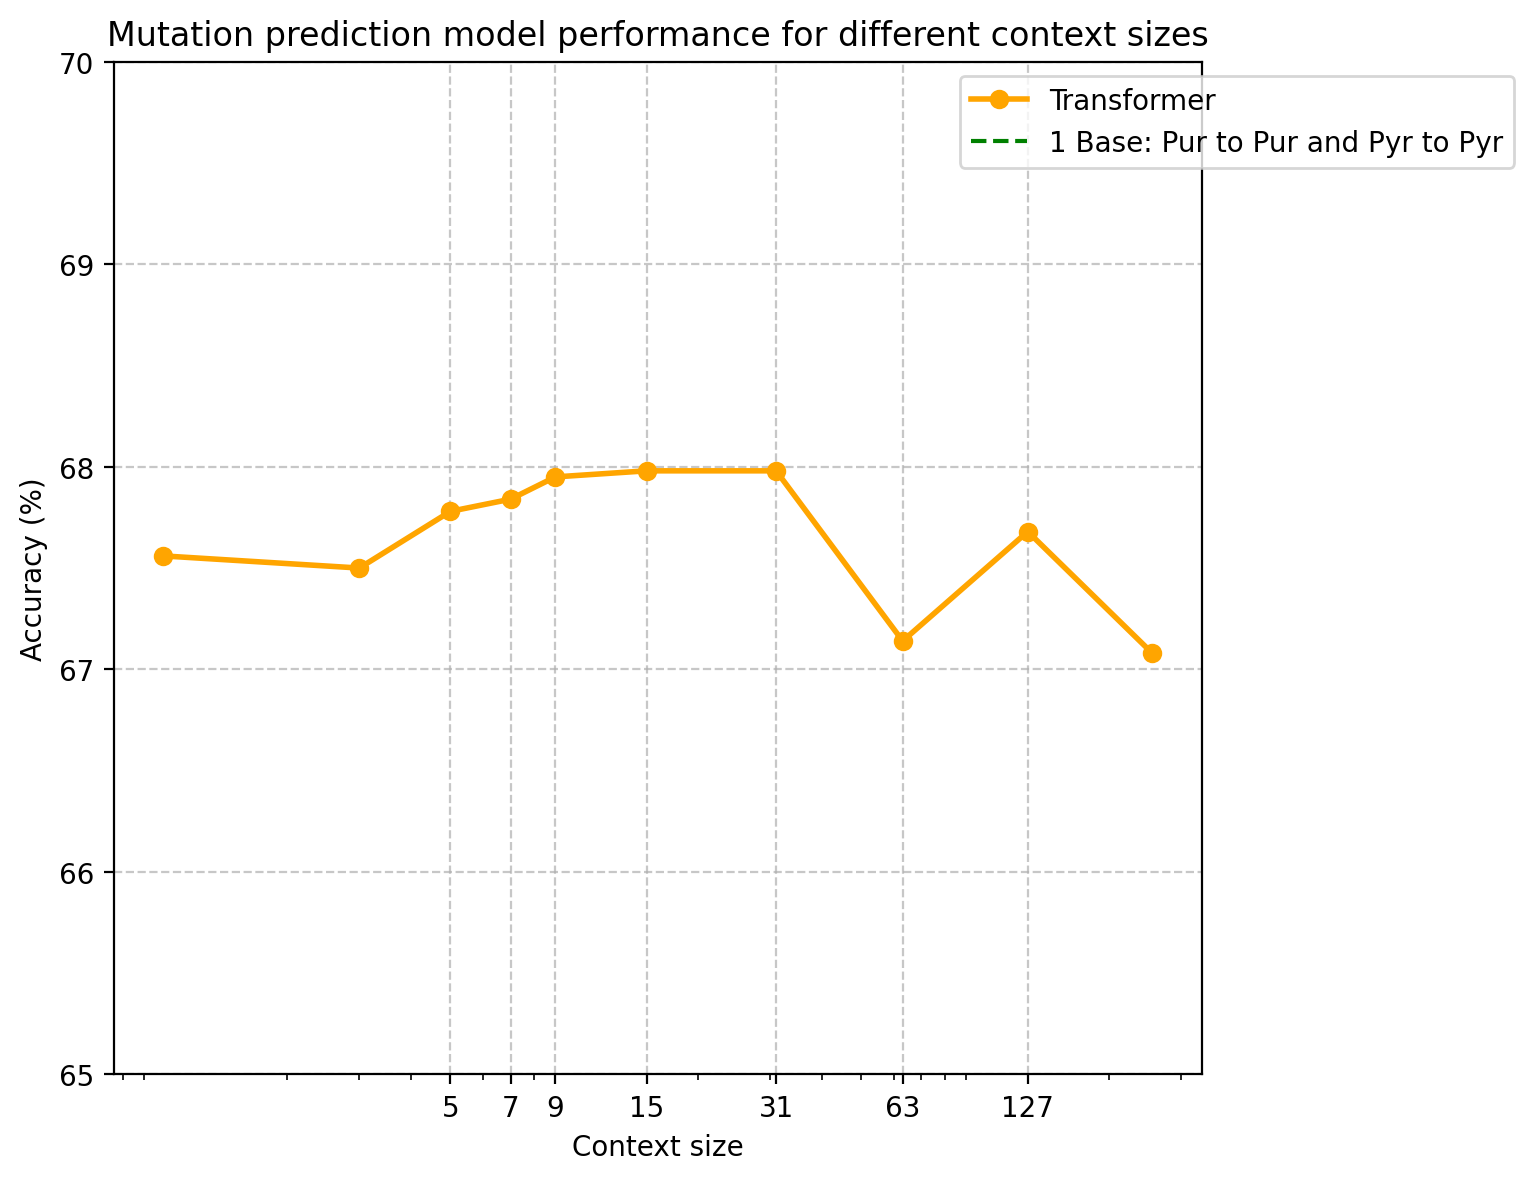

In [14]:
plt.figure(figsize=(8, 6))  # Increase figure size for better readability

accuracies_test =accuracies[accuracies['Eval data']=='test_set']


plt.plot(accuracies_test['block_size'], accuracies_test['Accuracy'], marker='o', label='Transformer', color='orange', linestyle='-', linewidth=2)


# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

#plt.plot(n_gram_train['context_size'], n_gram_train['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.7,label='N-grams of Chr1, evaluated on Chr22')
#plt.plot(n_gram_test['1'], n_gram_test['30.044'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of Chr22, evaluated on Chr22')



plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Mutation prediction model performance for different context sizes')
plt.ylim(65, 70)
#plt.xlim(5, 127)

plt.xscale('log')

# Ensure xticks are well positioned and clear
#plt.xticks([3, 5, 7, 9 ,15, 31 ,63 ,127, 255], labels=[3, 5, 7, 9 ,15, 31 ,63 ,127, 255])
plt.xticks([ 5, 7, 9 ,15, 31 ,63 ,127], labels=[5, 7, 9 ,15, 31 ,63 ,127])

# TO DO: AM I SURE THIS IS CORRECT ? WHICH DATASET IS THIS DATA FROM??
plt.axhline(y=71.3, color='green', linestyle='--', label='1 Base: Pur to Pur and Pyr to Pyr')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [12]:
accuracies

Letter  Accuracy        n Eval data  block_size
7     01     67.56  20000.0  test_set         1.0
8     02     67.50  20000.0  test_set         3.0
0     02     67.78  20000.0  test_set         5.0
1     03     67.84  20000.0  test_set         7.0
2     04     67.95  20000.0  test_set         9.0
3     05     67.98  20000.0  test_set        15.0
4     06     67.98  20000.0  test_set        31.0
5     07     67.14  20000.0  test_set        63.0
6     08     67.68  20000.0  test_set       127.0
9     03     67.08  20000.0  test_set       255.0

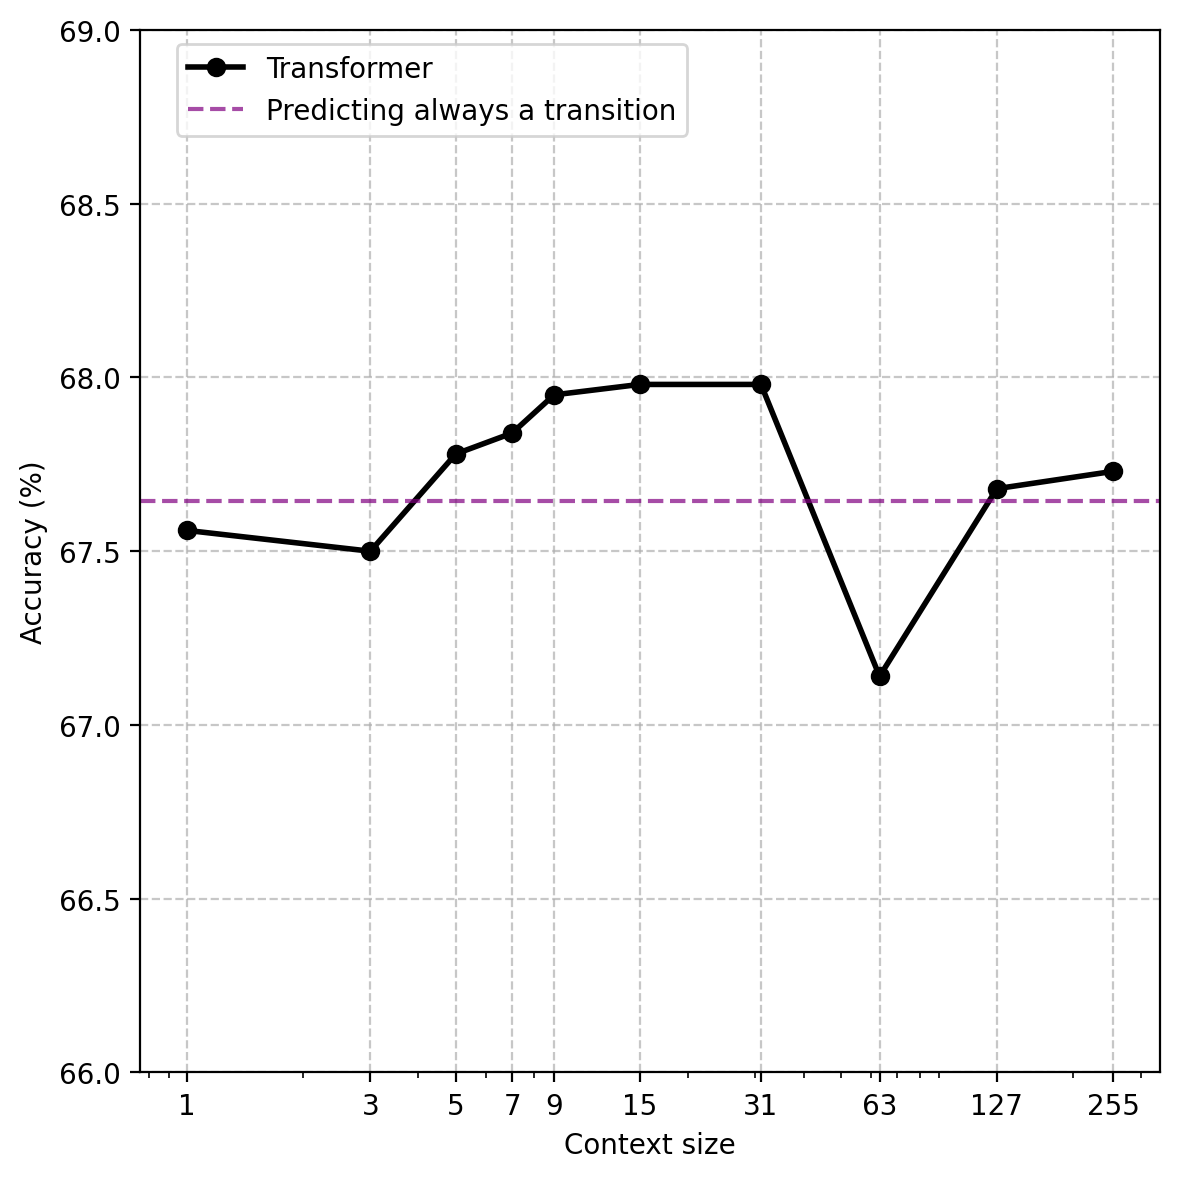

In [55]:
n_gram_model = pd.read_csv('../results/mutation_best_model_calc/Basic_summary_train.csv')



plt.figure(figsize=(6, 6))  # Increase figure size for better readability

accuracies_test =accuracies[accuracies['Eval data']=='test_set']
accuracies_val  =accuracies[accuracies['Eval data']=='val_set']
accuracies_train=accuracies[accuracies['Eval data']=='train_set']


plt.plot(accuracies_test['block_size'], accuracies_test['Accuracy'], marker='o', label='Transformer', color='black', linestyle='-', linewidth=2)
#plt.plot(accuracies_val['block_size'], accuracies_val['Accuracy'], marker='o', label='val', color='orange', linestyle='-', linewidth=2)
#plt.plot(accuracies_train['block_size'], accuracies_train['Accuracy'], marker='o', label='train', color='yellow', linestyle='-', linewidth=2)



# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

#plt.plot(n_gram_model['context_size'], n_gram_model['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.7,label='N-grams of train, evaluated on test')
#plt.plot(n_gram_model['context_size'], n_gram_model['accuracy_with_perfect_test'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of test, evaluated on test')


plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
#plt.title('Mutation prediction model performance for different context sizes')
plt.ylim(66, 69)
#plt.xlim(5, 127)

plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,3, 5, 7, 9 ,15, 31 ,63 ,127, 255], labels=[1,3, 5, 7, 9 ,15, 31 ,63 ,127, 255])
#plt.xticks([ 5, 7, 9 ,15, 31 ,63 ,127], labels=[5, 7, 9 ,15, 31 ,63 ,127])

# TO DO: AM I SURE THIS IS CORRECT ? WHICH DATASET IS THIS DATA FROM??
plt.axhline(y=67.645, color='purple', linestyle='--', alpha=0.7, label='Predicting always a transition')

plt.legend(loc='upper right', bbox_to_anchor=(0.55, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

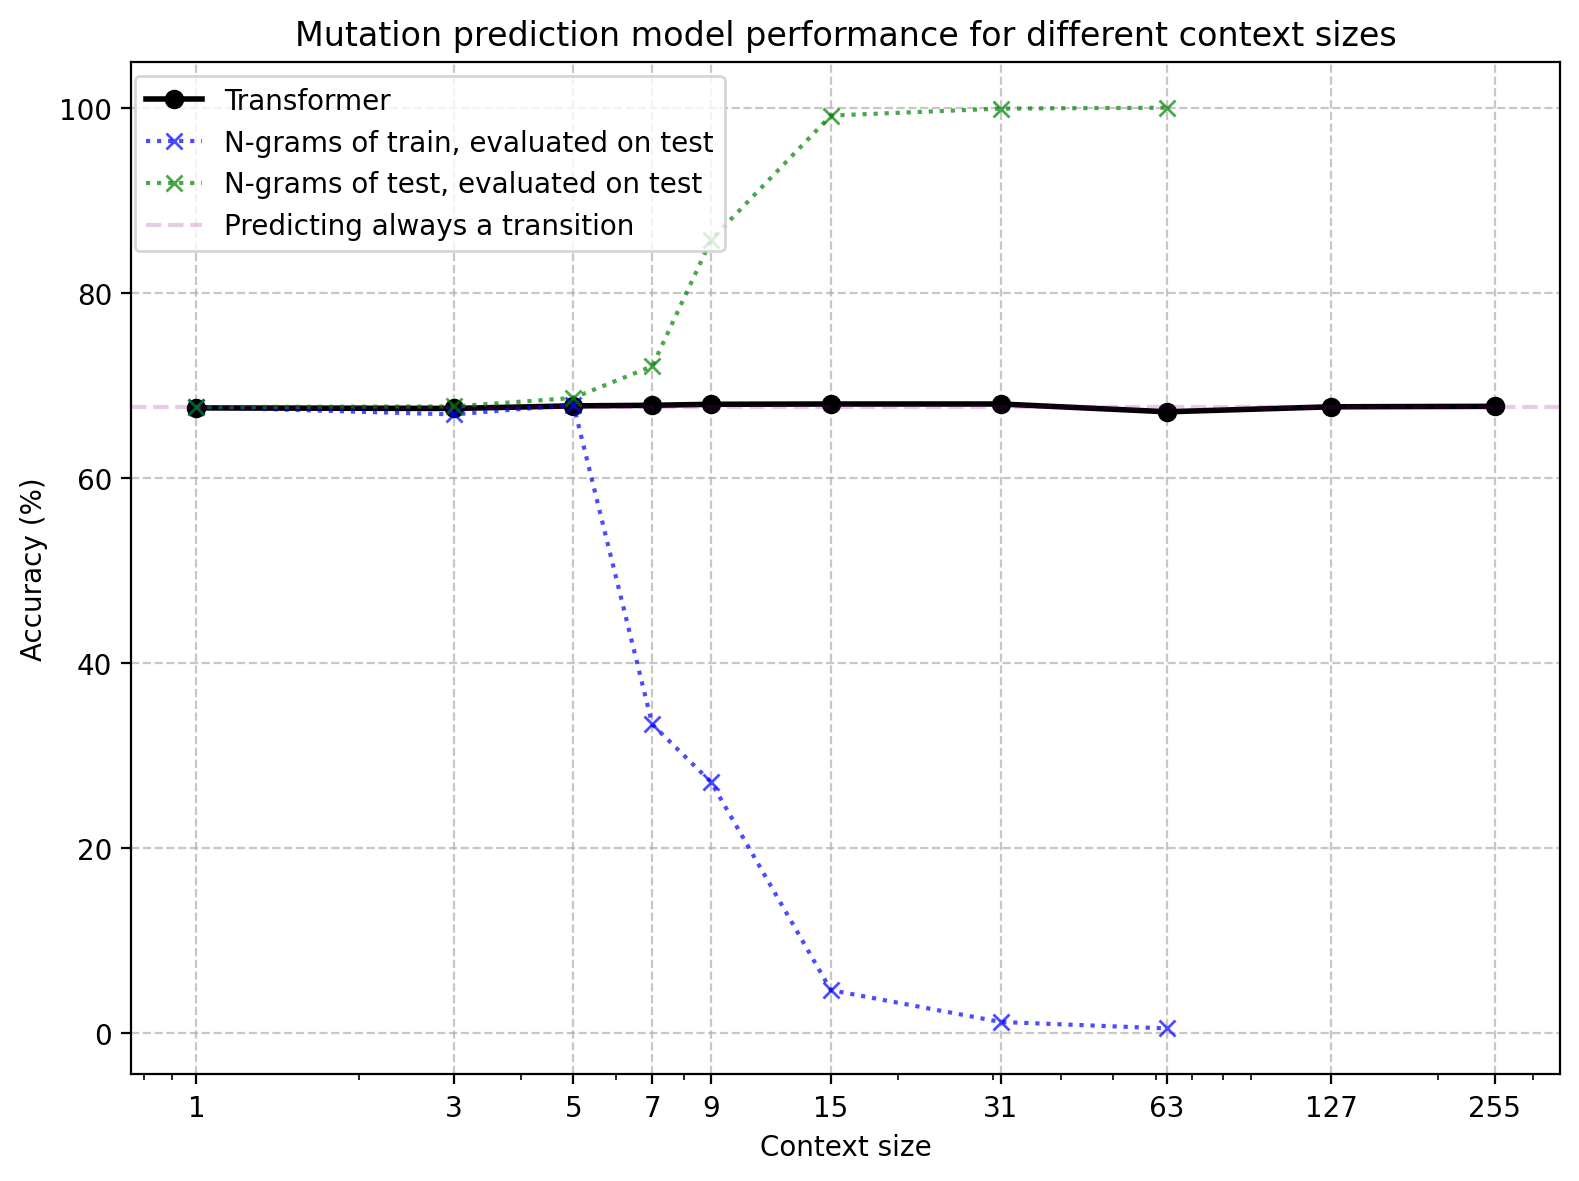

In [58]:
n_gram_model = pd.read_csv('../results/mutation_best_model_calc/Basic_summary_train.csv')



plt.figure(figsize=(8, 6))  # Increase figure size for better readability

accuracies_test =accuracies[accuracies['Eval data']=='test_set']
accuracies_val  =accuracies[accuracies['Eval data']=='val_set']
accuracies_train=accuracies[accuracies['Eval data']=='train_set']


plt.plot(accuracies_test['block_size'], accuracies_test['Accuracy'], marker='o', label='Transformer', color='black', linestyle='-', linewidth=2)
#plt.plot(accuracies_val['block_size'], accuracies_val['Accuracy'], marker='o', label='val', color='orange', linestyle='-', linewidth=2)
#plt.plot(accuracies_train['block_size'], accuracies_train['Accuracy'], marker='o', label='train', color='yellow', linestyle='-', linewidth=2)



# Plot n-gram model with conditional coloring
#plt.plot(ngram_context_size_small, ngram_accuracy_small, marker='o', color='green', linestyle='-', label='N-gramm test')
#plt.plot(ngram_context_size_large, ngram_accuracy_large, marker='o', color='lightgreen', linestyle=':', label='-- model becomes useless')

plt.plot(n_gram_model['context_size'], n_gram_model['best_accuracy_train'], marker='x', color='blue', linestyle='dotted', alpha=0.7,label='N-grams of train, evaluated on test')
plt.plot(n_gram_model['context_size'], n_gram_model['accuracy_with_perfect_test'], marker='x', color='green', linestyle='dotted', alpha=0.7,label='N-grams of test, evaluated on test')


plt.xlabel('Context size')
plt.ylabel('Accuracy (%)')
plt.title('Mutation prediction model performance for different context sizes')
#plt.ylim(65, 70)
#plt.xlim(5, 127)

plt.xscale('log')

# Ensure xticks are well positioned and clear
plt.xticks([1,3, 5, 7, 9 ,15, 31 ,63 ,127, 255], labels=[1,3, 5, 7, 9 ,15, 31 ,63 ,127, 255])
#plt.xticks([ 5, 7, 9 ,15, 31 ,63 ,127], labels=[5, 7, 9 ,15, 31 ,63 ,127])

# TO DO: AM I SURE THIS IS CORRECT ? WHICH DATASET IS THIS DATA FROM??
plt.axhline(y=67.645, color='purple', linestyle='--', alpha=0.2, label='Predicting always a transition')

plt.legend(loc='upper right', bbox_to_anchor=(0.425, 1))  # Move the legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed grid lines for less visual clutter
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

3 AND 255 ARE BEING EVALUATED ON THE VAL SET, DIDNT CREATE A TEST SET YET.... FFS...
ALL!!!! MY MUTATION DATA SO FAR IS USELESS CAUSE I DIDNT TEST ON TEST SET!!!


also test on train set! looks shitty


also maybe plot loss instead if sure that it shows something different 


